In [1]:
#import adagram
#import gensim
import pandas as pd
from lxml import html
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.wsd import lesk
from pymorphy2 import MorphAnalyzer
from string import punctuation
import json, os
from collections import Counter
import numpy as np
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
morph = MorphAnalyzer()
punct = punctuation+'«»—…#“”*№–'
latin = 'qwertyuioplkjhgfdsazxcvbnmQWERTYUIOPASDFGHJKLZXCVBNM'
stops = set(stopwords.words('russian'))

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Александра\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
def normalize(text):
    
    try:
        words = [word.strip(punct) for word in text.lower().split()]
        words = [morph.parse(word)[0].normal_form for word in words if word and word not in stops and word[:1] not in latin]

        return ' '.join(words)
    except:
        pass
        

def tokenize(text):
    
    words = [word.strip(punct) for word in text.lower().split()]

    return ' '.join(words)

In [144]:
punct

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~«»—…#“”*№–1234567890'

In [155]:
'nfnf'[:1]

'n'

In [5]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Александра\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
import gensim

In [6]:
from gensim.models import Word2Vec
from gensim import matutils
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [12]:
full = pd.read_csv('full.csv')
full.head()

контекст  \
0  Определение С. В. Гринева является примером ла...   
1  Так, например, слова: referee I судья или bask...   
2  Второй вариант перевода: Eine Fliege - klein u...   
3  При этом французский переводчик сохранил рифму...   
4  В первом варианте происходит транспозиция обра...   

                                           snippet_x  \
0  Определение С. В. Гринева является примером ла...   
1  Так, например, слова: referee I судья или bask...   
2  Второй вариант перевода: Eine Fliege - klein u...   
3  При этом французский переводчик сохранил рифму...   
4  В первом варианте происходит транспозиция обра...   

                                           snippet_y   category_id  \
0  В. М. Лейчик давал следующее определение терми...  comparison_m   
1  в то время как flank I фланг на поле, draw I с...  comparison_m   
2  Первый вариант перевода: Es fliegt die Fliege ...  comparison_m   
3  в то время как немецкий переводчик ограничился...  comparison_m   
4  в других вариантах - либо золотым отсветом - a...  comparison_m   

                                    маркер  
0                                      NaN  
1                           в то время как  
2         первый вариант... второй вариант  
3                           в то время как  
4  в первом варианте... в других вариантах

In [22]:
full_data = pd.DataFrame({
    'full':full['контекст']})

full_data['full_norm'] = full_data['full'].apply(normalize)
full_data = full_data.dropna()
full_data.head()

full  \
0  Определение С. В. Гринева является примером ла...   
1  Так, например, слова: referee I судья или bask...   
2  Второй вариант перевода: Eine Fliege - klein u...   
3  При этом французский переводчик сохранил рифму...   
4  В первом варианте происходит транспозиция обра...   

                                           full_norm  
0  определение гринев являться пример лаконичный ...  
1  например слово судья корзина являться полность...  
2       два вариант перевод один вариант перевод 9 3  
3  французский переводчик сохранить рифма внутри ...  
4  первое вариант происходить транспозиция образ ...

In [23]:
full_data.shape

(502, 2)

In [24]:
tfidf = TfidfVectorizer()
tfidf = tfidf.fit(full_data['full_norm'])
X_tfidf = tfidf.transform(full_data['full_norm'])

In [25]:
full['first_norm'] = full['snippet_x'].apply(normalize)
full['second_norm'] = full['snippet_y'].apply(normalize)
full.head()

контекст  \
0  Определение С. В. Гринева является примером ла...   
1  Так, например, слова: referee I судья или bask...   
2  Второй вариант перевода: Eine Fliege - klein u...   
3  При этом французский переводчик сохранил рифму...   
4  В первом варианте происходит транспозиция обра...   

                                           snippet_x  \
0  Определение С. В. Гринева является примером ла...   
1  Так, например, слова: referee I судья или bask...   
2  Второй вариант перевода: Eine Fliege - klein u...   
3  При этом французский переводчик сохранил рифму...   
4  В первом варианте происходит транспозиция обра...   

                                           snippet_y   category_id  \
0  В. М. Лейчик давал следующее определение терми...  comparison_m   
1  в то время как flank I фланг на поле, draw I с...  comparison_m   
2  Первый вариант перевода: Es fliegt die Fliege ...  comparison_m   
3  в то время как немецкий переводчик ограничился...  comparison_m   
4  в других вариантах - либо золотым отсветом - a...  comparison_m   

                                    маркер  \
0                                      NaN   
1                           в то время как   
2         первый вариант... второй вариант   
3                           в то время как   
4  в первом варианте... в других вариантах   

                                          first_norm  \
0  определение гринев являться пример лаконичный ...   
1  например слово судья корзина являться полность...   
2                                два вариант перевод   
3  французский переводчик сохранить рифма внутри ...   
4  первое вариант происходить транспозиция образ ...   

                                         second_norm  
0  метр лейчик давать следующий определение терми...  
1  время фланг пол сыграть вничью перехват являть...  
2                           один вариант перевод 9 3  
3  время немецкий переводчик ограничиться бола св...  
4  другой вариант либо золотой отсвет либо сверка...

In [7]:
data_all = pd.read_csv('full_no_cons.csv')
data_all.head()

контекст  \
0  Определение С. В. Гринева является примером ла...   
1  Так, например, слова: referee I судья или bask...   
2  Второй вариант перевода: Eine Fliege - klein u...   
3  При этом французский переводчик сохранил рифму...   
4  В первом варианте происходит транспозиция обра...   

                                           snippet_x  \
0  Определение С. В. Гринева является примером ла...   
1  Так, например, слова: referee I судья или bask...   
2  Второй вариант перевода: Eine Fliege - klein u...   
3  При этом французский переводчик сохранил рифму...   
4  В первом варианте происходит транспозиция обра...   

                                           snippet_y   category_id  \
0  В. М. Лейчик давал следующее определение терми...  comparison_m   
1  в то время как flank I фланг на поле, draw I с...  comparison_m   
2  Первый вариант перевода: Es fliegt die Fliege ...  comparison_m   
3  в то время как немецкий переводчик ограничился...  comparison_m   
4  в других вариантах - либо золотым отсветом - a...  comparison_m   

                                    маркер  
0                                       NO  
1                           в то время как  
2         первый вариант... второй вариант  
3                           в то время как  
4  в первом варианте... в других вариантах

In [67]:
data_all.shape

(832, 5)

In [28]:
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import FastTextKeyedVectors

In [30]:
#w2v = KeyedVectors.load('araneum_none_fasttextcbow_300_5_2018.model')

In [ ]:
def get_embedding(text, model, idf=False):
    try:
        text = text.split()
    except:
        print(text)
    # чтобы не доставать одно слово несколько раз
    # сделаем счетчик, а потом векторы домножим на частоту
    words = Counter(text)
    total = len(text)
    vectors = np.zeros((len(words), 300))
    
    for i, word in enumerate(words):
        try:
            if idf:
                _idf = tfidf.idf_[word2id_tv[word]]
                v = model[word] / _idf
                vectors[i] = v*(words[word]/total) # просто умножаем вектор на частоту
            else:
                v = model[word]
                #print(word)
                vectors[i] = v*(words[word]/total) # просто умножаем вектор на частоту
                #print("vectors[i]")
        except (KeyError, ValueError):
            continue
    
    if vectors.any():
        vector = np.average(vectors, axis=0)
    else:
        vector = np.zeros((300))
    
    return vector

In [17]:
a = np.zeros(3)
a[2] = 3
a

array([0., 0., 3.])

In [165]:
dim = 50
X_text_1_w2v_f = []
X_text_2_w2v_f = []
print(len(full['first_norm'].values))

for i, text in enumerate(full['first_norm'].values):
    #print(text)
    X_text_1_w2v_f.append(get_embedding(text, w2v))
    
for i, text in enumerate(full['second_norm'].values):
    X_text_2_w2v_f.append(get_embedding(text, w2v))

#X_text_w2v = [X_text_1_w2v, X_text_2_w2v]
print(len(X_text_1_w2v_f))


983
983


In [122]:
id2word_tv = {i:w for i,w in enumerate(tfidf.get_feature_names())}
word2id_tv = {w:i for i,w in id2word_tv.items()}

In [166]:

X_text_1_w2v_tf_f = []
X_text_2_w2v_tf_f = []

for i, text in enumerate(full['first_norm'].values):
    X_text_1_w2v_tf_f.append(get_embedding(text, w2v, tfidf))
    
for i, text in enumerate(full['second_norm'].values):
    X_text_2_w2v_tf_f.append(get_embedding(text, w2v, tfidf))

#X_text_w2v_tf = [X_text_1_w2v, X_text_2_w2v]

In [167]:
X_text_2_w2v_tf_f[:2]

[array([ 3.90887599e-05, -1.56836303e-05, -8.11775068e-05, -2.10266903e-04,
        -1.37318981e-04, -1.12030834e-04,  2.27377182e-04, -5.35859210e-05,
        -3.45461199e-05, -5.77775059e-04,  3.37228855e-04, -1.58127285e-04,
        -3.23971117e-04,  3.90355431e-05, -4.19766946e-04,  5.67260735e-05,
         2.01234298e-05, -7.06972395e-05,  2.57802705e-04,  4.30084034e-05,
        -1.36569332e-04, -5.41603921e-06, -1.25382441e-04, -2.00578291e-05,
         6.97836829e-05,  1.11710707e-04, -2.07092877e-04,  4.74760193e-05,
         4.67032599e-05, -3.39362936e-04,  1.63603085e-04, -8.98114308e-05,
         1.45714060e-05, -1.83601300e-04,  2.21823100e-04,  1.82032142e-04,
        -3.11653450e-04,  5.63174142e-04, -6.10441802e-05,  3.98861723e-04,
         1.67632893e-04,  2.27379694e-04,  1.99626752e-04, -1.24355523e-04,
        -1.84263264e-05, -2.15018310e-04,  2.07455131e-04,  3.72799994e-05,
         4.58011737e-05, -1.92407614e-04, -6.92463721e-05, -9.26934992e-05,
        -3.4

In [26]:
X_text_2_w2v_tf[:3]

[array([-2.55259245e-04, -2.46920325e-04, -2.51489234e-04,  4.55496538e-04,
        -4.40865937e-04,  3.16585766e-04,  1.28283527e-04,  8.26318067e-05,
        -5.71638563e-04, -2.27599176e-05,  2.29351732e-04,  3.72020314e-04,
        -3.17682237e-04, -2.27757058e-05,  1.24069907e-04,  5.71061325e-05,
         8.37684171e-05, -3.15997561e-04,  1.18766125e-04, -1.90532748e-04,
         2.56278145e-04, -2.66727648e-04, -1.44005038e-05, -4.22945412e-04,
         1.89624432e-04, -3.03344476e-04,  3.08905459e-04, -3.38281732e-04,
         4.14635608e-04, -6.41650962e-05,  6.04542541e-04,  1.31256127e-04,
        -1.34306113e-05,  1.92815830e-05, -4.22036283e-06, -1.50966391e-04,
         3.87394686e-04,  1.79153558e-04, -3.19680818e-04,  2.12962665e-04,
        -5.04646112e-04, -1.41207735e-04, -1.05110563e-04,  3.47339178e-04,
         2.60941896e-04, -1.47189182e-05,  1.56546082e-04, -2.58767108e-04,
         2.60299133e-04, -1.78413400e-04,  2.23419536e-04,  3.51269089e-04,
        -4.4

In [8]:
with open('lex_is.csv', 'r', encoding='utf-8') as g:
    lex = g.readlines()
    for ind, el in enumerate(lex):
        if ind != 0:
            el = el.strip('\n')
            lex[ind] = int(el)

with open('verb_tu.csv', 'r', encoding='utf-8') as g:
    verb_tu = g.readlines()
    for ind, el in enumerate(verb_tu):
        if ind != 0:
            el = el.strip('\n')
            verb_tu[ind] = int(el)

with open('neg_list.csv', 'r', encoding='utf-8') as g:
    neg_list = g.readlines()
    for ind, el in enumerate(neg_list):
        if ind != 0:
            el = el.strip('\n')
            neg_list[ind] = int(el)

with open('neg_re.csv', 'r', encoding='utf-8') as g:
    neg_re = g.readlines()
    for ind, el in enumerate(neg_re):
        if ind != 0:
            el = el.strip('\n')
            neg_re[ind] = int(el)

with open('subj_tu.csv', 'r', encoding='utf-8') as g:
    subj_tu = g.readlines()
    for ind, el in enumerate(subj_tu):
        if ind != 0:
            el = el.strip('\n')
            subj_tu[ind] = int(el)


In [15]:
ig_comp = res_4.to_csv(index=False)
ig_comp_l = ig_comp.split('\n')

ig_contr = res_5.to_csv(index=False)
ig_contr_l = ig_contr.split('\n')

ig_all = ig_comp_l+ig_contr_l[1:]
ig_all_tf = []
ig_all_notf = []
for el in ig_all[1:]:
    el = el.split(',')
    try:
        ig_all_tf.append(float(el[0]))
        ig_all_notf.append(float(el[1]))
    except:
        print(el)

['']
['']


In [16]:
with open('part.csv', 'r', encoding='utf-8') as g:
    part = g.readlines()
    for ind, el in enumerate(part):
        if ind != 0:
            el = el.strip('\n')
            part[ind] = int(el)

with open('subj_my.csv', 'r', encoding='utf-8') as g:
    subj_my = g.readlines()
    for ind, el in enumerate(subj_my):
        if ind != 0:
            #el = el.strip('\n')
            subj_my[ind] = int(el)

In [20]:
data = pd.DataFrame({
    'full':data_all['контекст'],
    'no_tf':res_3['no_tf'],
    'with_tf':res_3['with_tf'],
    'verb_tu':verb_tu[1:],
    'lex':lex[1:],
    'neg_list':neg_list[1:],
    'neg_re':neg_re[1:],
    'subj_tu':subj_tu[1:],
    'ig_no_tf':ig_all_notf,
    'ig_tf':ig_all_tf,
    'part':part[1:],
    'subj_my':subj_my[1:]
}
)
data.head()

full      ig_no_tf     ig_tf  \
0  Определение С. В. Гринева является примером ла...  1.000000e+00  0.964147   
1  Так, например, слова: referee I судья или bask...  0.000000e+00  1.010283   
2  Второй вариант перевода: Eine Fliege - klein u...  0.000000e+00  0.924908   
3  При этом французский переводчик сохранил рифму...  2.220446e-16  0.046173   
4  В первом варианте происходит транспозиция обра...  0.000000e+00  1.000000   

   lex  neg_list  neg_re     no_tf  part  subj_my  subj_tu  verb_tu   with_tf  
0    1         0       1  0.094875     1        1        1        0  0.089050  
1    1         0       0  0.617450     0        0        0        0  0.503783  
2    1         0       0  0.075453     0        0        0        1  0.114287  
3    1         0       1  0.597002     0        1        1        0  0.615182  
4    1         0       0  0.391545     0        0        0        0  0.517879

In [23]:
cla = []
for el in data_all['category_id']:
    try:
        if 'Contrast' in el:
            cla.append(0)
        elif 'comparison' in el:
            cla.append(1)
    except:
        break
print(len(cla))

832


In [26]:
from sklearn.pipeline import Pipeline
from sklearn import model_selection

In [27]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, cla, stratify=cla, 
                                                                      test_size=0.25, shuffle=True)
print('train', X_train.shape[0])
print('test', X_test.shape[0])

train 624
test 208


In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
import itertools
from sklearn.metrics import accuracy_score, f1_score

In [34]:
columns_all = ['ig_no_tf','ig_tf','lex','neg_list','neg_re','no_tf','part','subj_my','subj_tu','verb_tu','with_tf']

In [73]:
%%time


model = Pipeline([
    ('enc', OneHotEncoder()),
    ('est', RandomForestClassifier()),
])

best = []

base = 0.63
param_num = [1, 3, 5, 9, 10]
for num in param_num:
    for i in itertools.combinations(columns_all, num):
        columns = list(i)


        model.fit(X_train[columns], y_train)
        
        train_acc = f1_score(y_train, model.predict(X_train[columns]),  average='macro')
        test_acc = f1_score(y_test, model.predict(X_test[columns]),  average='macro')
        if test_acc > base:

            print(' <--> '.join(columns))
            print('train', train_acc)
            print('test', test_acc)
            print('|||||')


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> neg_re
train 0.6481864311219696
test 0.6539512774806893
|||||
ig_no_tf <--> ig_tf <--> neg_re <--> no_tf <--> subj_my
train 0.6454243862603991
test 0.6404211849756405
|||||
ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> neg_re <--> no_tf <--> subj_tu <--> verb_tu <--> with_tf
train 0.6591377651532506
test 0.6395841355410088
|||||
ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> no_tf <--> subj_my <--> subj_tu <--> verb_tu <--> with_tf
train 0.6638252021986116
test 0.6332665929534113
|||||
ig_tf <--> lex <--> neg_list <--> neg_re <--> no_tf <--> part <--> subj_my <--> subj_tu <--> with_tf
train 0.6270983864834031
test 0.6334586466165413
|||||
ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> neg_re <--> no_tf <--> subj_my <--> subj_tu <--> verb_tu <--> with_tf
train 0.6652314464543642
test 0.641025641025641
|||||
ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> no_tf <--> part <--> subj_my <--> subj_tu <--> verb_tu <--> with_tf
train 0.6720754445

In [47]:
win = ['ig_no_tf' , 'ig_tf' , 'neg_list' , 'neg_re' , 'no_tf' , 'subj_tu' , 'verb_tu' , 'with_tf']

In [48]:
%%time


params = {'n_estimators': [5, 10, 50, 100, 200],
       'max_depth': [5, 10, 50, 100, None],
       'min_samples_leaf': [1, 5, 10, 50, 100, 200],
       'criterion': ['gini', 'entropy']}

model = GridSearchCV(RandomForestClassifier(), 
                         param_grid=params, 
                         cv=5, 
                         n_jobs=-1, 
                         scoring='accuracy', verbose=5)




model.fit(X_train[win], y_train)

train_acc = accuracy_score(y_train, model.predict(X_train[win]))
test_acc = accuracy_score(y_test, model.predict(X_test[win]))


print(' <--> '.join(win))
print('train', train_acc)
print('test', test_acc)
print('|||||')



Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  2.1min


ig_no_tf <--> ig_tf <--> neg_list <--> neg_re <--> no_tf <--> subj_tu <--> verb_tu <--> with_tf
train 0.8333333333333334
test 0.8028846153846154
|||||
Wall time: 2min 12s


[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  2.2min finished


In [49]:
model.best_params_

{'criterion': 'gini',
 'max_depth': 50,
 'min_samples_leaf': 5,
 'n_estimators': 5}

In [75]:
%%time


#params = {'n_estimators': [5, 10, 50],
#       'max_depth': [5, 10, 50, 100, None],
#       'min_samples_leaf': [1, 5, 10, 50],
#       'criterion': ['gini', 'entropy']}

        
params = {'n_estimators': [5, 10, 50, 100],
       'max_depth': [5, 10, 50, 100, None],
       'min_samples_leaf': [1, 5, 10, 50, 100],
       'criterion': ['gini', 'entropy']}
        
model = GridSearchCV(RandomForestClassifier(), 
                         param_grid=params, 
                         cv=5, 
                         n_jobs=-1, 
                         scoring='f1_macro', verbose=5)


base = 0.65

param_num = [5, 7, 11]
for num in param_num:
    for i in itertools.combinations(columns_all, num):
        columns = list(i)


        model.fit(X_train[columns], y_train)

        train_f1 = f1_score(y_train, model.predict(X_train[columns]), average='macro')
        test_f1 = f1_score(y_test, model.predict(X_test[columns]), average='macro')
        if test_f1 > base:

            print(' <--> '.join(columns))
            print('train', train_f1)
            print('test', test_f1)
            print('|||||')
            print(model.best_params_)



Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   57.5s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> neg_re
train 0.7835227509262728
test 0.7188747446173189
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   54.4s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> no_tf
train 0.7896966779008184
test 0.7435897435897436
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 668 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   54.7s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> part
train 0.7965479153081458
test 0.7748917748917747
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 468 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.1s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> subj_my
train 0.794073275862069
test 0.7515847496554892
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.1s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> subj_tu
train 0.7869090098126672
test 0.7435897435897436
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 668 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.9s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> verb_tu
train 0.7991373205433593
test 0.7651812240047534
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.9s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> with_tf
train 0.7762025316455696
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.6s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> no_tf
train 0.7660861787762403
test 0.7225720400756847
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.5s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> part
train 0.7728462820099967
test 0.7378405455191804
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.1s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> subj_my
train 0.7789108185901178
test 0.7067669172932332
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.6s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> subj_tu
train 0.7876560707532443
test 0.7463740213066359
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.2s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> verb_tu
train 0.7982804869660912
test 0.7564102564102564
|||||
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.1s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> with_tf
train 0.7663581773225008
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.2s finished


ig_no_tf <--> ig_tf <--> lex <--> no_tf <--> part
train 0.8143433980153995
test 0.7358145030276178
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.6s finished


ig_no_tf <--> ig_tf <--> lex <--> no_tf <--> subj_my
train 0.7686219141744748
test 0.7378405455191804
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.2s finished


ig_no_tf <--> ig_tf <--> lex <--> no_tf <--> subj_tu
train 0.7791932059447984
test 0.7282605232132046
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   54.1s finished


ig_no_tf <--> ig_tf <--> lex <--> no_tf <--> verb_tu
train 0.8025723914987275
test 0.7354756661186761
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   53.2s finished


ig_no_tf <--> ig_tf <--> lex <--> no_tf <--> with_tf
train 0.8273456121343445
test 0.7498797498797498
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   53.4s finished


ig_no_tf <--> ig_tf <--> lex <--> part <--> subj_my
train 0.7531331684916991
test 0.7378405455191804
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.9s finished


ig_no_tf <--> ig_tf <--> lex <--> part <--> subj_tu
train 0.7635945747985755
test 0.7330252855859325
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 444 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   59.6s finished


ig_no_tf <--> ig_tf <--> lex <--> part <--> verb_tu
train 0.7597227570273392
test 0.7378405455191804
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.5s finished


ig_no_tf <--> ig_tf <--> lex <--> part <--> with_tf
train 0.764172335600907
test 0.7367088607594936
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.0s finished


ig_no_tf <--> ig_tf <--> lex <--> subj_my <--> subj_tu
train 0.7686219141744748
test 0.7272386661671038
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.0min finished


ig_no_tf <--> ig_tf <--> lex <--> subj_my <--> verb_tu
train 0.7613852009363329
test 0.7512846201079404
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.6s finished


ig_no_tf <--> ig_tf <--> lex <--> subj_my <--> with_tf
train 0.806023763470572
test 0.7450259311645451
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.9s finished


ig_no_tf <--> ig_tf <--> lex <--> subj_tu <--> verb_tu
train 0.7957418950067513
test 0.7402273011115275
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.6s finished


ig_no_tf <--> ig_tf <--> lex <--> subj_tu <--> with_tf
train 0.7965113858706965
test 0.7150049389797024
|||||
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.2s finished


ig_no_tf <--> ig_tf <--> lex <--> verb_tu <--> with_tf
train 0.7904786300525812
test 0.7225720400756847
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.2s finished


ig_no_tf <--> ig_tf <--> neg_list <--> neg_re <--> no_tf
train 0.8269756387403446
test 0.7509273051198925
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.7s finished


ig_no_tf <--> ig_tf <--> neg_list <--> neg_re <--> part
train 0.781838573559904
test 0.7547716916802091
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.1s finished


ig_no_tf <--> ig_tf <--> neg_list <--> neg_re <--> subj_my
train 0.7547966035092515
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.2s finished


ig_no_tf <--> ig_tf <--> neg_list <--> neg_re <--> subj_tu
train 0.8017050793596556
test 0.7498797498797498
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.0s finished


ig_no_tf <--> ig_tf <--> neg_list <--> neg_re <--> verb_tu
train 0.7947986582989197
test 0.761282918204659
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.8s finished


ig_no_tf <--> ig_tf <--> neg_list <--> neg_re <--> with_tf
train 0.7890038547372693
test 0.7581015244381581
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.9s finished


ig_no_tf <--> ig_tf <--> neg_list <--> no_tf <--> part
train 0.7775210713216104
test 0.7243964709304205
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   56.8s finished


ig_no_tf <--> ig_tf <--> neg_list <--> no_tf <--> subj_my
train 0.7949086325547985
test 0.7341448569689593
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   53.8s finished


ig_no_tf <--> ig_tf <--> neg_list <--> no_tf <--> subj_tu
train 0.806023763470572
test 0.7630379746835443
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   55.9s finished


ig_no_tf <--> ig_tf <--> neg_list <--> no_tf <--> verb_tu
train 0.815837838562977
test 0.7483792921616677
|||||
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   55.0s finished


ig_no_tf <--> ig_tf <--> neg_list <--> no_tf <--> with_tf
train 0.7974406724641643
test 0.7435897435897436
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   56.1s finished


ig_no_tf <--> ig_tf <--> neg_list <--> part <--> subj_my
train 0.7734915471663536
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.9s finished


ig_no_tf <--> ig_tf <--> neg_list <--> part <--> subj_tu
train 0.7531331684916991
test 0.7378405455191804
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.0s finished


ig_no_tf <--> ig_tf <--> neg_list <--> part <--> verb_tu
train 0.7719951854186967
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   53.4s finished


ig_no_tf <--> ig_tf <--> neg_list <--> part <--> with_tf
train 0.7842527109853843
test 0.7547716916802091
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.7s finished


ig_no_tf <--> ig_tf <--> neg_list <--> subj_my <--> subj_tu
train 0.8059694862551467
test 0.7692307692307692
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.7s finished


ig_no_tf <--> ig_tf <--> neg_list <--> subj_my <--> verb_tu
train 0.7600775787270964
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   56.9s finished


ig_no_tf <--> ig_tf <--> neg_list <--> subj_my <--> with_tf
train 0.7852128713731898
test 0.7294861325348577
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.6s finished


ig_no_tf <--> ig_tf <--> neg_list <--> subj_tu <--> verb_tu
train 0.7657649440267745
test 0.7512846201079404
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.9s finished


ig_no_tf <--> ig_tf <--> neg_list <--> subj_tu <--> with_tf
train 0.7782114183764495
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.4s finished


ig_no_tf <--> ig_tf <--> neg_list <--> verb_tu <--> with_tf
train 0.7564102564102564
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.6s finished


ig_no_tf <--> ig_tf <--> neg_re <--> no_tf <--> part
train 0.8102338931506381
test 0.731950337890932
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.0s finished


ig_no_tf <--> ig_tf <--> neg_re <--> no_tf <--> subj_my
train 0.7897901010624515
test 0.7528223410576351
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.0s finished


ig_no_tf <--> ig_tf <--> neg_re <--> no_tf <--> subj_tu
train 0.8023835319609968
test 0.7498797498797498
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.7s finished


ig_no_tf <--> ig_tf <--> neg_re <--> no_tf <--> verb_tu
train 0.8146167557932263
test 0.7995268553404012
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.9s finished


ig_no_tf <--> ig_tf <--> neg_re <--> no_tf <--> with_tf
train 0.7949086325547985
test 0.7564102564102564
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.9s finished


ig_no_tf <--> ig_tf <--> neg_re <--> part <--> subj_my
train 0.7574435003205172
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 984 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.8s finished


ig_no_tf <--> ig_tf <--> neg_re <--> part <--> subj_tu
train 0.7938911391964953
test 0.7402273011115275
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.6s finished


ig_no_tf <--> ig_tf <--> neg_re <--> part <--> verb_tu
train 0.7946879856628817
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   53.2s finished


ig_no_tf <--> ig_tf <--> neg_re <--> part <--> with_tf
train 0.8032813275559073
test 0.7358145030276178
|||||
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.3s finished


ig_no_tf <--> ig_tf <--> neg_re <--> subj_my <--> subj_tu
train 0.7878522959077474
test 0.7692307692307692
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.9s finished


ig_no_tf <--> ig_tf <--> neg_re <--> subj_my <--> verb_tu
train 0.7914865178193919
test 0.7515847496554892
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   53.6s finished


ig_no_tf <--> ig_tf <--> neg_re <--> subj_my <--> with_tf
train 0.7857793622499505
test 0.718984962406015
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.2s finished


ig_no_tf <--> ig_tf <--> neg_re <--> subj_tu <--> verb_tu
train 0.775159828006877
test 0.7630379746835443
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.2s finished


ig_no_tf <--> ig_tf <--> neg_re <--> subj_tu <--> with_tf
train 0.8152809676925432
test 0.7179487179487178
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.7s finished


ig_no_tf <--> ig_tf <--> neg_re <--> verb_tu <--> with_tf
train 0.8137038574914124
test 0.7354756661186761
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.7s finished


ig_no_tf <--> ig_tf <--> no_tf <--> part <--> subj_my
train 0.7973283042589974
test 0.753215936055951
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.1s finished


ig_no_tf <--> ig_tf <--> no_tf <--> part <--> subj_tu
train 0.7719951854186967
test 0.7291666666666665
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.9s finished


ig_no_tf <--> ig_tf <--> no_tf <--> part <--> verb_tu
train 0.8173083321134371
test 0.7564102564102564
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.2s finished


ig_no_tf <--> ig_tf <--> no_tf <--> part <--> with_tf
train 0.7791932059447984
test 0.7367088607594936
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.9s finished


ig_no_tf <--> ig_tf <--> no_tf <--> subj_my <--> subj_tu
train 0.7734915471663536
test 0.7402273011115275
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.5s finished


ig_no_tf <--> ig_tf <--> no_tf <--> subj_my <--> verb_tu
train 0.7795831861533027
test 0.7498734177215189
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.5s finished


ig_no_tf <--> ig_tf <--> no_tf <--> subj_my <--> with_tf
train 0.7772146227405737
test 0.7483792921616677
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.7s finished


ig_no_tf <--> ig_tf <--> no_tf <--> subj_tu <--> verb_tu
train 0.7832778454079503
test 0.7354756661186761
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   53.7s finished


ig_no_tf <--> ig_tf <--> no_tf <--> subj_tu <--> with_tf
train 0.7815829634711506
test 0.7367088607594936
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   53.4s finished


ig_no_tf <--> ig_tf <--> no_tf <--> verb_tu <--> with_tf
train 0.8094211875486863
test 0.7225720400756847
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.0s finished


ig_no_tf <--> ig_tf <--> part <--> subj_my <--> subj_tu
train 0.7844708483006355
test 0.731950337890932
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.5s finished


ig_no_tf <--> ig_tf <--> part <--> subj_my <--> verb_tu
train 0.7772146227405737
test 0.7450259311645451
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.2s finished


ig_no_tf <--> ig_tf <--> part <--> subj_my <--> with_tf
train 0.7939885824334547
test 0.7402273011115275
|||||
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.0s finished


ig_no_tf <--> ig_tf <--> part <--> subj_tu <--> verb_tu
train 0.7713838547317124
test 0.7282605232132046
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.3s finished


ig_no_tf <--> ig_tf <--> part <--> subj_tu <--> with_tf
train 0.764172335600907
test 0.7330252855859325
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.4s finished


ig_no_tf <--> ig_tf <--> part <--> verb_tu <--> with_tf
train 0.7772146227405737
test 0.7354756661186761
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.3s finished


ig_no_tf <--> ig_tf <--> subj_my <--> subj_tu <--> verb_tu
train 0.7846474517776905
test 0.7564102564102564
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.1s finished


ig_no_tf <--> ig_tf <--> subj_my <--> subj_tu <--> with_tf
train 0.7678563357265789
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.8s finished


ig_no_tf <--> ig_tf <--> subj_my <--> verb_tu <--> with_tf
train 0.7876560707532443
test 0.731950337890932
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.3s finished


ig_no_tf <--> ig_tf <--> subj_tu <--> verb_tu <--> with_tf
train 0.7758230031835239
test 0.7463740213066359
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.6s finished


ig_no_tf <--> lex <--> neg_list <--> neg_re <--> no_tf
train 0.7725344644750796
test 0.7341448569689593
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.8s finished


ig_no_tf <--> lex <--> neg_list <--> neg_re <--> part
train 0.7735397492275753
test 0.7623857623857624
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.5s finished


ig_no_tf <--> lex <--> neg_list <--> neg_re <--> subj_my
train 0.7547966035092515
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 984 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.0s finished


ig_no_tf <--> lex <--> neg_list <--> neg_re <--> subj_tu
train 0.7564102564102564
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.7s finished


ig_no_tf <--> lex <--> neg_list <--> neg_re <--> verb_tu
train 0.7662771510809817
test 0.7367088607594936
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.7s finished


ig_no_tf <--> lex <--> neg_list <--> neg_re <--> with_tf
train 0.7855560659419181
test 0.7156250000000001
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.9s finished


ig_no_tf <--> lex <--> neg_list <--> no_tf <--> part
train 0.7715390991986737
test 0.7243964709304205
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.2s finished


ig_no_tf <--> lex <--> neg_list <--> no_tf <--> subj_my
train 0.7775401069518717
test 0.753215936055951
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.4s finished


ig_no_tf <--> lex <--> neg_list <--> no_tf <--> subj_tu
train 0.7590610104047428
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.7s finished


ig_no_tf <--> lex <--> neg_list <--> no_tf <--> verb_tu
train 0.7715390991986737
test 0.7243964709304205
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.1s finished


ig_no_tf <--> lex <--> neg_list <--> no_tf <--> with_tf
train 0.7763440860215054
test 0.731950337890932
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.6s finished


ig_no_tf <--> lex <--> neg_list <--> part <--> subj_my
train 0.7564102564102564
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.2s finished


ig_no_tf <--> lex <--> neg_list <--> part <--> subj_tu
train 0.7542967670627245
test 0.7067060173798982
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.1s finished


ig_no_tf <--> lex <--> neg_list <--> part <--> verb_tu
train 0.7704883735840271
test 0.7402273011115275
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.3s finished


ig_no_tf <--> lex <--> neg_list <--> part <--> with_tf
train 0.769513826940232
test 0.7203475979668799
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 984 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.2s finished


ig_no_tf <--> lex <--> neg_list <--> subj_my <--> subj_tu
train 0.7564102564102564
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.9s finished


ig_no_tf <--> lex <--> neg_list <--> subj_my <--> verb_tu
train 0.7547966035092515
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.3s finished


ig_no_tf <--> lex <--> neg_list <--> subj_my <--> with_tf
train 0.7718143459915612
test 0.7291666666666665
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.7s finished


ig_no_tf <--> lex <--> neg_list <--> subj_tu <--> verb_tu
train 0.7564102564102564
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.8s finished


ig_no_tf <--> lex <--> neg_list <--> subj_tu <--> with_tf
train 0.765584126885656
test 0.7063278141445257
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.0s finished


ig_no_tf <--> lex <--> neg_list <--> verb_tu <--> with_tf
train 0.7775185453135655
test 0.7156250000000001
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.2s finished


ig_no_tf <--> lex <--> neg_re <--> no_tf <--> part
train 0.7553614416397276
test 0.7330252855859325
|||||
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.2s finished


ig_no_tf <--> lex <--> neg_re <--> no_tf <--> subj_my
train 0.7772629310344827
test 0.7307692307692308
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.8s finished


ig_no_tf <--> lex <--> neg_re <--> no_tf <--> subj_tu
train 0.7564102564102564
test 0.7463740213066359
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.6s finished


ig_no_tf <--> lex <--> neg_re <--> no_tf <--> verb_tu
train 0.7932131495227995
test 0.6923076923076923
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.0s finished


ig_no_tf <--> lex <--> neg_re <--> no_tf <--> with_tf
train 0.8150400479467894
test 0.6663101604278076
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.2s finished


ig_no_tf <--> lex <--> neg_re <--> part <--> subj_my
train 0.7716354151417963
test 0.700627775225846
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.3s finished


ig_no_tf <--> lex <--> neg_re <--> part <--> subj_tu
train 0.7725344644750796
test 0.7169040921876417
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 1, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.5s finished


ig_no_tf <--> lex <--> neg_re <--> part <--> verb_tu
train 0.7711740098875428
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.4s finished


ig_no_tf <--> lex <--> neg_re <--> part <--> with_tf
train 0.802257872846108
test 0.7272386661671038
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.6s finished


ig_no_tf <--> lex <--> neg_re <--> subj_my <--> subj_tu
train 0.7639963182997238
test 0.7770632368703109
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 1, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   45.9s finished


ig_no_tf <--> lex <--> neg_re <--> subj_my <--> verb_tu
train 0.7688577586206897
test 0.7498734177215189
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.6s finished


ig_no_tf <--> lex <--> neg_re <--> subj_my <--> with_tf
train 0.7705341159818492
test 0.7378405455191804
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.7s finished


ig_no_tf <--> lex <--> neg_re <--> subj_tu <--> verb_tu
train 0.7688577586206897
test 0.7498734177215189
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 1, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.6s finished


ig_no_tf <--> lex <--> neg_re <--> subj_tu <--> with_tf
train 0.7697972982037213
test 0.7450259311645451
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.6s finished


ig_no_tf <--> lex <--> neg_re <--> verb_tu <--> with_tf
train 0.782051282051282
test 0.7203475979668799
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.3s finished


ig_no_tf <--> lex <--> no_tf <--> part <--> subj_my
train 0.6701466895731466
test 0.6738922972051806
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 50, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.9s finished


ig_no_tf <--> lex <--> no_tf <--> part <--> subj_tu
train 0.7662045710003746
test 0.7243964709304205
|||||
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.6s finished


ig_no_tf <--> lex <--> no_tf <--> part <--> verb_tu
train 0.7855560659419181
test 0.7150049389797024
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.2s finished


ig_no_tf <--> lex <--> no_tf <--> part <--> with_tf
train 0.7413650179607626
test 0.6884050734045739
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.2s finished


ig_no_tf <--> lex <--> no_tf <--> subj_my <--> subj_tu
train 0.7597227570273392
test 0.7251222413109555
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.6s finished


ig_no_tf <--> lex <--> no_tf <--> subj_my <--> verb_tu
train 0.7613867186814807
test 0.7203475979668799
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.1s finished


ig_no_tf <--> lex <--> no_tf <--> subj_my <--> with_tf
train 0.7663581773225008
test 0.7203475979668799
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.6s finished


ig_no_tf <--> lex <--> no_tf <--> subj_tu <--> verb_tu
train 0.7618750260189001
test 0.7243964709304205
|||||
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.9s finished


ig_no_tf <--> lex <--> no_tf <--> subj_tu <--> with_tf
train 0.7678563357265789
test 0.7291666666666665
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 10, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.0s finished


ig_no_tf <--> lex <--> no_tf <--> verb_tu <--> with_tf
train 0.7682371552376368
test 0.7067060173798982
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 444 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.0s finished


ig_no_tf <--> lex <--> part <--> subj_my <--> subj_tu
train 0.7564102564102564
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.9s finished


ig_no_tf <--> lex <--> part <--> subj_my <--> verb_tu
train 0.7653078166348724
test 0.7354756661186761
|||||
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   54.8s finished


ig_no_tf <--> lex <--> part <--> subj_my <--> with_tf
train 0.7645584605745499
test 0.7291666666666665
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.6s finished


ig_no_tf <--> lex <--> part <--> subj_tu <--> verb_tu
train 0.7653078166348724
test 0.7354756661186761
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.9s finished


ig_no_tf <--> lex <--> part <--> subj_tu <--> with_tf
train 0.769513826940232
test 0.7291666666666665
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.6s finished


ig_no_tf <--> lex <--> part <--> verb_tu <--> with_tf
train 0.7711771177117712
test 0.7113783533765032
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.5s finished


ig_no_tf <--> lex <--> subj_my <--> subj_tu <--> verb_tu
train 0.7604525862068965
test 0.7354756661186761
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 1, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.4s finished


ig_no_tf <--> lex <--> subj_my <--> subj_tu <--> with_tf
train 0.7674261603375527
test 0.7203475979668799
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.6s finished


ig_no_tf <--> lex <--> subj_my <--> verb_tu <--> with_tf
train 0.7678563357265789
test 0.7378405455191804
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.2s finished


ig_no_tf <--> lex <--> subj_tu <--> verb_tu <--> with_tf
train 0.765165031222123
test 0.7291666666666665
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.0s finished


ig_no_tf <--> neg_list <--> neg_re <--> no_tf <--> part
train 0.8133558748943364
test 0.7528223410576351
|||||
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 993 out of 1000 | elapsed:   48.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.5s finished


ig_no_tf <--> neg_list <--> neg_re <--> no_tf <--> subj_my
train 0.7957351290684624
test 0.753215936055951
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.6s finished


ig_no_tf <--> neg_list <--> neg_re <--> no_tf <--> subj_tu
train 0.794877924872247
test 0.759464394400487
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.5s finished


ig_no_tf <--> neg_list <--> neg_re <--> no_tf <--> verb_tu
train 0.7882023208218654
test 0.7235443037974683
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.7s finished


ig_no_tf <--> neg_list <--> neg_re <--> no_tf <--> with_tf
train 0.799808831457478
test 0.746804625684723
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.4s finished


ig_no_tf <--> neg_list <--> neg_re <--> part <--> subj_my
train 0.7262433513290091
test 0.7161024002130564
|||||
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.2s finished


ig_no_tf <--> neg_list <--> neg_re <--> part <--> subj_tu
train 0.7616988775078766
test 0.7282605232132046
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.9s finished


ig_no_tf <--> neg_list <--> neg_re <--> part <--> verb_tu
train 0.7711740098875428
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.6s finished


ig_no_tf <--> neg_list <--> neg_re <--> part <--> with_tf
train 0.7856805816360922
test 0.7704194260485652
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.3s finished


ig_no_tf <--> neg_list <--> neg_re <--> subj_my <--> subj_tu
train 0.7564102564102564
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.1s finished


ig_no_tf <--> neg_list <--> neg_re <--> subj_my <--> verb_tu
train 0.7564102564102564
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.9s finished


ig_no_tf <--> neg_list <--> neg_re <--> subj_my <--> with_tf
train 0.7907248165488376
test 0.7498797498797498
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.3s finished


ig_no_tf <--> neg_list <--> neg_re <--> subj_tu <--> verb_tu
train 0.7547966035092515
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.9s finished


ig_no_tf <--> neg_list <--> neg_re <--> subj_tu <--> with_tf
train 0.7890586561793993
test 0.7546502132292896
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.5s finished


ig_no_tf <--> neg_list <--> neg_re <--> verb_tu <--> with_tf
train 0.7981382451970687
test 0.7623857623857624
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.6s finished


ig_no_tf <--> neg_list <--> no_tf <--> part <--> subj_my
train 0.7965479153081458
test 0.7435897435897436
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.6s finished


ig_no_tf <--> neg_list <--> no_tf <--> part <--> subj_tu
train 0.7996829098913769
test 0.7623857623857624
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.8s finished


ig_no_tf <--> neg_list <--> no_tf <--> part <--> verb_tu
train 0.78488159986612
test 0.761282918204659
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.1s finished


ig_no_tf <--> neg_list <--> no_tf <--> part <--> with_tf
train 0.808807783162618
test 0.7354756661186761
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.3s finished


ig_no_tf <--> neg_list <--> no_tf <--> subj_my <--> subj_tu
train 0.7653078166348724
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.4s finished


ig_no_tf <--> neg_list <--> no_tf <--> subj_my <--> verb_tu
train 0.7823538092107911
test 0.7711771177117712
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.8s finished


ig_no_tf <--> neg_list <--> no_tf <--> subj_my <--> with_tf
train 0.8124098124098125
test 0.7643239932629
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.0s finished


ig_no_tf <--> neg_list <--> no_tf <--> subj_tu <--> verb_tu
train 0.7951496568935239
test 0.7798142939237214
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.5s finished


ig_no_tf <--> neg_list <--> no_tf <--> subj_tu <--> with_tf
train 0.7822225685891158
test 0.7341448569689593
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.7s finished


ig_no_tf <--> neg_list <--> no_tf <--> verb_tu <--> with_tf
train 0.8104971281441871
test 0.7225720400756847
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.3s finished


ig_no_tf <--> neg_list <--> part <--> subj_my <--> subj_tu
train 0.7564102564102564
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 932 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.1s finished


ig_no_tf <--> neg_list <--> part <--> subj_my <--> verb_tu
train 0.7672322535765055
test 0.7402273011115275
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   53.6s finished


ig_no_tf <--> neg_list <--> part <--> subj_my <--> with_tf
train 0.7765346035498844
test 0.7378405455191804
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.4s finished


ig_no_tf <--> neg_list <--> part <--> subj_tu <--> verb_tu
train 0.7665944881214246
test 0.6885416666666666
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   54.3s finished


ig_no_tf <--> neg_list <--> part <--> subj_tu <--> with_tf
train 0.7890038547372693
test 0.731950337890932
|||||
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 468 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.0s finished


ig_no_tf <--> neg_list <--> part <--> verb_tu <--> with_tf
train 0.7811128688355458
test 0.7243964709304205
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.6s finished


ig_no_tf <--> neg_list <--> subj_my <--> subj_tu <--> verb_tu
train 0.7564102564102564
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.9s finished


ig_no_tf <--> neg_list <--> subj_my <--> subj_tu <--> with_tf
train 0.7674261603375527
test 0.7291666666666665
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.3s finished


ig_no_tf <--> neg_list <--> subj_my <--> verb_tu <--> with_tf
train 0.7629179331306992
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.5s finished


ig_no_tf <--> neg_list <--> subj_tu <--> verb_tu <--> with_tf
train 0.7645584605745499
test 0.7463740213066359
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.0s finished


ig_no_tf <--> neg_re <--> no_tf <--> part <--> subj_my
train 0.8112274425211764
test 0.7341448569689593
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.6s finished


ig_no_tf <--> neg_re <--> no_tf <--> part <--> subj_tu
train 0.8136365874070792
test 0.7546502132292896
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.3s finished


ig_no_tf <--> neg_re <--> no_tf <--> part <--> verb_tu
train 0.7978750971754341
test 0.7672322535765055
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.4s finished


ig_no_tf <--> neg_re <--> no_tf <--> part <--> with_tf
train 0.7913150854085202
test 0.7294861325348577
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.3s finished


ig_no_tf <--> neg_re <--> no_tf <--> subj_my <--> subj_tu
train 0.7709152607400009
test 0.7546502132292896
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.5s finished


ig_no_tf <--> neg_re <--> no_tf <--> subj_my <--> verb_tu
train 0.7864512565776767
test 0.7367088607594936
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.8s finished


ig_no_tf <--> neg_re <--> no_tf <--> subj_my <--> with_tf
train 0.7986135316215485
test 0.7656507294525496
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.7s finished


ig_no_tf <--> neg_re <--> no_tf <--> subj_tu <--> verb_tu
train 0.7972529906956136
test 0.7420681728820737
|||||
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.0s finished


ig_no_tf <--> neg_re <--> no_tf <--> subj_tu <--> with_tf
train 0.7990218051778581
test 0.759464394400487
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.8s finished


ig_no_tf <--> neg_re <--> no_tf <--> verb_tu <--> with_tf
train 0.8095406882292128
test 0.7272386661671038
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.6s finished


ig_no_tf <--> neg_re <--> part <--> subj_my <--> subj_tu
train 0.7792389506328268
test 0.7341698617404439
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 1, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.3s finished


ig_no_tf <--> neg_re <--> part <--> subj_my <--> verb_tu
train 0.7564102564102564
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.8s finished


ig_no_tf <--> neg_re <--> part <--> subj_my <--> with_tf
train 0.7932131495227995
test 0.759464394400487
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 468 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.7s finished


ig_no_tf <--> neg_re <--> part <--> subj_tu <--> verb_tu
train 0.7547966035092515
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.0s finished


ig_no_tf <--> neg_re <--> part <--> subj_tu <--> with_tf
train 0.7559184040818727
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.4s finished


ig_no_tf <--> neg_re <--> part <--> verb_tu <--> with_tf
train 0.7956811784978386
test 0.7272386661671038
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 548 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 944 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.4s finished


ig_no_tf <--> neg_re <--> subj_my <--> subj_tu <--> verb_tu
train 0.7672322535765055
test 0.7498734177215189
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 1, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.9s finished


ig_no_tf <--> neg_re <--> subj_my <--> subj_tu <--> with_tf
train 0.791544486099254
test 0.7327197202880794
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.7s finished


ig_no_tf <--> neg_re <--> subj_my <--> verb_tu <--> with_tf
train 0.791566458233125
test 0.746804625684723
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.0s finished


ig_no_tf <--> neg_re <--> subj_tu <--> verb_tu <--> with_tf
train 0.7616988775078766
test 0.7450259311645451
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.2s finished


ig_no_tf <--> no_tf <--> part <--> subj_my <--> subj_tu
train 0.7564102564102564
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 10, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.2s finished


ig_no_tf <--> no_tf <--> part <--> subj_my <--> verb_tu
train 0.7741865442476503
test 0.7282605232132046
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.7s finished


ig_no_tf <--> no_tf <--> part <--> subj_my <--> with_tf
train 0.7564102564102564
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.8s finished


ig_no_tf <--> no_tf <--> part <--> subj_tu <--> verb_tu
train 0.7564102564102564
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.6s finished


ig_no_tf <--> no_tf <--> part <--> subj_tu <--> with_tf
train 0.7564102564102564
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.3s finished


ig_no_tf <--> no_tf <--> part <--> verb_tu <--> with_tf
train 0.7635172018149262
test 0.7113783533765032
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.9s finished


ig_no_tf <--> no_tf <--> subj_my <--> subj_tu <--> verb_tu
train 0.7613867186814807
test 0.7203475979668799
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.6s finished


ig_no_tf <--> no_tf <--> subj_my <--> subj_tu <--> with_tf
train 0.7662045710003746
test 0.7243964709304205
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.1s finished


ig_no_tf <--> no_tf <--> subj_my <--> verb_tu <--> with_tf
train 0.7547966035092515
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.4s finished


ig_no_tf <--> no_tf <--> subj_tu <--> verb_tu <--> with_tf
train 0.8008366382354539
test 0.7402273011115275
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 964 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.5s finished


ig_no_tf <--> part <--> subj_my <--> subj_tu <--> verb_tu
train 0.7564102564102564
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.8s finished


ig_no_tf <--> part <--> subj_my <--> subj_tu <--> with_tf
train 0.769513826940232
test 0.7203475979668799
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 764 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.1s finished


ig_no_tf <--> part <--> subj_my <--> verb_tu <--> with_tf
train 0.7688784888208885
test 0.7291666666666665
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.7s finished


ig_no_tf <--> part <--> subj_tu <--> verb_tu <--> with_tf
train 0.7645584605745499
test 0.7291666666666665
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.6s finished


ig_no_tf <--> subj_my <--> subj_tu <--> verb_tu <--> with_tf
train 0.7657649440267745
test 0.7291666666666665
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   56.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   53.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 984 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   53.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   53.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 668 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 984 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   54.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   53.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.0min finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   53.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 444 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   53.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 444 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 444 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   45.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   45.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 993 out of 1000 | elapsed:   48.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   45.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   45.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 993 out of 1000 | elapsed:   48.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 684 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   45.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 468 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 984 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 444 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 444 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 444 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   45.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   45.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 444 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 808 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   45.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 764 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 808 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   45.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 444 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   45.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 448 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 844 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   45.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   45.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   45.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 984 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.6s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> neg_re <--> no_tf <--> part
train 0.7741865442476503
test 0.7378405455191804
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.6s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> neg_re <--> no_tf <--> subj_my
train 0.8099439377457953
test 0.7402273011115275
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.9s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> neg_re <--> no_tf <--> subj_tu
train 0.8019175952319253
test 0.7462530498431509
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.1s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> neg_re <--> no_tf <--> verb_tu
train 0.8177867115771174
test 0.7012613962782566
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.3s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> neg_re <--> no_tf <--> with_tf
train 0.8273456121343445
test 0.7651812240047534
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.7s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> neg_re <--> part <--> subj_my
train 0.7876560707532443
test 0.7597227570273393
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.8s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> neg_re <--> part <--> subj_tu
train 0.7662045710003746
test 0.7463740213066359
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.4s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> neg_re <--> part <--> verb_tu
train 0.7904786300525812
test 0.7512846201079404
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.9s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> neg_re <--> part <--> with_tf
train 0.7913913789716389
test 0.7711771177117712
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.3s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> neg_re <--> subj_my <--> subj_tu
train 0.7866862143217117
test 0.7512846201079404
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.2s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> neg_re <--> subj_my <--> verb_tu
train 0.7808737374615371
test 0.7597227570273393
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 932 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.6s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> neg_re <--> subj_my <--> with_tf
train 0.7591902197580431
test 0.7378405455191804
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.6s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> neg_re <--> subj_tu <--> verb_tu
train 0.7688784888208885
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.0s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> neg_re <--> subj_tu <--> with_tf
train 0.7898024804777216
test 0.7672322535765055
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.9s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> neg_re <--> verb_tu <--> with_tf
train 0.7890038547372693
test 0.7692307692307692
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.8s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> no_tf <--> part <--> subj_my
train 0.7647286946967005
test 0.7378405455191804
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.9s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> no_tf <--> part <--> subj_tu
train 0.7887814313346229
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.4s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> no_tf <--> part <--> verb_tu
train 0.8050741565708697
test 0.7150049389797024
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.0s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> no_tf <--> part <--> with_tf
train 0.7798941798941799
test 0.7282605232132046
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.0s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> no_tf <--> subj_my <--> subj_tu
train 0.8008558476632338
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.7s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> no_tf <--> subj_my <--> verb_tu
train 0.7991373205433593
test 0.7564102564102564
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.1s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> no_tf <--> subj_my <--> with_tf
train 0.7711771177117712
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.4s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> no_tf <--> subj_tu <--> verb_tu
train 0.7957418950067513
test 0.7450259311645451
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.4s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> no_tf <--> subj_tu <--> with_tf
train 0.7674261603375527
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.8s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> no_tf <--> verb_tu <--> with_tf
train 0.7887814313346229
test 0.7341448569689593
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 468 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.6s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> part <--> subj_my <--> subj_tu
train 0.7745213947173624
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.4s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> part <--> subj_my <--> verb_tu
train 0.7775185453135655
test 0.7450259311645451
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.9s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> part <--> subj_my <--> with_tf
train 0.7635945747985755
test 0.7427083333333333
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.9s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> part <--> subj_tu <--> verb_tu
train 0.773198517067227
test 0.7388455060480784
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.4s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> part <--> subj_tu <--> with_tf
train 0.7808737374615371
test 0.7330252855859325
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.7s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> part <--> verb_tu <--> with_tf
train 0.7849789029535865
test 0.7243964709304205
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.8s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> subj_my <--> subj_tu <--> verb_tu
train 0.7707665135994348
test 0.7435897435897436
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.0s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> subj_my <--> subj_tu <--> with_tf
train 0.7386382910965188
test 0.731950337890932
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.1s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> subj_my <--> verb_tu <--> with_tf
train 0.75625
test 0.7378405455191804
|||||
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.9s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> subj_tu <--> verb_tu <--> with_tf
train 0.7620659285779363
test 0.7354756661186761
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.1s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> no_tf <--> part <--> subj_my
train 0.7808737374615371
test 0.7330252855859325
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.3s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> no_tf <--> part <--> subj_tu
train 0.7697024755848285
test 0.7341448569689593
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.4s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> no_tf <--> part <--> verb_tu
train 0.775849682232661
test 0.7498734177215189
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.7s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> no_tf <--> part <--> with_tf
train 0.7678563357265789
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.5s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> no_tf <--> subj_my <--> subj_tu
train 0.7842527109853843
test 0.7463740213066359
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.7s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> no_tf <--> subj_my <--> verb_tu
train 0.7922905077777815
test 0.7214850882531954
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.5s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> no_tf <--> subj_my <--> with_tf
train 0.8252544254712102
test 0.731203007518797
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.3s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> no_tf <--> subj_tu <--> verb_tu
train 0.7755356488029755
test 0.7427083333333333
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 668 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.8s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> no_tf <--> subj_tu <--> with_tf
train 0.7678563357265789
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.0s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> no_tf <--> verb_tu <--> with_tf
train 0.7881240832292062
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.0s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> part <--> subj_my <--> subj_tu
train 0.7758230031835239
test 0.7512846201079404
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.0s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> part <--> subj_my <--> verb_tu
train 0.7859513042017277
test 0.7367088607594936
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.8s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> part <--> subj_my <--> with_tf
train 0.7728462820099967
test 0.7463740213066359
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.8s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> part <--> subj_tu <--> verb_tu
train 0.7962280988208363
test 0.7509273051198925
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.1s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> part <--> subj_tu <--> with_tf
train 0.7728168223345072
test 0.753215936055951
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.1s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> part <--> verb_tu <--> with_tf
train 0.7721241631162508
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 468 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.7s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> subj_my <--> subj_tu <--> verb_tu
train 0.7643239932629
test 0.7282605232132046
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.3s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> subj_my <--> subj_tu <--> with_tf
train 0.7772629310344827
test 0.7354756661186761
|||||
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.5s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> subj_my <--> verb_tu <--> with_tf
train 0.7940488950135253
test 0.7057991513437057
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.7s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_re <--> subj_tu <--> verb_tu <--> with_tf
train 0.7688784888208885
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.3s finished


ig_no_tf <--> ig_tf <--> lex <--> no_tf <--> part <--> subj_my <--> subj_tu
train 0.782051282051282
test 0.7225720400756847
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.6s finished


ig_no_tf <--> ig_tf <--> lex <--> no_tf <--> part <--> subj_my <--> verb_tu
train 0.789367088607595
test 0.7272386661671038
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.7s finished


ig_no_tf <--> ig_tf <--> lex <--> no_tf <--> part <--> subj_my <--> with_tf
train 0.7724458039915453
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.3s finished


ig_no_tf <--> ig_tf <--> lex <--> no_tf <--> part <--> subj_tu <--> verb_tu
train 0.7870901702906419
test 0.7402273011115275
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.5s finished


ig_no_tf <--> ig_tf <--> lex <--> no_tf <--> part <--> subj_tu <--> with_tf
train 0.7674261603375527
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 10, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.2s finished


ig_no_tf <--> ig_tf <--> lex <--> no_tf <--> part <--> verb_tu <--> with_tf
train 0.7825602140945584
test 0.731950337890932
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.0s finished


ig_no_tf <--> ig_tf <--> lex <--> no_tf <--> subj_my <--> subj_tu <--> verb_tu
train 0.7822879919365924
test 0.7367088607594936
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.3s finished


ig_no_tf <--> ig_tf <--> lex <--> no_tf <--> subj_my <--> subj_tu <--> with_tf
train 0.7842527109853843
test 0.7367088607594936
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.1s finished


ig_no_tf <--> ig_tf <--> lex <--> no_tf <--> subj_my <--> verb_tu <--> with_tf
train 0.7647286946967005
test 0.7463740213066359
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.1s finished


ig_no_tf <--> ig_tf <--> lex <--> no_tf <--> subj_tu <--> verb_tu <--> with_tf
train 0.7886112420765886
test 0.7367088607594936
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.5s finished


ig_no_tf <--> ig_tf <--> lex <--> part <--> subj_my <--> subj_tu <--> verb_tu
train 0.7608448784919374
test 0.7378405455191804
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.5s finished


ig_no_tf <--> ig_tf <--> lex <--> part <--> subj_my <--> subj_tu <--> with_tf
train 0.7690933247812343
test 0.7463740213066359
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 10, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.3s finished


ig_no_tf <--> ig_tf <--> lex <--> part <--> subj_my <--> verb_tu <--> with_tf
train 0.8033660085319202
test 0.7294861325348577
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.5s finished


ig_no_tf <--> ig_tf <--> lex <--> part <--> subj_tu <--> verb_tu <--> with_tf
train 0.7724458039915453
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.5s finished


ig_no_tf <--> ig_tf <--> lex <--> subj_my <--> subj_tu <--> verb_tu <--> with_tf
train 0.7707665135994348
test 0.7463740213066359
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 10, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.9s finished


ig_no_tf <--> ig_tf <--> neg_list <--> neg_re <--> no_tf <--> part <--> subj_my
train 0.7755356488029755
test 0.7188747446173189
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.2s finished


ig_no_tf <--> ig_tf <--> neg_list <--> neg_re <--> no_tf <--> part <--> subj_tu
train 0.7847839318320146
test 0.7354756661186761
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.8s finished


ig_no_tf <--> ig_tf <--> neg_list <--> neg_re <--> no_tf <--> part <--> verb_tu
train 0.8056203605514316
test 0.761282918204659
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.6s finished


ig_no_tf <--> ig_tf <--> neg_list <--> neg_re <--> no_tf <--> part <--> with_tf
train 0.8023835319609968
test 0.7581015244381581
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 444 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.9s finished


ig_no_tf <--> ig_tf <--> neg_list <--> neg_re <--> no_tf <--> subj_my <--> subj_tu
train 0.7912578055307762
test 0.7196765498652291
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.7s finished


ig_no_tf <--> ig_tf <--> neg_list <--> neg_re <--> no_tf <--> subj_my <--> verb_tu
train 0.7854047733681822
test 0.731950337890932
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.5s finished


ig_no_tf <--> ig_tf <--> neg_list <--> neg_re <--> no_tf <--> subj_my <--> with_tf
train 0.7789108185901178
test 0.759464394400487
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.0s finished


ig_no_tf <--> ig_tf <--> neg_list <--> neg_re <--> no_tf <--> subj_tu <--> verb_tu
train 0.7794424979496031
test 0.7597227570273393
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.5s finished


ig_no_tf <--> ig_tf <--> neg_list <--> neg_re <--> no_tf <--> subj_tu <--> with_tf
train 0.8095406882292128
test 0.740463458110517
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.3s finished


ig_no_tf <--> ig_tf <--> neg_list <--> neg_re <--> no_tf <--> verb_tu <--> with_tf
train 0.8041781536083901
test 0.7515847496554892
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.3s finished


ig_no_tf <--> ig_tf <--> neg_list <--> neg_re <--> part <--> subj_my <--> subj_tu
train 0.7929697731677929
test 0.753215936055951
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.4s finished


ig_no_tf <--> ig_tf <--> neg_list <--> neg_re <--> part <--> subj_my <--> verb_tu
train 0.7883998587071707
test 0.7330252855859325
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.6s finished


ig_no_tf <--> ig_tf <--> neg_list <--> neg_re <--> part <--> subj_my <--> with_tf
train 0.775159828006877
test 0.731950337890932
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.2s finished


ig_no_tf <--> ig_tf <--> neg_list <--> neg_re <--> part <--> subj_tu <--> verb_tu
train 0.7798941798941799
test 0.7597227570273393
|||||
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.9s finished


ig_no_tf <--> ig_tf <--> neg_list <--> neg_re <--> part <--> subj_tu <--> with_tf
train 0.7832778454079503
test 0.7378405455191804
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.8s finished


ig_no_tf <--> ig_tf <--> neg_list <--> neg_re <--> part <--> verb_tu <--> with_tf
train 0.7949086325547985
test 0.7498734177215189
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 932 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.1s finished


ig_no_tf <--> ig_tf <--> neg_list <--> neg_re <--> subj_my <--> subj_tu <--> verb_tu
train 0.7672285161646863
test 0.7463740213066359
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.5s finished


ig_no_tf <--> ig_tf <--> neg_list <--> neg_re <--> subj_my <--> subj_tu <--> with_tf
train 0.8007843611690812
test 0.6989514104268202
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.0s finished


ig_no_tf <--> ig_tf <--> neg_list <--> neg_re <--> subj_my <--> verb_tu <--> with_tf
train 0.796599119900038
test 0.7388455060480784
|||||
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.7s finished


ig_no_tf <--> ig_tf <--> neg_list <--> neg_re <--> subj_tu <--> verb_tu <--> with_tf
train 0.8041781536083901
test 0.7435897435897436
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.3s finished


ig_no_tf <--> ig_tf <--> neg_list <--> no_tf <--> part <--> subj_my <--> subj_tu
train 0.7990958238868842
test 0.7367088607594936
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.9s finished


ig_no_tf <--> ig_tf <--> neg_list <--> no_tf <--> part <--> subj_my <--> verb_tu
train 0.7778897695514729
test 0.7179487179487178
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.4s finished


ig_no_tf <--> ig_tf <--> neg_list <--> no_tf <--> part <--> subj_my <--> with_tf
train 0.7949103202178609
test 0.6972151898734178
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.1s finished


ig_no_tf <--> ig_tf <--> neg_list <--> no_tf <--> part <--> subj_tu <--> verb_tu
train 0.7772146227405737
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.4s finished


ig_no_tf <--> ig_tf <--> neg_list <--> no_tf <--> part <--> subj_tu <--> with_tf
train 0.7703053803405822
test 0.7243964709304205
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.4s finished


ig_no_tf <--> ig_tf <--> neg_list <--> no_tf <--> part <--> verb_tu <--> with_tf
train 0.7798941798941799
test 0.7367088607594936
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.5s finished


ig_no_tf <--> ig_tf <--> neg_list <--> no_tf <--> subj_my <--> subj_tu <--> verb_tu
train 0.7982953095493288
test 0.7581015244381581
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.9s finished


ig_no_tf <--> ig_tf <--> neg_list <--> no_tf <--> subj_my <--> subj_tu <--> with_tf
train 0.7641096005488428
test 0.7463740213066359
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.8s finished


ig_no_tf <--> ig_tf <--> neg_list <--> no_tf <--> subj_my <--> verb_tu <--> with_tf
train 0.7635172018149262
test 0.7427083333333333
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.5s finished


ig_no_tf <--> ig_tf <--> neg_list <--> no_tf <--> subj_tu <--> verb_tu <--> with_tf
train 0.7762025316455696
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.6s finished


ig_no_tf <--> ig_tf <--> neg_list <--> part <--> subj_my <--> subj_tu <--> verb_tu
train 0.7686219141744748
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.9s finished


ig_no_tf <--> ig_tf <--> neg_list <--> part <--> subj_my <--> subj_tu <--> with_tf
train 0.7581015244381581
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.7s finished


ig_no_tf <--> ig_tf <--> neg_list <--> part <--> subj_my <--> verb_tu <--> with_tf
train 0.7870901702906419
test 0.7581015244381581
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.3s finished


ig_no_tf <--> ig_tf <--> neg_list <--> part <--> subj_tu <--> verb_tu <--> with_tf
train 0.7728462820099967
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.1s finished


ig_no_tf <--> ig_tf <--> neg_list <--> subj_my <--> subj_tu <--> verb_tu <--> with_tf
train 0.7798941798941799
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.8s finished


ig_no_tf <--> ig_tf <--> neg_re <--> no_tf <--> part <--> subj_my <--> subj_tu
train 0.8058835463582876
test 0.7373737373737373
|||||
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.1s finished


ig_no_tf <--> ig_tf <--> neg_re <--> no_tf <--> part <--> subj_my <--> verb_tu
train 0.7889118586731817
test 0.7547716916802091
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.5s finished


ig_no_tf <--> ig_tf <--> neg_re <--> no_tf <--> part <--> subj_my <--> with_tf
train 0.7721241631162508
test 0.7483792921616677
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.2s finished


ig_no_tf <--> ig_tf <--> neg_re <--> no_tf <--> part <--> subj_tu <--> verb_tu
train 0.8032813275559073
test 0.7643239932629
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.3s finished


ig_no_tf <--> ig_tf <--> neg_re <--> no_tf <--> part <--> subj_tu <--> with_tf
train 0.8080641373767575
test 0.7721241631162508
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.1s finished


ig_no_tf <--> ig_tf <--> neg_re <--> no_tf <--> part <--> verb_tu <--> with_tf
train 0.7903196449323047
test 0.7282605232132046
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.1s finished


ig_no_tf <--> ig_tf <--> neg_re <--> no_tf <--> subj_my <--> subj_tu <--> verb_tu
train 0.7705341159818492
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.6s finished


ig_no_tf <--> ig_tf <--> neg_re <--> no_tf <--> subj_my <--> subj_tu <--> with_tf
train 0.8175604149653691
test 0.759464394400487
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.3s finished


ig_no_tf <--> ig_tf <--> neg_re <--> no_tf <--> subj_my <--> verb_tu <--> with_tf
train 0.8042526493814701
test 0.7450259311645451
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.6s finished


ig_no_tf <--> ig_tf <--> neg_re <--> no_tf <--> subj_tu <--> verb_tu <--> with_tf
train 0.8278765929690315
test 0.7451513612049128
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.4s finished


ig_no_tf <--> ig_tf <--> neg_re <--> part <--> subj_my <--> subj_tu <--> verb_tu
train 0.7903196449323047
test 0.7498734177215189
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.3s finished


ig_no_tf <--> ig_tf <--> neg_re <--> part <--> subj_my <--> subj_tu <--> with_tf
train 0.765273677038383
test 0.7243964709304205
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.6s finished


ig_no_tf <--> ig_tf <--> neg_re <--> part <--> subj_my <--> verb_tu <--> with_tf
train 0.8050741565708697
test 0.7354756661186761
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.6s finished


ig_no_tf <--> ig_tf <--> neg_re <--> part <--> subj_tu <--> verb_tu <--> with_tf
train 0.7803830448821991
test 0.7354756661186761
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.0s finished


ig_no_tf <--> ig_tf <--> neg_re <--> subj_my <--> subj_tu <--> verb_tu <--> with_tf
train 0.7929697731677929
test 0.731950337890932
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.8s finished


ig_no_tf <--> ig_tf <--> no_tf <--> part <--> subj_my <--> subj_tu <--> verb_tu
train 0.8092983939137786
test 0.7692307692307692
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.7s finished


ig_no_tf <--> ig_tf <--> no_tf <--> part <--> subj_my <--> subj_tu <--> with_tf
train 0.7701431693720684
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 10, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.0s finished


ig_no_tf <--> ig_tf <--> no_tf <--> part <--> subj_my <--> verb_tu <--> with_tf
train 0.7690933247812343
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.0s finished


ig_no_tf <--> ig_tf <--> no_tf <--> part <--> subj_tu <--> verb_tu <--> with_tf
train 0.7842527109853843
test 0.7402273011115275
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.5s finished


ig_no_tf <--> ig_tf <--> no_tf <--> subj_my <--> subj_tu <--> verb_tu <--> with_tf
train 0.7707665135994348
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.4s finished


ig_no_tf <--> ig_tf <--> part <--> subj_my <--> subj_tu <--> verb_tu <--> with_tf
train 0.7728462820099967
test 0.7450259311645451
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.0s finished


ig_no_tf <--> lex <--> neg_list <--> neg_re <--> no_tf <--> part <--> subj_my
train 0.7580291482359724
test 0.7243964709304205
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   53.3s finished


ig_no_tf <--> lex <--> neg_list <--> neg_re <--> no_tf <--> part <--> subj_tu
train 0.7775185453135655
test 0.7463740213066359
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.5s finished


ig_no_tf <--> lex <--> neg_list <--> neg_re <--> no_tf <--> part <--> verb_tu
train 0.7811128688355458
test 0.7330252855859325
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.9s finished


ig_no_tf <--> lex <--> neg_list <--> neg_re <--> no_tf <--> part <--> with_tf
train 0.7890038547372693
test 0.7150049389797024
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.7s finished


ig_no_tf <--> lex <--> neg_list <--> neg_re <--> no_tf <--> subj_my <--> subj_tu
train 0.7594643944004871
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   57.1s finished


ig_no_tf <--> lex <--> neg_list <--> neg_re <--> no_tf <--> subj_my <--> verb_tu
train 0.7784877529286476
test 0.7498734177215189
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.1s finished


ig_no_tf <--> lex <--> neg_list <--> neg_re <--> no_tf <--> subj_my <--> with_tf
train 0.8040724707391373
test 0.7564102564102564
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.9s finished


ig_no_tf <--> lex <--> neg_list <--> neg_re <--> no_tf <--> subj_tu <--> verb_tu
train 0.7684779412794198
test 0.7463740213066359
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.2s finished


ig_no_tf <--> lex <--> neg_list <--> neg_re <--> no_tf <--> subj_tu <--> with_tf
train 0.8048520820302623
test 0.759464394400487
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.7s finished


ig_no_tf <--> lex <--> neg_list <--> neg_re <--> no_tf <--> verb_tu <--> with_tf
train 0.7794424979496031
test 0.7291666666666665
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 984 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.5s finished


ig_no_tf <--> lex <--> neg_list <--> neg_re <--> part <--> subj_my <--> subj_tu
train 0.7784594126922695
test 0.7387774175647652
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 1, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.8s finished


ig_no_tf <--> lex <--> neg_list <--> neg_re <--> part <--> subj_my <--> verb_tu
train 0.7547966035092515
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.0s finished


ig_no_tf <--> lex <--> neg_list <--> neg_re <--> part <--> subj_my <--> with_tf
train 0.7672285161646863
test 0.7109523963416604
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.5s finished


ig_no_tf <--> lex <--> neg_list <--> neg_re <--> part <--> subj_tu <--> verb_tu
train 0.7643239932629
test 0.7463740213066359
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.5s finished


ig_no_tf <--> lex <--> neg_list <--> neg_re <--> part <--> subj_tu <--> with_tf
train 0.773198517067227
test 0.7463740213066359
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.5s finished


ig_no_tf <--> lex <--> neg_list <--> neg_re <--> part <--> verb_tu <--> with_tf
train 0.7777777777777778
test 0.7498734177215189
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.6s finished


ig_no_tf <--> lex <--> neg_list <--> neg_re <--> subj_my <--> subj_tu <--> verb_tu
train 0.762698973216711
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.6s finished


ig_no_tf <--> lex <--> neg_list <--> neg_re <--> subj_my <--> subj_tu <--> with_tf
train 0.7629179331306992
test 0.7378405455191804
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.9s finished


ig_no_tf <--> lex <--> neg_list <--> neg_re <--> subj_my <--> verb_tu <--> with_tf
train 0.7801602652666482
test 0.7547716916802091
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 993 out of 1000 | elapsed:   47.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.3s finished


ig_no_tf <--> lex <--> neg_list <--> neg_re <--> subj_tu <--> verb_tu <--> with_tf
train 0.7811128688355458
test 0.7463740213066359
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.5s finished


ig_no_tf <--> lex <--> neg_list <--> no_tf <--> part <--> subj_my <--> subj_tu
train 0.7552731784537714
test 0.7161024002130564
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.9s finished


ig_no_tf <--> lex <--> neg_list <--> no_tf <--> part <--> subj_my <--> verb_tu
train 0.7702096318825953
test 0.7498734177215189
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.3s finished


ig_no_tf <--> lex <--> neg_list <--> no_tf <--> part <--> subj_my <--> with_tf
train 0.7705341159818492
test 0.7291666666666665
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 984 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.3s finished


ig_no_tf <--> lex <--> neg_list <--> no_tf <--> part <--> subj_tu <--> verb_tu
train 0.7801602652666482
test 0.7196765498652291
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.4s finished


ig_no_tf <--> lex <--> neg_list <--> no_tf <--> part <--> subj_tu <--> with_tf
train 0.7906799445662376
test 0.7463740213066359
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.3s finished


ig_no_tf <--> lex <--> neg_list <--> no_tf <--> part <--> verb_tu <--> with_tf
train 0.7662045710003746
test 0.7203475979668799
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.3s finished


ig_no_tf <--> lex <--> neg_list <--> no_tf <--> subj_my <--> subj_tu <--> verb_tu
train 0.7564102564102564
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.2s finished


ig_no_tf <--> lex <--> neg_list <--> no_tf <--> subj_my <--> subj_tu <--> with_tf
train 0.8024784482758621
test 0.7367088607594936
|||||
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 668 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.4s finished


ig_no_tf <--> lex <--> neg_list <--> no_tf <--> subj_my <--> verb_tu <--> with_tf
train 0.7827889616096446
test 0.7243964709304205
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.8s finished


ig_no_tf <--> lex <--> neg_list <--> no_tf <--> subj_tu <--> verb_tu <--> with_tf
train 0.7569817095236617
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.3s finished


ig_no_tf <--> lex <--> neg_list <--> part <--> subj_my <--> subj_tu <--> verb_tu
train 0.7659542546952359
test 0.6975083217529006
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.3s finished


ig_no_tf <--> lex <--> neg_list <--> part <--> subj_my <--> subj_tu <--> with_tf
train 0.7698853355666533
test 0.7378405455191804
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.6s finished


ig_no_tf <--> lex <--> neg_list <--> part <--> subj_my <--> verb_tu <--> with_tf
train 0.7725290597702731
test 0.7463740213066359
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.1s finished


ig_no_tf <--> lex <--> neg_list <--> part <--> subj_tu <--> verb_tu <--> with_tf
train 0.7672285161646863
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.0s finished


ig_no_tf <--> lex <--> neg_list <--> subj_my <--> subj_tu <--> verb_tu <--> with_tf
train 0.7629179331306992
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.6s finished


ig_no_tf <--> lex <--> neg_re <--> no_tf <--> part <--> subj_my <--> subj_tu
train 0.7564102564102564
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 10, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.7s finished


ig_no_tf <--> lex <--> neg_re <--> no_tf <--> part <--> subj_my <--> verb_tu
train 0.782051282051282
test 0.7498734177215189
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.7s finished


ig_no_tf <--> lex <--> neg_re <--> no_tf <--> part <--> subj_my <--> with_tf
train 0.7841378196997303
test 0.718984962406015
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.7s finished


ig_no_tf <--> lex <--> neg_re <--> no_tf <--> part <--> subj_tu <--> verb_tu
train 0.7811128688355458
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.9s finished


ig_no_tf <--> lex <--> neg_re <--> no_tf <--> part <--> subj_tu <--> with_tf
train 0.7635172018149262
test 0.7251222413109555
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.7s finished


ig_no_tf <--> lex <--> neg_re <--> no_tf <--> part <--> verb_tu <--> with_tf
train 0.7827889616096446
test 0.7243964709304205
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.2s finished


ig_no_tf <--> lex <--> neg_re <--> no_tf <--> subj_my <--> subj_tu <--> verb_tu
train 0.7705341159818492
test 0.7378405455191804
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.4s finished


ig_no_tf <--> lex <--> neg_re <--> no_tf <--> subj_my <--> subj_tu <--> with_tf
train 0.7678563357265789
test 0.7291666666666665
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.1s finished


ig_no_tf <--> lex <--> neg_re <--> no_tf <--> subj_my <--> verb_tu <--> with_tf
train 0.7855560659419181
test 0.7282605232132046
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.5s finished


ig_no_tf <--> lex <--> neg_re <--> no_tf <--> subj_tu <--> verb_tu <--> with_tf
train 0.7957557086022993
test 0.7282605232132046
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.5s finished


ig_no_tf <--> lex <--> neg_re <--> part <--> subj_my <--> subj_tu <--> verb_tu
train 0.7564102564102564
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.4s finished


ig_no_tf <--> lex <--> neg_re <--> part <--> subj_my <--> subj_tu <--> with_tf
train 0.775159828006877
test 0.7378405455191804
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.6s finished


ig_no_tf <--> lex <--> neg_re <--> part <--> subj_my <--> verb_tu <--> with_tf
train 0.7827889616096446
test 0.7463740213066359
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.9s finished


ig_no_tf <--> lex <--> neg_re <--> part <--> subj_tu <--> verb_tu <--> with_tf
train 0.7777777777777778
test 0.7498734177215189
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.7s finished


ig_no_tf <--> lex <--> neg_re <--> subj_my <--> subj_tu <--> verb_tu <--> with_tf
train 0.7827889616096446
test 0.7463740213066359
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.0s finished


ig_no_tf <--> lex <--> no_tf <--> part <--> subj_my <--> subj_tu <--> verb_tu
train 0.7705341159818492
test 0.7330252855859325
|||||
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.9s finished


ig_no_tf <--> lex <--> no_tf <--> part <--> subj_my <--> subj_tu <--> with_tf
train 0.7602384323282114
test 0.7243964709304205
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.3s finished


ig_no_tf <--> lex <--> no_tf <--> part <--> subj_my <--> verb_tu <--> with_tf
train 0.7782114183764495
test 0.7203475979668799
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 993 out of 1000 | elapsed:   48.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.9s finished


ig_no_tf <--> lex <--> no_tf <--> part <--> subj_tu <--> verb_tu <--> with_tf
train 0.7369117369117368
test 0.7022537368088152
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.4s finished


ig_no_tf <--> lex <--> no_tf <--> subj_my <--> subj_tu <--> verb_tu <--> with_tf
train 0.7564102564102564
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.6s finished


ig_no_tf <--> lex <--> part <--> subj_my <--> subj_tu <--> verb_tu <--> with_tf
train 0.7715390991986737
test 0.7291666666666665
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.2s finished


ig_no_tf <--> neg_list <--> neg_re <--> no_tf <--> part <--> subj_my <--> subj_tu
train 0.7999669311053447
test 0.7367088607594936
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.8s finished


ig_no_tf <--> neg_list <--> neg_re <--> no_tf <--> part <--> subj_my <--> verb_tu
train 0.7711740098875428
test 0.6840642471641405
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.7s finished


ig_no_tf <--> neg_list <--> neg_re <--> no_tf <--> part <--> subj_my <--> with_tf
train 0.7790604457271124
test 0.7515847496554892
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.0s finished


ig_no_tf <--> neg_list <--> neg_re <--> no_tf <--> part <--> subj_tu <--> verb_tu
train 0.7754115282229587
test 0.7515847496554892
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.5s finished


ig_no_tf <--> neg_list <--> neg_re <--> no_tf <--> part <--> subj_tu <--> with_tf
train 0.8143433980153995
test 0.7281045751633988
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.9s finished


ig_no_tf <--> neg_list <--> neg_re <--> no_tf <--> part <--> verb_tu <--> with_tf
train 0.7854047733681822
test 0.7291666666666665
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 884 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.4s finished


ig_no_tf <--> neg_list <--> neg_re <--> no_tf <--> subj_my <--> subj_tu <--> verb_tu
train 0.7564102564102564
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.4s finished


ig_no_tf <--> neg_list <--> neg_re <--> no_tf <--> subj_my <--> subj_tu <--> with_tf
train 0.7923963342709371
test 0.7564102564102564
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.6s finished


ig_no_tf <--> neg_list <--> neg_re <--> no_tf <--> subj_my <--> verb_tu <--> with_tf
train 0.7825011837743989
test 0.7623857623857624
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.8s finished


ig_no_tf <--> neg_list <--> neg_re <--> no_tf <--> subj_tu <--> verb_tu <--> with_tf
train 0.7981382451970687
test 0.7515847496554892
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   45.6s finished


ig_no_tf <--> neg_list <--> neg_re <--> part <--> subj_my <--> subj_tu <--> verb_tu
train 0.7739828018727446
test 0.7017493547462001
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 1, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.2s finished


ig_no_tf <--> neg_list <--> neg_re <--> part <--> subj_my <--> subj_tu <--> with_tf
train 0.7676911773911381
test 0.7294861325348577
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.3s finished


ig_no_tf <--> neg_list <--> neg_re <--> part <--> subj_my <--> verb_tu <--> with_tf
train 0.7844708483006355
test 0.7463740213066359
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 993 out of 1000 | elapsed:   47.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.5s finished


ig_no_tf <--> neg_list <--> neg_re <--> part <--> subj_tu <--> verb_tu <--> with_tf
train 0.7776626068929775
test 0.7489655172413793
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 444 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.8s finished


ig_no_tf <--> neg_list <--> neg_re <--> subj_my <--> subj_tu <--> verb_tu <--> with_tf
train 0.782051282051282
test 0.7367088607594936
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.8s finished


ig_no_tf <--> neg_list <--> no_tf <--> part <--> subj_my <--> subj_tu <--> verb_tu
train 0.7835227509262728
test 0.6975083217529006
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.7s finished


ig_no_tf <--> neg_list <--> no_tf <--> part <--> subj_my <--> subj_tu <--> with_tf
train 0.759653346172364
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 10, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.2s finished


ig_no_tf <--> neg_list <--> no_tf <--> part <--> subj_my <--> verb_tu <--> with_tf
train 0.7982231852654387
test 0.7402273011115275
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.8s finished


ig_no_tf <--> neg_list <--> no_tf <--> part <--> subj_tu <--> verb_tu <--> with_tf
train 0.7923616015646222
test 0.7463740213066359
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.2s finished


ig_no_tf <--> neg_list <--> no_tf <--> subj_my <--> subj_tu <--> verb_tu <--> with_tf
train 0.8101034692635423
test 0.7420681728820737
|||||
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.1s finished


ig_no_tf <--> neg_list <--> part <--> subj_my <--> subj_tu <--> verb_tu <--> with_tf
train 0.7768209643029095
test 0.7367088607594936
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 764 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.0s finished


ig_no_tf <--> neg_re <--> no_tf <--> part <--> subj_my <--> subj_tu <--> verb_tu
train 0.7954768928220257
test 0.7133670188332567
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.9s finished


ig_no_tf <--> neg_re <--> no_tf <--> part <--> subj_my <--> subj_tu <--> with_tf
train 0.8024784482758621
test 0.7450259311645451
|||||
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 50}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   58.0s finished


ig_no_tf <--> neg_re <--> no_tf <--> part <--> subj_my <--> verb_tu <--> with_tf
train 0.7889118586731817
test 0.731950337890932
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   58.4s finished


ig_no_tf <--> neg_re <--> no_tf <--> part <--> subj_tu <--> verb_tu <--> with_tf
train 0.7855560659419181
test 0.7378405455191804
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 668 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.7s finished


ig_no_tf <--> neg_re <--> no_tf <--> subj_my <--> subj_tu <--> verb_tu <--> with_tf
train 0.7705341159818492
test 0.7022537368088152
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.8s finished


ig_no_tf <--> neg_re <--> part <--> subj_my <--> subj_tu <--> verb_tu <--> with_tf
train 0.7590610104047428
test 0.7498734177215189
|||||
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   58.6s finished


ig_no_tf <--> no_tf <--> part <--> subj_my <--> subj_tu <--> verb_tu <--> with_tf
train 0.7564102564102564
test 0.7415161074467068
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 10}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   54.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   54.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.1min finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.2min finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.1min finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.1min finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.4min finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   57.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   57.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.1min finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   59.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   59.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.0min finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.0min finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   59.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.0min finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.1min finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.1min finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.4min finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.3min finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.1min finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.0min finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.1min finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.0min finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   59.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.0min finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 993 out of 1000 | elapsed:  1.2min remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.2min finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.0min finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   56.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   54.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   56.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.0min finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   58.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   56.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   55.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   53.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   55.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   55.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   59.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   55.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 993 out of 1000 | elapsed:   48.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.7s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   45.9s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 808 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 808 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.6s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.2s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.5s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.8s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.0s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.1s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   49.3s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.4s finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.7s finished


ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> neg_re <--> no_tf <--> part <--> subj_my <--> subj_tu <--> verb_tu <--> with_tf
train 0.7878522959077474
test 0.7415161074467068
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 100}
Wall time: 11h 12min 29s


In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
Variable: temp_1               Importance: 0.7
Variable: average              Importance: 0.19
Variable: day                  Importance: 0.03
Variable: temp_2               Importance: 0.02
Variable: friend               Importance: 0.02
Variable: month                Importance: 0.01
Variable: year                 Importance: 0.0
Variable: week_Fri             Importance: 0.0
Variable: week_Mon             Importance: 0.0
Variable: week_Sat             Importance: 0.0
Variable: week_Sun             Importance: 0.0
Variable: week_Thurs           Importance: 0.0
Variable: week_Tues            Importance: 0.0
Variable: week_Wed             Importance: 0.0

In [77]:
%%time


#params = {'n_estimators': [5, 10, 50],
#       'max_depth': [5, 10, 50, 100, None],
#       'min_samples_leaf': [1, 5, 10, 50],
#       'criterion': ['gini', 'entropy']}

        
params = {'n_estimators': [5, 10],
       'max_depth': [5, 10, 50, 100, None],
       'min_samples_leaf': [1, 5, 10],
       'criterion': ['gini', 'entropy']}
        
model = GridSearchCV(RandomForestClassifier(), 
                         param_grid=params, 
                         cv=5, 
                         n_jobs=-1, 
                         scoring='f1_macro', verbose=5)

best_col = ['ig_no_tf', 'ig_tf', 'neg_re','neg_list', 'part', 'verb_tu', 'no_tf']

base = 0.76

param_num = [3, 5, 7]
for num in param_num:
    for i in itertools.combinations(best_col, num):
        columns = list(i)


        model.fit(X_train[columns], y_train)

        train_f1 = f1_score(y_train, model.predict(X_train[columns]), average='macro')
        test_f1 = f1_score(y_test, model.predict(X_test[columns]), average='macro')
        if test_f1 > base:

            print(' <--> '.join(columns))
            print('train', train_f1)
            print('test', test_f1)
            print('|||||')
            print(model.best_params_)



Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.7s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.3s finished


ig_no_tf <--> ig_tf <--> neg_list
train 0.8107042253521127
test 0.7623857623857624
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.9s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.0s finished


ig_no_tf <--> ig_tf <--> verb_tu
train 0.7972529906956136
test 0.7623857623857624
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 5}
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.9s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.8s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.8s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.8s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.0s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.8s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.8s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.2s finished


ig_no_tf <--> neg_list <--> no_tf
train 0.8047509578544063
test 0.7775401069518717
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.0s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.0s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.8s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.8s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.7s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 215 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.7s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 215 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.9s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.9s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.0s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.1s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.0s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 293 out of 300 | elapsed:    7.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.7s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.1s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.6s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.8s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.1s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.7s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.6s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 293 out of 300 | elapsed:    7.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.5s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.7s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.0s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.4s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 293 out of 300 | elapsed:    8.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.2s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 293 out of 300 | elapsed:    8.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.5s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.1s finished


ig_no_tf <--> ig_tf <--> neg_re <--> neg_list <--> verb_tu
train 0.795692587652636
test 0.7643239932629
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.1s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.1s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 187 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.8s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.1s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 187 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.6s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.7s finished


ig_no_tf <--> ig_tf <--> neg_list <--> part <--> no_tf
train 0.8182980503723538
test 0.7721241631162508
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.7s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.2s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.2s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 293 out of 300 | elapsed:    9.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.9s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 293 out of 300 | elapsed:    7.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.2s finished


ig_no_tf <--> neg_re <--> neg_list <--> verb_tu <--> no_tf
train 0.7882205513784462
test 0.7672322535765055
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 182 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.2s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.4s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 293 out of 300 | elapsed:    7.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.7s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.8s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.2s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.5s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.0s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 293 out of 300 | elapsed:    7.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.9s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 101 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 293 out of 300 | elapsed:   10.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.2s finished


Wall time: 7min 24s


In [166]:
# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(criterion= 'entropy', 
                               max_depth=10, min_samples_leaf=5, 
                               n_estimators=8)

columns = ['ig_no_tf', 'ig_tf', 'neg_list', 'part', 'no_tf']
# Train
model.fit(X_train[columns], y_train)
# Extract single tree
estimator = model.estimators_[5]
print(f1_score(y_test, model.predict(X_test[columns]), average='macro'))
f1_score(y_test, model.predict(X_test[columns]), average='micro')

0.7515847496554892


0.8125

In [160]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = ['ig_no_tf', 'ig_tf', 'neg_list', 'part', 'no_tf'],
                class_names = ['contrast', 'comparison'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [167]:
# Get numerical feature importances
importances = list(model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: ig_no_tf             Importance: 0.57
Variable: ig_tf                Importance: 0.21
Variable: no_tf                Importance: 0.14
Variable: neg_list             Importance: 0.06
Variable: part                 Importance: 0.02


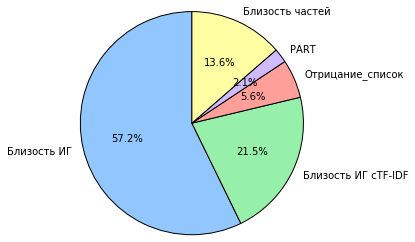

In [182]:
columns_name = ['Близость ИГ', 'Близость ИГ сTF-IDF', 'Отрицание_список', 'PART', 'Близость частей']
plt.style.use('seaborn-pastel')
# list of x locations for plotting
#x_values = list(range(len(importances)))
# Make a bar chart
#plt.pie(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
#plt.xticks(x_values, columns, rotation='vertical')
# Axis labels and title
#plt.ylabel('Вклад'); plt.xlabel('Variable'); plt.title('Variable Importances');

plt.pie(importances, labels=columns_name, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
model2 = LogisticRegression()
columns = ['ig_no_tf', 'ig_tf', 'neg_list', 'part', 'no_tf']
# Train
model2.fit(X_train[columns], y_train)
print(model2)
# make predictions
expected = y_test
predicted = model2.predict(X_test[columns])
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print(f1_score(y_test, model2.predict(X_test[columns]), average='macro'))
f1_score(y_test, model2.predict(X_test[columns]), average='micro')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.79      0.98      0.88       142
          1       0.91      0.45      0.61        66

avg / total       0.83      0.81      0.79       208

[[139   3]
 [ 36  30]]
0.7415161074467068


0.8125

In [193]:
colls2 = ['ig_no_tf', 'ig_tf', 'neg_re', 'no_tf', 'verb_tu']
# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(criterion= 'entropy', 
                               max_depth=50, min_samples_leaf=5, 
                               n_estimators=5)

#columns = ['ig_no_tf', 'ig_tf', 'neg_list', 'part', 'no_tf']
# Train
model.fit(X_train[colls2], y_train)
# Extract single tree
estimator = model.estimators_[4]
print(f1_score(y_test, model.predict(X_test[colls2]), average='macro'))
f1_score(y_test, model.predict(X_test[colls2]), average='micro')

0.7556390977443609


0.8076923076923077

In [155]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree2.dot', 
                feature_names = ['ig_no_tf', 'ig_tf', 'neg_re', 'no_tf', 'verb_tu'],
                class_names = ['contrast', 'comparison'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [194]:
# Get numerical feature importances
importances = list(model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(colls2, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: ig_no_tf             Importance: 0.53
Variable: ig_tf                Importance: 0.22
Variable: no_tf                Importance: 0.17
Variable: neg_re               Importance: 0.07
Variable: verb_tu              Importance: 0.01


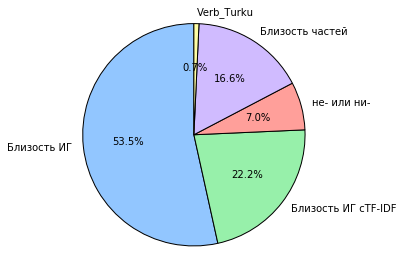

In [195]:
columns_name2 = ['Близость ИГ', 'Близость ИГ сTF-IDF', 'не- или ни-', 'Близость частей', 'Verb_Turku']
plt.style.use('seaborn-pastel')
# list of x locations for plotting
#x_values = list(range(len(importances)))
# Make a bar chart
#plt.pie(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
#plt.xticks(x_values, columns, rotation='vertical')
# Axis labels and title
#plt.ylabel('Вклад'); plt.xlabel('Variable'); plt.title('Variable Importances');

plt.pie(importances, labels=columns_name2, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [143]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
model2 = LogisticRegression()

# Train
model2.fit(X_train[colls2], y_train)
print(model2)
# make predictions
expected = y_test
predicted = model2.predict(X_test[colls2])
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print(f1_score(y_test, model2.predict(X_test[colls2]), average='macro'))
f1_score(y_test, model2.predict(X_test[colls2]), average='micro')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.79      0.97      0.87       142
          1       0.88      0.44      0.59        66

avg / total       0.82      0.80      0.78       208

[[138   4]
 [ 37  29]]
0.7282605232132046


0.8028846153846153

In [136]:
params = {'n_estimators': [5, 10, 50],
       'max_depth': [5, 10, 50, 100, None],
       'min_samples_leaf': [1, 5, 10],
       'criterion': ['gini', 'entropy']}
        
model = GridSearchCV(RandomForestClassifier(), 
                         param_grid=params, 
                         cv=5, 
                         n_jobs=-1, 
                         scoring='f1_macro', verbose=5)

#best_col = ['ig_no_tf', 'ig_tf', 'neg_re','neg_list', 'part', 'verb_tu', 'no_tf']

#base = 0.76

#param_num = [3, 5, 7]
model.fit(X_train[colls3], y_train)

train_f1 = f1_score(y_train, model.predict(X_train[colls3]), average='macro')
test_f1 = f1_score(y_test, model.predict(X_test[colls3]), average='macro')

#print(' <--> '.join(colls3))
print('train', train_f1)
print('test', test_f1)
print('|||||')
print(model.best_params_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   14.1s


train 0.79309201436861
test 0.7272386661671038
|||||
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 10}


[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   20.0s finished


In [204]:
colls3 = ['ig_no_tf', 'ig_tf', 'no_tf']
# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(criterion= 'entropy', 
                               max_depth=10, min_samples_leaf=5, 
                               n_estimators=6)

#columns = ['ig_no_tf', 'ig_tf', 'neg_list', 'part', 'no_tf']
# Train
model.fit(X_train[colls3], y_train)
# Extract single tree
estimator = model.estimators_[5]
print(f1_score(y_test, model.predict(X_test[colls3]), average='macro'))
f1_score(y_test, model.predict(X_test[colls3]), average='micro')

0.7281045751633988


0.7884615384615384

In [145]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree3.dot', 
                feature_names = colls3,
                class_names = ['contrast', 'comparison'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [205]:
# Get numerical feature importances
importances = list(model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(colls3, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: ig_no_tf             Importance: 0.59
Variable: ig_tf                Importance: 0.23
Variable: no_tf                Importance: 0.18


In [144]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
model2 = LogisticRegression()

# Train
model2.fit(X_train[colls3], y_train)
print(model2)
# make predictions
expected = y_test
predicted = model2.predict(X_test[colls3])
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print(f1_score(y_test, model2.predict(X_test[colls3]), average='macro'))
f1_score(y_test, model2.predict(X_test[colls3]), average='micro')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.79      0.98      0.88       142
          1       0.91      0.45      0.61        66

avg / total       0.83      0.81      0.79       208

[[139   3]
 [ 36  30]]
0.7415161074467068


0.8125

In [207]:
colls4 = ['ig_no_tf']
params = {'n_estimators': [5, 10, 50],
       'max_depth': [5, 10, 50, 100, None],
       'min_samples_leaf': [1, 5, 10],
       'criterion': ['gini', 'entropy']}
        
model = GridSearchCV(RandomForestClassifier(), 
                         param_grid=params, 
                         cv=5, 
                         n_jobs=-1, 
                         scoring='f1_macro', verbose=5)

#best_col = ['ig_no_tf', 'ig_tf', 'neg_re','neg_list', 'part', 'verb_tu', 'no_tf']

#base = 0.76

#param_num = [3, 5, 7]
model.fit(X_train[colls4], y_train)

train_f1 = f1_score(y_train, model.predict(X_train[colls4]), average='macro')
test_f1 = f1_score(y_test, model.predict(X_test[colls4]), average='macro')

#print(' <--> '.join(colls3))
print('train', train_f1)
print('test', test_f1)
print('test', f1_score(y_test, model.predict(X_test[colls4]), average='micro'))
print('|||||')
print(model.best_params_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 250 tasks      | elapsed:   11.2s


train 0.7564102564102564
test 0.7415161074467068
test 0.8125
|||||
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 5}


[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   16.1s finished


ig_no_tf <--> ig_tf <--> neg_re <--> no_tf <--> verb_tu
train 0.8146167557932263
test 0.7995268553404012
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 5}

ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> part
train 0.7965479153081458
test 0.7748917748917747
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 5}

ig_no_tf <--> lex <--> neg_re <--> subj_my <--> subj_tu
train 0.7639963182997238
test 0.7770632368703109
|||||
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 1, 'n_estimators': 5}

ig_no_tf <--> neg_list <--> neg_re <--> part <--> with_tf
train 0.7856805816360922
test 0.7704194260485652
|||||
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 5}

ig_no_tf <--> neg_list <--> no_tf <--> subj_my <--> verb_tu
train 0.7823538092107911
test 0.7711771177117712
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 10}

ig_no_tf <--> neg_list <--> no_tf <--> subj_tu <--> verb_tu
train 0.7951496568935239
test 0.7798142939237214
|||||
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 5}

ig_no_tf <--> ig_tf <--> neg_re <--> no_tf <--> part <--> subj_tu <--> with_tf
train 0.8080641373767575
test 0.7721241631162508
|||||
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 10}

ig_no_tf <--> ig_tf <--> lex <--> neg_list <--> neg_re <--> part <--> with_tf
train 0.7913913789716389
test 0.7711771177117712
|||||
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 10}


In [68]:
%%time

res = ['ig_tf', 'lex', 'subj_my', 'verb_tu', 'ig_no_tf', 'neg_list', 'neg_re']

        
params = {'n_estimators': [10],
       'max_depth': [10],
       'min_samples_leaf': [5],
       'criterion': ['gini']} 
        
model = GridSearchCV(RandomForestClassifier(), 
                         param_grid=params, 
                         cv=5, 
                         n_jobs=-1, 
                         scoring='accuracy', verbose=5)




model.fit(X_train[res], y_train)

train_acc = accuracy_score(y_train, model.predict(X_train[res]))
test_acc = accuracy_score(y_test, model.predict(X_test[res]))

#print(' <--> '.join(res))
print('train', train_acc)
print('test', test_acc)
#print('|||||')
#print(model.best_params_)



Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.1s remaining:   10.7s


train 0.8349358974358975
test 0.8125
Wall time: 9.64 s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.0s finished


ig_tf <--> lex <--> subj_my <-->    verb_tu    <--> ig_no_tf <--> neg_list <--> neg_re
train 0.8381410256410257
test 0.8413461538461539
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 10}

ig_tf <--> subj_my <--> subj_tu <-->    verb_tu     <--> ig_no_tf <--> neg_list <--> neg_re
train 0.8381410256410257
test 0.8317307692307693
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 10}

no_tf <--> subj_tu <--> with_tf    verb_tu  <--> ig_no_tf <--> neg_list <--> neg_re
train 0.8493589743589743
test 0.8317307692307693
|||||
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 50}

In [67]:
%%time


#params = {'n_estimators': [5, 10, 50],
#       'max_depth': [5, 10, 50, 100, None],
#       'min_samples_leaf': [1, 5, 10, 50],
#       'criterion': ['gini', 'entropy']}

        
params = {'n_estimators': [5, 10],
       'max_depth': [10],
       'min_samples_leaf': [1, 5],
       'criterion': ['gini']} 
        
model = GridSearchCV(RandomForestClassifier(), 
                         param_grid=params, 
                         cv=5, 
                         n_jobs=-1, 
                         scoring='accuracy', verbose=5)

columns_ = [['ig_no_tf', 'neg_list', 'neg_re', 'verb_tu', 'ig_tf', 'lex', 'subj_my'], 
           ['ig_no_tf', 'neg_list', 'neg_re', 'verb_tu', 'subj_tu', 'subj_my', 'ig_tf'],
           ['ig_no_tf', 'neg_list', 'neg_re', 'verb_tu', 'with_tf', 'subj_tu', 'no_tf']]

for col in columns_:
    columns = col


    model.fit(X_train[columns], y_train)

    train_acc = accuracy_score(y_train, model.predict(X_train[columns]))
    test_acc = accuracy_score(y_test, model.predict(X_test[columns]))

    print(' <--> '.join(columns))
    print('train', train_acc)
    print('test', test_acc)
    print('|||||')
    print(model.best_params_)



Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    3.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.9s finished


ig_no_tf <--> neg_list <--> neg_re <--> verb_tu <--> ig_tf <--> lex <--> subj_my
train 0.8365384615384616
test 0.8221153846153846
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    3.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.6s finished


ig_no_tf <--> neg_list <--> neg_re <--> verb_tu <--> subj_tu <--> subj_my <--> ig_tf
train 0.8317307692307693
test 0.8173076923076923
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 10}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
ig_no_tf <--> neg_list <--> neg_re <--> verb_tu <--> with_tf <--> subj_tu <--> no_tf
train 0.8333333333333334
test 0.8028846153846154
|||||
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 10}
Wall time: 12.3 s


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    3.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.6s finished


In [51]:
%%time


#params = {'n_estimators': [5, 10, 50],
#       'max_depth': [5, 10, 50, 100, None],
#       'min_samples_leaf': [1, 5, 10, 50],
#       'criterion': ['gini', 'entropy']}

        
params = {'n_estimators': [50, 100, 200],
       'max_depth': [50, 100, None],
       'min_samples_leaf': [10, 50, 100, 200],
       'criterion': ['gini', 'entropy']} 
        
model = GridSearchCV(RandomForestClassifier(), 
                         param_grid=params, 
                         cv=5, 
                         n_jobs=-1, 
                         scoring='accuracy', verbose=5)

columns__sh = ['ig_no_tf','lex','neg_list','neg_re','no_tf','part','subj_my','subj_tu','verb_tu','with_tf']

base = 0.82

param_num = [8, 9, 10]
for num in param_num:
    for i in itertools.combinations(columns__sh, num):
        columns = list(i)


        model.fit(X_train[columns], y_train)

        train_acc = accuracy_score(y_train, model.predict(X_train[columns]))
        test_acc = accuracy_score(y_test, model.predict(X_test[columns]))
        if test_acc > base:

            print(' <--> '.join(columns))
            print('train', train_acc)
            print('test', test_acc)
            print('|||||')



Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 516 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   20.4s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 516 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.7s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 517 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 593 out of 600 | elapsed:   19.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   20.2s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 517 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 593 out of 600 | elapsed:   19.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.7s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 516 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   20.6s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 251 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 503 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 593 out of 600 | elapsed:   22.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   22.5s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 517 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 593 out of 600 | elapsed:   19.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   20.0s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 517 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 593 out of 600 | elapsed:   19.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   20.2s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 516 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   20.3s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 516 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   20.1s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   21.0s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 517 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 593 out of 600 | elapsed:   21.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   22.0s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.8s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.5s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 517 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 593 out of 600 | elapsed:   23.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   23.2s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   18.9s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   23.0s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   20.0s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 517 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 593 out of 600 | elapsed:   19.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   20.1s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 517 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 593 out of 600 | elapsed:   19.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.5s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.0s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.2s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.6s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   20.3s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 517 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 593 out of 600 | elapsed:   19.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.9s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.9s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   21.1s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.6s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.2s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 517 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 593 out of 600 | elapsed:   19.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.8s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.8s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.6s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.6s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.0s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 517 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 593 out of 600 | elapsed:   19.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.5s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.5s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.1s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.9s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.6s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 119 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 479 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.1s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.4s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   23.0s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 517 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 593 out of 600 | elapsed:   20.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   20.4s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 119 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 479 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.5s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.8s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 517 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 593 out of 600 | elapsed:   19.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   20.2s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.9s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.9s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.8s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.8s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.3s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 517 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 593 out of 600 | elapsed:   19.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.8s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.9s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   20.3s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.7s finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   20.1s finished


Wall time: 19min 6s


In [31]:
from sklearn.metrics.pairwise import cosine_distances

In [169]:
#res_3 = pd.DataFrame()

In [136]:
def get_dicstance(vec1, vec2):
    return cosine_distances(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]

In [170]:
#res_3['no_tf'] = [get_dicstance(X_text_1_w2v_f[i], v) for i, v in enumerate(X_text_2_w2v_f)]

In [171]:
#res_3['with_tf'] = [get_dicstance(X_text_1_w2v_tf_f[i], v) for i, v in enumerate(X_text_2_w2v_tf_f)]

In [18]:
res_3 = pd.read_csv('full_distance.csv')

In [19]:
res_3.head()

no_tf   with_tf
0  0.094875  0.089050
1  0.617450  0.503783
2  0.075453  0.114287
3  0.597002  0.615182
4  0.391545  0.517879

In [69]:
#res_3 = pd.DataFrame()

In [34]:
#res_3 = [get_dicstance(X_text_1_w2v_comp[i], v) for i, v in enumerate(X_text_2_w2v_comp)]

In [88]:
len(res_3['no_tf'])

832

In [36]:
contr = []
cons = []
comp = []

contr_tf = []
cons_tf = []
comp_tf = []


In [37]:
for ind, rel in enumerate(full['category_id']):
    try:
        if 'Contrast' in rel:
            contr.append(res_3['no_tf'][ind])
        elif 'Concession' in rel:
            cons.append(res_3['no_tf'][ind])
        elif 'comparison' in rel:
            comp.append(res_3['no_tf'][ind])
    except:
        break 


In [38]:
for ind, rel in enumerate(full['category_id']):
    try:
        if 'Contrast' in rel:
            contr_tf.append(res_3['with_tf'][ind])
        elif 'Concession' in rel:
            cons_tf.append(res_3['with_tf'][ind])
        elif 'comparison' in rel:
            comp_tf.append(res_3['with_tf'][ind])
    except:
        break 


In [195]:
len(cons)

134

In [196]:
l_res = list(res_3['no_tf'])

In [178]:
cons_high=0
for el in cons:
    if el >= 0.6:
        cons_high += 1
cons_high

58

In [39]:
contr_high=0
for el in contr:
    if el >= 0.5:
        contr_high += 1
contr_high

230

In [40]:
comp_high=0
for el in comp:
    if el >= 0.5:
        comp_high += 1
comp_high

82

In [41]:
print(230/569)
82/263

0.40421792618629176


0.311787072243346

In [42]:
table = [ [ 230, 339 ], [ 82, 181 ] ]

In [45]:
chi2, prob, df, expected = scipy.stats.chi2_contingency(table)

output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"

print(output.format( chi2, df, prob))

print(expected)

test Statistics: 6.167987330183699
degrees of freedom: 1
p-value: 0.013008251814112769

[[213.375 355.625]
 [ 98.625 164.375]]


In [187]:
contr_high_tf=0
for el in contr_tf:
    if el >= 0.6:
        contr_high_tf += 1
contr_high_tf

201

In [188]:
comp_high_tf=0
for el in comp_tf:
    if el >= 0.6:
        comp_high_tf += 1
comp_high_tf

63

In [189]:
print(201/569)
63/263

0.3532513181019332


0.23954372623574144

In [190]:
table = [ [ 201, 368 ], [ 63, 200 ] ]

In [191]:
chi2, prob, df, expected = scipy.stats.chi2_contingency(table)

output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"

print(output.format( chi2, df, prob))

print(expected)

test Statistics: 10.216901934942237
degrees of freedom: 1
p-value: 0.0013915941168805078

[[180.54807692 388.45192308]
 [ 83.45192308 179.54807692]]


In [198]:
print(full['first_norm'][867])
full['second_norm'][867]

частность русский язык вернуться слово губерния губернатор департамент муниципалитет т.д


'казаться ранее утратить'

In [199]:
len(contr)

569

In [200]:
for el in contr:
    if el >= 1.0:
        print(el, l_res.index(el))

1.3191095501964234 301
1.1636259416701051 306
1.1029427658327573 307
1.0150951104049184 328
1.013143251154407 350
1.0649705562708092 383
1.02958303081074 386
1.2421872145483377 387
1.0804336976973772 413
1.0169708267032962 417
1.0 167
1.0278654116602015 725
1.0845162046090517 876


In [201]:
print(full['first_norm'][417])
full['second_norm'][417]

нынешний валютный резерв россия большой


'намного'

In [202]:
len(comp)

263

In [203]:
for el in comp:
    if el >= 1.0:
        print(el, l_res.index(el))

1.0168760929569072 9
1.030290708206139 137
1.0 167
1.0176317826299153 238
1.0053500716730317 241
1.0680214182410175 251
1.1037377997334619 252
1.0162639960419677 260


In [206]:
print(full['first_norm'][238])
full['second_norm'][238]

контролировать ситуация страна больший степень


'другой новое арабский лидер такой король иордания абдула король марокко мухамед'

In [46]:
for ind, rel in enumerate(full['category_id']):
    try:
        if 'Contrast' in rel:
            contr_tf.append(res_3['with_tf'][ind])
        elif 'Concession' in rel:
            cons_tf.append(res_3['with_tf'][ind])
        elif 'comparison' in rel:
            comp_tf.append(res_3['with_tf'][ind])
    except:
        break 


In [80]:
from matplotlib import pyplot as plt

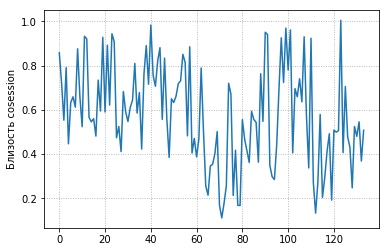

In [208]:
plt.gca().grid(True)

gridlines = plt.gca().get_xgridlines() + plt.gca().get_ygridlines()

line_width = 0.9

for line in gridlines:
    line.set_linestyle(':')
    line.set_linewidth(line_width)

plt.plot(cons)
#plt.scatter(0.8)
plt.ylabel('Близость cosession')
plt.show()

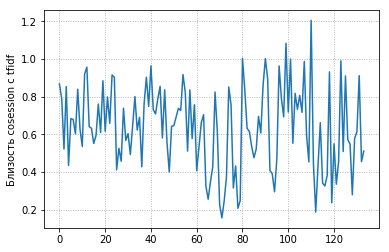

In [209]:
plt.gca().grid(True)

gridlines = plt.gca().get_xgridlines() + plt.gca().get_ygridlines()

line_width = 0.9

for line in gridlines:
    line.set_linestyle(':')
    line.set_linewidth(line_width)

plt.plot(cons_tf)
plt.ylabel('Близость cosession c tfidf')
plt.show()

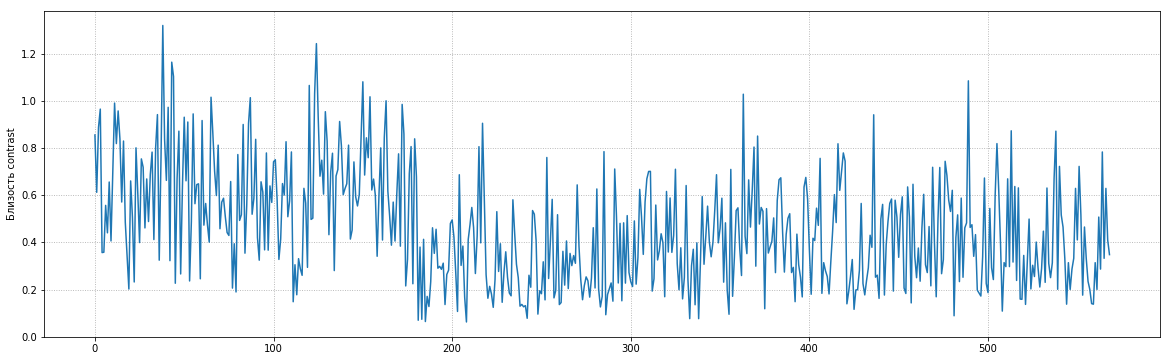

In [210]:
figsize = (20,6)

fig = plt.figure(figsize=figsize, frameon=True)
plt.gca().grid(True)

gridlines = plt.gca().get_xgridlines() + plt.gca().get_ygridlines()

line_width = 0.9

for line in gridlines:
    line.set_linestyle(':')
    line.set_linewidth(line_width)


plt.plot(contr)
plt.ylabel('Близость contrast')
plt.show()

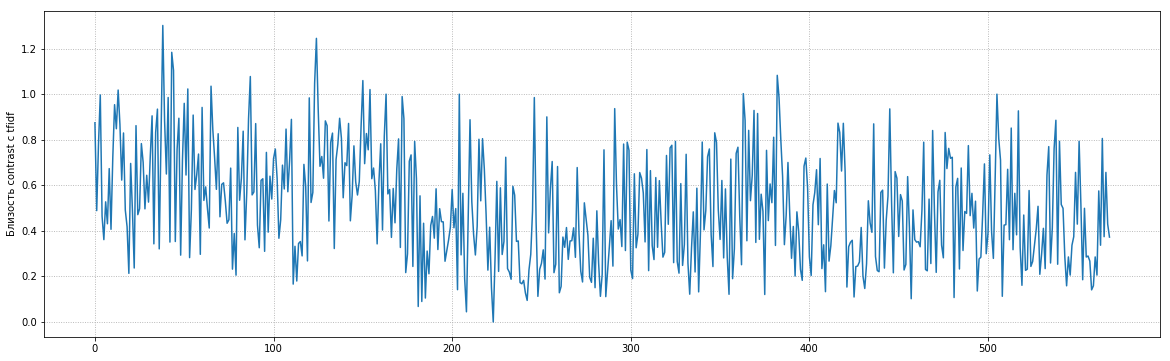

In [211]:
figsize = (20,6)

fig = plt.figure(figsize=figsize, frameon=True)

plt.gca().grid(True)

gridlines = plt.gca().get_xgridlines() + plt.gca().get_ygridlines()

line_width = 0.9

for line in gridlines:
    line.set_linestyle(':')
    line.set_linewidth(line_width)

plt.plot(contr_tf)
plt.ylabel('Близость contrast c tfidf')
plt.show()

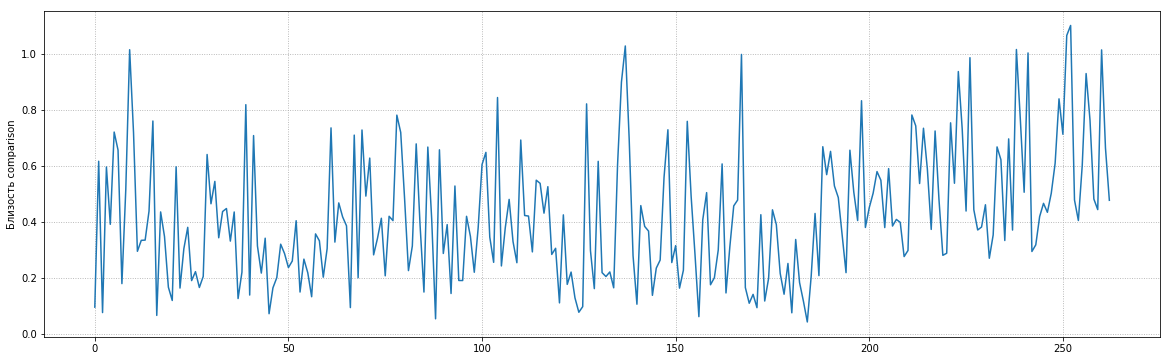

In [212]:
figsize = (20,6)

fig = plt.figure(figsize=figsize, frameon=True)
plt.gca().grid(True)

gridlines = plt.gca().get_xgridlines() + plt.gca().get_ygridlines()

line_width = 0.9

for line in gridlines:
    line.set_linestyle(':')
    line.set_linewidth(line_width)


plt.plot(comp)
plt.ylabel('Близость comparison')
plt.show()

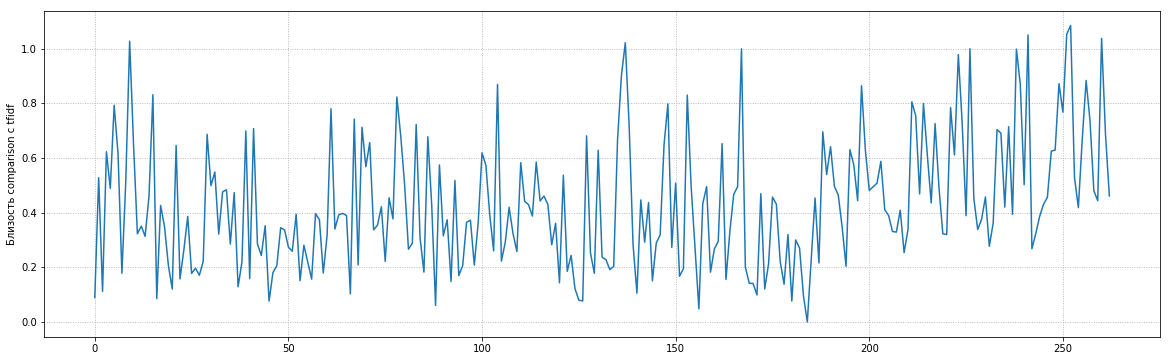

In [213]:
figsize = (20,6)

fig = plt.figure(figsize=figsize, frameon=True)

plt.gca().grid(True)

gridlines = plt.gca().get_xgridlines() + plt.gca().get_ygridlines()

line_width = 0.9

for line in gridlines:
    line.set_linestyle(':')
    line.set_linewidth(line_width)

plt.plot(comp_tf)
plt.ylabel('Близость comparison c tfidf')
plt.show()

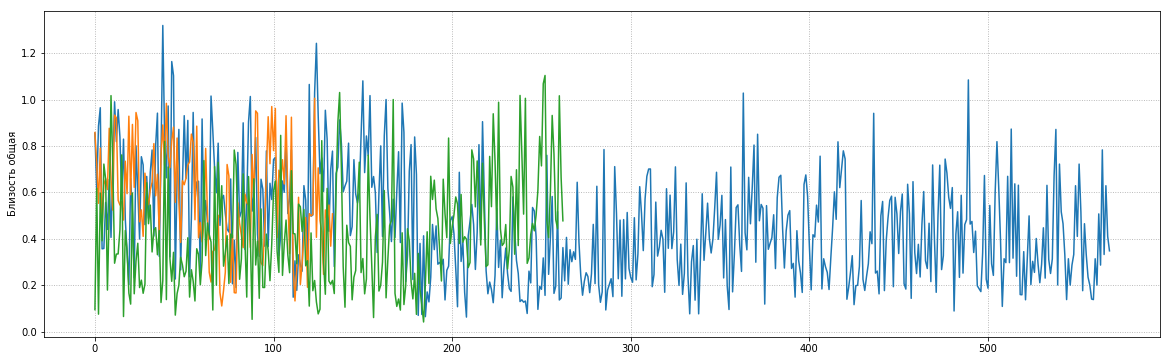

In [214]:
figsize = (20,6)

fig = plt.figure(figsize=figsize, frameon=True) 

plt.gca().grid(True)

gridlines = plt.gca().get_xgridlines() + plt.gca().get_ygridlines()

line_width = 0.9

for line in gridlines:
    line.set_linestyle(':')
    line.set_linewidth(line_width)


plt.plot(contr)
plt.plot(cons)
plt.plot(comp)
plt.ylabel('Близость общая')
plt.show()

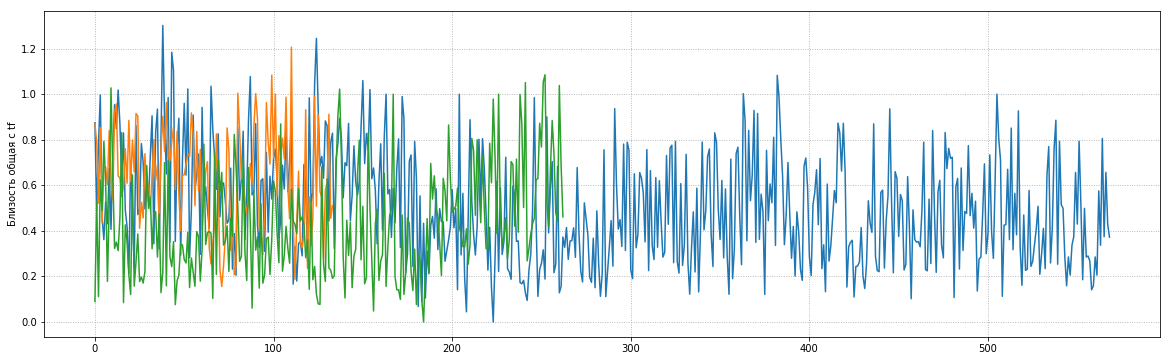

In [215]:
figsize = (20,6)

fig = plt.figure(figsize=figsize, frameon=True) 

plt.gca().grid(True)

gridlines = plt.gca().get_xgridlines() + plt.gca().get_ygridlines()

line_width = 0.9

for line in gridlines:
    line.set_linestyle(':')
    line.set_linewidth(line_width)


plt.plot(contr_tf)
plt.plot(cons_tf)
plt.plot(comp_tf)
plt.ylabel('Близость общая c tf')
plt.show()

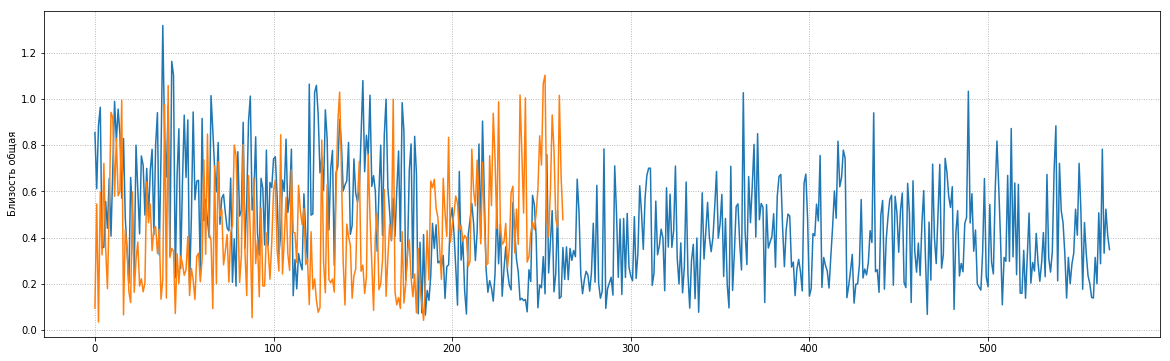

In [109]:
figsize = (20,6)

fig = plt.figure(figsize=figsize, frameon=True) 

plt.gca().grid(True)

gridlines = plt.gca().get_xgridlines() + plt.gca().get_ygridlines()

line_width = 0.9

for line in gridlines:
    line.set_linestyle(':')
    line.set_linewidth(line_width)


plt.plot(contr)
#plt.plot(cons)
plt.plot(comp)
plt.ylabel('Близость общая')
plt.show()

In [216]:
print('Среднее contrast')
np.median(np.array(contr)) 

Среднее contrast


0.4253150829630802

In [252]:
al_1 = 0
colw = 0
for el in contr:
    if el < 1.0:
        al_1 += el
        colw += 1
al_1/colw

0.44487012968207584

In [217]:
print('Среднее consession')
np.median(np.array(cons))

Среднее consession


0.5590607492795983

In [253]:
al_2 = 0
colw1 = 0
for el in cons:
    if el < 1.0:
        al_2 += el
        colw1 += 1
al_2/colw1

0.5745906594115121

In [218]:
print('Среднее comparison')
np.median(np.array(comp))

Среднее comparison


0.38817580015860065

In [254]:
al_3 = 0
colw2 = 0
for el in comp:
    if el < 1.0:
        al_3 += el
        colw2 += 1
al_3/colw2

0.4019780377759483

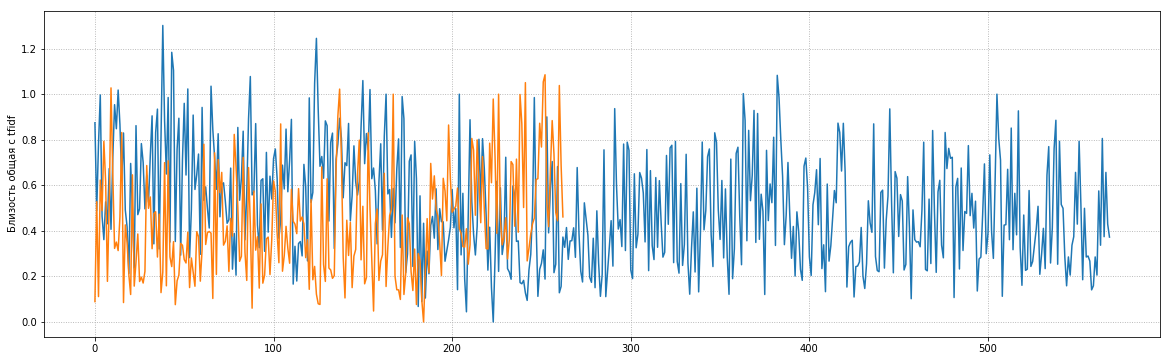

In [219]:
figsize = (20,6)

fig = plt.figure(figsize=figsize, frameon=True) 

plt.gca().grid(True)

gridlines = plt.gca().get_xgridlines() + plt.gca().get_ygridlines()

line_width = 0.9

for line in gridlines:
    line.set_linestyle(':')
    line.set_linewidth(line_width)


plt.plot(contr_tf)
plt.plot(comp_tf)
plt.ylabel('Близость общая c tfidf')
plt.show()

In [220]:
print('Среднее contrast c tf')
np.median(np.array(contr_tf))

Среднее contrast c tf


0.4848043370364674

In [255]:
al_4 = 0
colw3 = 0
for el in contr_tf:
    if el < 1.0:
        al_4 += el
        colw3 += 1
al_4/colw3

0.49152842267182656

In [221]:
print('Среднее consession c tf')
np.median(np.array(cons_tf))

Среднее consession c tf


0.6299238297318867

In [257]:
al_5 = 0
colw4 = 0
for el in cons_tf:
    if el < 1.0:
        al_5 += el
        colw4 += 1
al_5/colw4

0.617825245269232

In [222]:
print('Среднее comparison c tf')
np.median(np.array(comp_tf))

Среднее comparison c tf


0.39221107923237797

In [258]:
al_6 = 0
colw5 = 0
for el in comp_tf:
    if el < 1.0:
        al_6 += el
        colw5 += 1
al_6/colw5

0.41088910923793537

In [226]:
mark_contr = pd.DataFrame()
mark_cons = pd.DataFrame()
mark_comp = pd.DataFrame()

m_contr = []
m_cons = []
m_comp = []
for ind, rel in enumerate(full['category_id']):
    try:
        if 'Contrast' in rel:
            m_contr.append(full['маркер'][ind])
        elif 'Concession' in rel:
            m_cons.append(full['маркер'][ind])
        elif 'comparison' in rel:
            m_comp.append(full['маркер'][ind])
    except:
        break

mark_contr['mark'] = m_contr
mark_cons['mark'] = m_cons
mark_comp['mark'] = m_comp

In [227]:
mark_contr['mark'].value_counts()

но                               142
однако                           133
no marker                         76
а                                 51
не ... а                          30
же                                14
тем не менее                      12
если ... то                        9
в то время как                     7
с другой стороны                   6
напротив                           5
в противном случае                 5
тогда как                          5
хотя                               5
в то же время                      5
или                                4
вместо X                           4
несмотря на X                      4
не ... но                          3
если... то                         3
в отличие от X                     3
впрочем                            3
либо                               3
в одной... в другой                2
с одной стороны ... с другой       2
правда                             2
а вот                              2
н

In [228]:
mark_cons['mark'].value_counts()

хотя               45
несмотря на X      42
no marker          19
тем не менее        4
даже если           3
какой бы ни         3
даже                2
независимо от X     2
но                  2
сколько ни          1
правда              1
хоть и              1
лишь                1
если и ... то       1
впрочем             1
и хотя              1
а                   1
как бы ни           1
хотя и              1
вопреки X           1
пусть и             1
Name: mark, dtype: int64

In [229]:
mark_comp['mark'].value_counts()

nd                                         44
а                                          31
же                                         15
в то время как                             11
если... то                                  9
в отличие от X                              7
чем… тем                                    6
nd                                          5
как… так и                                  4
с одной стороны... с другой стороны         4
тогда как                                   4
и                                           4
ср.                                         3
также                                       3
а вот                                       3
аналогичный                                 3
отличаться                                  2
как                                         2
такой же                                    2
в свою очередь                              2
но                                          2
в то же время                     

In [97]:
data_rel_comp['mark'].value_counts()

nd                                         44
а                                          29
же                                         15
в то время как                             11
если... то                                  9
в отличие от X                              7
чем… тем                                    6
nd                                          5
аналогичный                                 4
тогда как                                   4
и                                           4
а вот                                       3
также                                       3
с одной стороны... с другой стороны         3
ср.                                         3
как… так и                                  3
как                                         2
в то же время                               2
а, параллельные конструкции                 2
в свою очередь                              2
теперь                                      2
в противном случае                

In [237]:
from pymystem3 import Mystem
m = Mystem()

In [344]:
m.analyze('Мама мыла раму и курила окна мужчины. Мальчики красили забор')

[{'analysis': [{'gr': 'S,жен,од=им,ед', 'lex': 'мама'}], 'text': 'Мама'},
 {'text': ' '},
 {'analysis': [{'gr': 'V,несов,пе=прош,ед,изъяв,жен', 'lex': 'мыть'}],
  'text': 'мыла'},
 {'text': ' '},
 {'analysis': [{'gr': 'S,жен,неод=вин,ед', 'lex': 'рама'}], 'text': 'раму'},
 {'text': ' '},
 {'analysis': [{'gr': 'CONJ=', 'lex': 'и'}], 'text': 'и'},
 {'text': ' '},
 {'analysis': [{'gr': 'V,несов,пе=прош,ед,изъяв,жен', 'lex': 'курить'}],
  'text': 'курила'},
 {'text': ' '},
 {'analysis': [{'gr': 'S,сред,неод=(вин,мн|род,ед|им,мн)', 'lex': 'окно'}],
  'text': 'окна'},
 {'text': ' '},
 {'analysis': [{'gr': 'S,муж,од=(род,ед|им,мн)', 'lex': 'мужчина'}],
  'text': 'мужчины'},
 {'text': '. '},
 {'analysis': [{'gr': 'S,муж,од=им,мн', 'lex': 'мальчик'}],
  'text': 'Мальчики'},
 {'text': ' '},
 {'analysis': [{'gr': 'V,несов,пе=прош,мн,изъяв', 'lex': 'красить'}],
  'text': 'красили'},
 {'text': ' '},
 {'analysis': [{'gr': 'S,муж,неод=(вин,ед|им,ед)', 'lex': 'забор'}],
  'text': 'забор'},
 {'text': '

In [ ]:
mark_contr = pd.DataFrame()
mark_cons = pd.DataFrame()
mark_comp = pd.DataFrame()

m_contr = []
m_cons = []
m_comp = []
for ind, rel in enumerate(full['category_id']):
    try:
        if 'Contrast' in rel:
            m_contr.append(full['маркер'][ind])
        elif 'Concession' in rel:
            m_cons.append(full['маркер'][ind])
        elif 'comparison' in rel:
            m_comp.append(full['маркер'][ind])
    except:
        break

mark_contr['mark'] = m_contr
mark_cons['mark'] = m_cons
mark_comp['mark'] = m_comp

In [192]:
contr_all = pd.DataFrame()
cons_all = pd.DataFrame()
comp_all = pd.DataFrame()

contr_m = []
contr_f = []
contr_s = []
contr_full = []

cons_m = []
cons_f = []
cons_s = []
cons_full = []

comp_m = []
comp_f = []
comp_s = []
comp_full = []

for ind, rel in enumerate(full['category_id']):
    try:
        if 'Contrast' in rel:
            contr_m.append(full['маркер'][ind])
            contr_f.append(full['snippet_x'][ind])
            contr_s.append(full['snippet_y'][ind])
            contr_full.append(full['контекст'][ind])

        elif 'Concession' in rel:
            cons_m.append(full['маркер'][ind])
            cons_f.append(full['snippet_x'][ind])
            cons_s.append(full['snippet_y'][ind])
            cons_full.append(full['контекст'][ind])

        elif 'comparison' in rel:
            comp_m.append(full['маркер'][ind])
            comp_f.append(full['snippet_x'][ind])
            comp_s.append(full['snippet_y'][ind])
            comp_full.append(full['контекст'][ind])
            
    except:
        break

#print(len(contr_m), len(contr_f))

contr_all['mark'] = contr_m
contr_all['first'] = contr_f
contr_all['second'] = contr_s
contr_all['full'] = contr_full

cons_all['mark'] = cons_m
cons_all['first'] = cons_f
cons_all['second'] = cons_s
cons_all['full'] = cons_full

comp_all['mark'] = comp_m
comp_all['first'] = comp_f
comp_all['second'] = comp_s
comp_all['full'] = comp_full

#spro


In [243]:
av_s = ['S', 'SPRO']
av_v = ['V', 'VPRO']

In [323]:
count_contr = 0

for ind, part_1 in enumerate(contr_all['first']):
    m_1 = m.analyze(part_1)
    m_2 = m.analyze(contr_all['second'][ind])
    for lem_1 in m_1:
        #print(lem_1)
        if 'analysis' in lem_1 and lem_1['analysis'] != []:
            #gr_1 = lem_1['analysis'][0]
            
            for lem_2 in m_2:
                if 'analysis' in lem_2 and lem_2['analysis'] != []:
                    #gr_2 = lem_2['analysis'][0]
                    
                    if lem_1['analysis'][0]['lex'] == lem_2['analysis'][0]['lex']:
                        if len(lem_1['analysis'][0]['lex']) > 1:
                            gr_1 = lem_1['analysis'][0]['gr'].split(',')
                            gr_2 = lem_2['analysis'][0]['gr'].split(',')
                            #print(gr_1)
                            if gr_1[0] in av_s and gr_2[0] in av_s:

                                if gr_1 == gr_2:
                                    for el in gr_1:
                                        if 'им' in el:
                                            count_contr += 1
                                            print(lem_1['analysis'][0]['lex'])
                                            #print(gr_1,'\n',gr_2)
                                            print('-------------')

сша
-------------
млрд
-------------
млрд
-------------
они
-------------
кольцо
-------------
км
-------------
км
-------------
край
-------------
кольцо
-------------
звезда
-------------
срок
-------------
право
-------------
мосфильм
-------------
ленфильм
-------------
произведение
-------------
лицензия
-------------
общество
-------------
аналогия
-------------
срок
-------------
россия
-------------
россия
-------------
вто
-------------
вопрос
-------------
мероприятие
-------------
управление
-------------
риск
-------------
марка
-------------
заявление
-------------
источник
-------------
план
-------------
план
-------------
косово
-------------
форма
-------------
адаптация
-------------
течение
-------------
жизнь
-------------
выполнение
-------------
изделие
-------------
состояние
-------------
система
-------------
она
-------------
роэс
-------------
роэс
-------------
роэс
-------------
пэвм
-------------
пэвм
-------------
пэвм
-------------
пэвм
-------------
пэв

In [325]:
count_contr/len(contr_all['first'])

0.562390158172232

In [326]:
count_contr

320

In [327]:
len(contr_all['first']) - count_contr

249

In [52]:
for ind, part_1 in enumerate(cons_all['first']):
    m_1 = m.analyze(part_1)
    m_2 = m.analyze(contr_all['second'][ind])
    for lem_1 in m_1:
        #print(lem_1)
        if 'analysis' in lem_1 and lem_1['analysis'] != []:
            #gr_1 = lem_1['analysis'][0]
            
            for lem_2 in m_2:
                if 'analysis' in lem_2 and lem_2['analysis'] != []:
                    #gr_2 = lem_2['analysis'][0]
                    
                    if lem_1['analysis'][0]['lex'] == lem_2['analysis'][0]['lex']:
                        gr_1 = lem_1['analysis'][0]['gr'].split(',')
                        gr_2 = lem_2['analysis'][0]['gr'].split(',')
                        #print(gr_1)
                        if gr_1[0] in av_s and gr_2[0] in av_s:
                            
                            if gr_1 == gr_2:
                                for el in gr_1:
                                    if 'им' in el:
                                        print(lem_1['analysis'][0]['lex'])
                                        #print(gr_1,'\n',gr_2)
                                        print('-------------')

In [248]:
count_comp = 0

for ind, part_1 in enumerate(comp_all['first']):
    m_1 = m.analyze(part_1)
    m_2 = m.analyze(comp_all['second'][ind])
    for lem_1 in m_1:
        #print(lem_1)
        if 'analysis' in lem_1 and lem_1['analysis'] != []:
            #gr_1 = lem_1['analysis'][0]
            
            for lem_2 in m_2:
                if 'analysis' in lem_2 and lem_2['analysis'] != []:
                    #gr_2 = lem_2['analysis'][0]
                    
                    if lem_1['analysis'][0]['lex'] == lem_2['analysis'][0]['lex']:
                        if len(lem_1['analysis'][0]['lex']) > 1:
                            gr_1 = lem_1['analysis'][0]['gr'].split(',')
                            gr_2 = lem_2['analysis'][0]['gr'].split(',')
                            #print(gr_1)
                            if gr_1[0] in av_s and gr_2[0] in av_s:

                                if gr_1 == gr_2:
                                    for el in gr_1:
                                        if 'им' in el:
                                            count_comp+=1
                                            print(lem_1['analysis'][0]['lex'])
                                            #print(gr_1,'\n',gr_2)
                                            print('-------------')
                                            break

определение
-------------
термин
-------------
единица
-------------
вариант
-------------
переводчик
-------------
переводчик
-------------
ценность
-------------
речь
-------------
характер
-------------
отец
-------------
сын
-------------
ребенок
-------------
ребенок
-------------
мать
-------------
мать
-------------
мать
-------------
привлекательность
-------------
сексуальность
-------------
женственность
-------------
чувственность
-------------
элегантность
-------------
уникальность
-------------
литература
-------------
правило
-------------
предложение
-------------
цель
-------------
высказывание
-------------
цель
-------------
высказывание
-------------
предложение
-------------
высказывание
-------------
знак
-------------
знак
-------------
конструкция
-------------
конструкция
-------------
объект
-------------
точка
-------------
зрение
-------------
объект
-------------
вампир
-------------
объект
-------------
объект
-------------
отсылка
-------------
группа
---

In [250]:
count_comp/len(comp_all['first'])

0.9619771863117871

In [319]:
count_comp

253

In [320]:
len(comp_all['first'])-count_comp

10

## считаю глаголы по инфинитиву

In [267]:
countv_contr = 0

for ind, part_1 in enumerate(contr_all['first']):
    m_1 = m.analyze(part_1)
    m_2 = m.analyze(contr_all['second'][ind])
    for lem_1 in m_1:
        #print(lem_1)
        if 'analysis' in lem_1 and lem_1['analysis'] != []:
            #gr_1 = lem_1['analysis'][0]
            
            for lem_2 in m_2:
                if 'analysis' in lem_2 and lem_2['analysis'] != []:
                    #gr_2 = lem_2['analysis'][0]
                    
                    if lem_1['analysis'][0]['lex'] == lem_2['analysis'][0]['lex']:
                        #print(lem_1['analysis'][0]['lex'])
                        if len(lem_1['analysis'][0]['lex']) > 1:
                            gr_1 = lem_1['analysis'][0]['gr'].split(',')
                            gr_2 = lem_2['analysis'][0]['gr'].split(',')
                            #print(gr_1)
                            if gr_1[0] in av_v and gr_2[0] in av_v:
                                print(lem_1['analysis'][0]['lex'])
                                #print(gr_2)
                                #if gr_1 == gr_2:
                                    #for el in gr_1:
                                        #if 'им' in el:
                                countv_contr += 1
                                            #print(lem_1['analysis'][0]['lex'])
                                            #print(gr_1,'\n',gr_2)
                                print('-------------')

быть
-------------
быть
-------------
быть
-------------
быть
-------------
исходить
-------------
рассчитывать
-------------
приспосабливаться
-------------
быть
-------------
хотеть
-------------
оставаться
-------------
доминировать
-------------
возникать
-------------
говорить
-------------
давать
-------------
быть
-------------
быть
-------------
быть
-------------
мочь
-------------
возникать
-------------
чувствовать
-------------
встречать
-------------
становиться
-------------
характеризовать
-------------
называться
-------------
выполнять
-------------
требовать
-------------
построить
-------------
построить
-------------
следовать
-------------
быть
-------------
являться
-------------
быть
-------------
соответствовать
-------------
оказываться
-------------
передавать
-------------
вычислять
-------------
существовать
-------------
выполняться
-------------
мочь
-------------
мочь
-------------
позволять
-------------
быть
-------------
быть
-------------
вести
------

In [268]:
countv_contr/len(contr_all['first'])

0.19156414762741653

In [310]:
countv_contr

109

In [311]:
len(contr_all['first']) - countv_contr

460

In [269]:
countv_comp = 0

for ind, part_1 in enumerate(comp_all['first']):
    m_1 = m.analyze(part_1)
    m_2 = m.analyze(comp_all['second'][ind])
    for lem_1 in m_1:
        #print(lem_1)
        if 'analysis' in lem_1 and lem_1['analysis'] != []:
            #gr_1 = lem_1['analysis'][0]
            
            for lem_2 in m_2:
                if 'analysis' in lem_2 and lem_2['analysis'] != []:
                    #gr_2 = lem_2['analysis'][0]
                    
                    if lem_1['analysis'][0]['lex'] == lem_2['analysis'][0]['lex']:
                        #print(lem_1['analysis'][0]['lex'])
                        if len(lem_1['analysis'][0]['lex']) > 1:
                            gr_1 = lem_1['analysis'][0]['gr'].split(',')
                            gr_2 = lem_2['analysis'][0]['gr'].split(',')
                            #print(gr_1)
                            if gr_1[0] in av_v and gr_2[0] in av_v:
                                print(lem_1['analysis'][0]['lex'])
                                #print(gr_2)
                                #if gr_1 == gr_2:
                                    #for el in gr_1:
                                        #if 'им' in el:
                                countv_comp += 1
                                            #print(lem_1['analysis'][0]['lex'])
                                            #print(gr_1,'\n',gr_2)
                                print('-------------')

являться
-------------
учить
-------------
учить
-------------
учить
-------------
учить
-------------
учить
-------------
учить
-------------
озвучивать
-------------
выглядеть
-------------
жить
-------------
получать
-------------
вести
-------------
передавать
-------------
актуализировать
-------------
пойти
-------------
актуализировать
-------------
расходиться
-------------
оценивать
-------------
быть
-------------
быть
-------------
делать
-------------
являться
-------------
являться
-------------
использоваться
-------------
решаться
-------------
становиться
-------------
называться
-------------
позволять
-------------
представлять
-------------
хранить
-------------
совпадать
-------------
совпадать
-------------
являться
-------------
быть
-------------
изменять
-------------
смочь
-------------
принадлежать
-------------
принадлежать
-------------
принадлежать
-------------
принадлежать
-------------
принадлежать
-------------
принадлежать
-------------
принадлежать
--

In [270]:
countv_comp/len(comp_all['first'])

0.20152091254752852

In [307]:
countv_comp

53

In [308]:
len(comp_all['first']) - countv_comp

210

## считаем лексические совпадения

In [272]:
contr_all['first_norm'] = contr_all['first'].apply(normalize)
contr_all['second_norm'] = contr_all['second'].apply(normalize)
contr_all.head()

mark                                              first  \
0       впрочем  ##### Этот настрой распространился не только н...   
1     не ... но  ##### То есть речь идет отнюдь не о мастер-кла...   
2  тем не менее  ##### Тем, кто живет в России, трудно представ...   
3             а  от которых в Москве за пять минут не осталось ...   
4        однако  сдерживающим фактором по отношению к инфляции ...   

                                              second  \
0  Впрочем, им зачастую уже и гость не интересен,...   
1  но напротив, если говорить совсем прямо, о том...   
2  Тем не менее экономика наших соседей идет ко д...   
3  а если бы это был музей, то сделали бы то же с...   
4  – однако это ведет к безработице и «остыванию»...   

                                                full  \
0  ##### Этот настрой распространился не только н...   
1  ##### То есть речь идет отнюдь не о мастер-кла...   
2  ##### Тем, кто живет в России, трудно представ...   
3  ##### Если говорить о строительстве, то в Риге...   
4  ##### По мнению аналитиков из «Деловых вестей»...   

                                          first_norm  \
0  настрой распространиться политический сфера ос...   
1            речь идти отнюдь мастер-класс злоязычие   
2    жить россия трудно представить плохо друг место   
3          который москва пять минута остаться щепка   
4  сдерживать фактор отношение инфляция выступать...   

                                         second_norm  
0  зачастую гость интересный нужный лишь повод по...  
1  напротив говорить прямо злословить понапрасну ...  
2  менее экономика наш сосед идти к дно кредитный...  
3              это музей сделать самый двойной бетон  
4   однако это вести безработица остывание экономика

In [298]:
countlex_contr = 0

for ind, part_1 in enumerate(contr_all['first_norm']):
    part_1 = part_1.split()
    part_2 = contr_all['second_norm'][ind].split()
    prev = countlex_contr
    for lem_1 in part_1:
        for lem_2 in part_2:
            if lem_1 == lem_2:
                print(lem_1)
                countlex_contr += 1
                print('-------------')
                break
        if prev < countlex_contr:
            break
                        

сша
-------------
миллиард
-------------
война
-------------
себя
-------------
нептун
-------------
кольцо
-------------
край
-------------
тусклый
-------------
кольцо
-------------
1797
-------------
провести
-------------
который
-------------
миллион
-------------
доллар
-------------
день
-------------
деньга
-------------
срок
-------------
мосфильм
-------------
ленфильм
-------------
фильм
-------------
произведение
-------------
фонд
-------------
афганистан
-------------
бросить
-------------
медведев
-------------
блог
-------------
несколько
-------------
родитель
-------------
работа
-------------
аналогия
-------------
один
-------------
тот
-------------
переговоры
-------------
абхаз
-------------
волна
-------------
известный
-------------
срок
-------------
всемирный
-------------
россия
-------------
вступление
-------------
хотеть
-------------
оставаться
-------------
неудача
-------------
международный
-------------
обряд
-------------
саммит
-------------
потенц

In [275]:
countlex_contr/len(contr_all['first_norm'])

2.492091388400703

In [299]:
countlex_contr/len(contr_all['first_norm'])

0.5817223198594025

In [300]:
countlex_contr

331

In [312]:
len(contr_all['first_norm']) - countlex_contr

238

In [282]:
comp_all['first_norm'] = comp_all['first'].apply(normalize)
comp_all['second_norm'] = comp_all['second'].apply(normalize)
comp_all.head()

mark  \
0                                      NaN   
1                           в то время как   
2         первый вариант... второй вариант   
3                           в то время как   
4  в первом варианте... в других вариантах   

                                               first  \
0  Определение С. В. Гринева является примером ла...   
1  Так, например, слова: referee I судья или bask...   
2  Второй вариант перевода: Eine Fliege - klein u...   
3  При этом французский переводчик сохранил рифму...   
4  В первом варианте происходит транспозиция обра...   

                                              second  \
0  В. М. Лейчик давал следующее определение терми...   
1  в то время как flank I фланг на поле, draw I с...   
2  Первый вариант перевода: Es fliegt die Fliege ...   
3  в то время как немецкий переводчик ограничился...   
4  в других вариантах - либо золотым отсветом - a...   

                                                full  \
0  Определение С. В. Гринева является примером ла...   
1  Так, например, слова: referee I судья или bask...   
2  Второй вариант перевода: Eine Fliege - klein u...   
3  При этом французский переводчик сохранил рифму...   
4  В первом варианте происходит транспозиция обра...   

                                          first_norm  \
0  определение гринев являться пример лаконичный ...   
1  например слово судья корзина являться полность...   
2                                два вариант перевод   
3  французский переводчик сохранить рифма внутри ...   
4  первое вариант происходить транспозиция образ ...   

                                         second_norm  
0  метр лейчик давать следующий определение терми...  
1  время фланг пол сыграть вничью перехват являть...  
2                           один вариант перевод 9 3  
3  время немецкий переводчик ограничиться бола св...  
4  другой вариант либо золотой отсвет либо сверка...

In [286]:
countlex_comp = 0

for ind, part_1 in enumerate(comp_all['first_norm']):
    part_1 = part_1.split()
    part_2 = comp_all['second_norm'][ind].split()
    prev = countlex_comp
    for lem_1 in part_1:
        for lem_2 in part_2:
            if lem_1 == lem_2:
                print(lem_1)
                countlex_comp += 1
                print('-------------')
                break
        if prev < countlex_comp:
            break
                        

определение
-------------
слово
-------------
вариант
-------------
переводчик
-------------
вариант
-------------
10
-------------
ценность
-------------
речь
-------------
характер
-------------
каков
-------------
учить
-------------
вьетнамский
-------------
характер
-------------
матерь
-------------
характерный
-------------
реклама
-------------
текст
-------------
переводный
-------------
правило
-------------
трусца
-------------
компонент
-------------
наш
-------------
объект
-------------
точка
-------------
случай
-------------
объект
-------------
корневой
-------------
один
-------------
это
-------------
перевод
-------------
графический
-------------
язык
-------------
мор
-------------
случай
-------------
который
-------------
жить
-------------
причинный
-------------
компонент
-------------
язык
-------------
компонент
-------------
причинный
-------------
предлог
-------------
статус
-------------
и.ф
-------------
советизм
-------------
снижение
-------------
пут

In [285]:
countlex_comp/len(comp_all['first_norm'])

4.030418250950571

In [287]:
countlex_comp/len(comp_all['first_norm'])

0.7034220532319392

In [301]:
countlex_comp

185

In [313]:
len(comp_all['first_norm']) - countlex_comp

78

In [288]:
countnum_contr_1 = 0
countnum_contr_2 = 0

for ind, part_1 in enumerate(contr_all['first']):
    part_1 = part_1.split()
    part_2 = contr_all['second'][ind].split()
    countnum_contr_1 += len(part_1)
    countnum_contr_2 += len(part_2)
    
                        

In [289]:
countnum_contr_1/len(contr_all['first'])

17.854130052724077

In [290]:
countnum_contr_2/len(contr_all['first'])

22.061511423550087

In [292]:
countnum_comp_1 = 0
countnum_comp_2 = 0

for ind, part_1 in enumerate(comp_all['first']):
    part_1 = part_1.split()
    part_2 = comp_all['second'][ind].split()
    countnum_comp_1 += len(part_1)
    countnum_comp_2 += len(part_2)

In [293]:
countnum_comp_1/len(comp_all['first'])

20.44486692015209

In [294]:
countnum_comp_2/len(comp_all['first'])

20.167300380228138

## тут я решила поиграть в статистику

In [44]:
import scipy

### лексическая совстречаемость

In [314]:
table = [ [ 331, 238 ], [ 185, 78 ] ]

In [315]:
chi2, prob, df, expected = scipy.stats.chi2_contingency(table)

output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"

print(output.format( chi2, df, prob))

print(expected)

test Statistics: 10.798497232400662
degrees of freedom: 1
p-value: 0.001015825233428605

[[352.88942308 216.11057692]
 [163.11057692  99.88942308]]


### совпадение глаголов

In [316]:
table = [ [ 109, 460 ], [ 53, 210 ] ]

In [317]:
chi2, prob, df, expected = scipy.stats.chi2_contingency(table)

output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"

print(output.format( chi2, df, prob))

print(expected)

test Statistics: 0.059084566963397075
degrees of freedom: 1
p-value: 0.8079487136445214

[[110.79086538 458.20913462]
 [ 51.20913462 211.79086538]]


### совпадение субъектов в частях

In [328]:
table = [ [ 320, 249 ], [ 253, 10 ] ]

In [329]:
chi2, prob, df, expected = scipy.stats.chi2_contingency(table)

output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"

print(output.format( chi2, df, prob))

print(expected)

test Statistics: 132.09790785648357
degrees of freedom: 1
p-value: 1.4241909066916322e-30

[[391.87139423 177.12860577]
 [181.12860577  81.87139423]]


In [331]:
matr = pd.DataFrame(table)

### среднее количество слов в половинах

In [341]:
table = [ [ 17.854130052724077, 22.061511423550087 ], [ 20.44486692015209, 20.167300380228138 ] ]

In [342]:
chi2, prob, df, expected = scipy.stats.chi2_contingency(table)

output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"

print(output.format( chi2, df, prob))

print(expected)

test Statistics: 0.07898731975337255
degrees of freedom: 1
p-value: 0.7786744828068713

[[18.98386477 20.93177671]
 [19.3151322  21.2970351 ]]


### попытаюсь вычленить ИГ

In [353]:
from pymystem3 import Mystem
m = Mystem()

In [351]:
m.analyze('форму')

[{'analysis': [{'gr': 'S,жен,неод=вин,ед', 'lex': 'форма'}], 'text': 'форму'},
 {'text': '\n'}]

In [345]:
m.analyze('Мама мыла раму и курила окна мужчины. Мальчики красили забор')

[{'analysis': [{'gr': 'S,жен,од=им,ед', 'lex': 'мама'}], 'text': 'Мама'},
 {'text': ' '},
 {'analysis': [{'gr': 'V,несов,пе=прош,ед,изъяв,жен', 'lex': 'мыть'}],
  'text': 'мыла'},
 {'text': ' '},
 {'analysis': [{'gr': 'S,жен,неод=вин,ед', 'lex': 'рама'}], 'text': 'раму'},
 {'text': ' '},
 {'analysis': [{'gr': 'CONJ=', 'lex': 'и'}], 'text': 'и'},
 {'text': ' '},
 {'analysis': [{'gr': 'V,несов,пе=прош,ед,изъяв,жен', 'lex': 'курить'}],
  'text': 'курила'},
 {'text': ' '},
 {'analysis': [{'gr': 'S,сред,неод=(вин,мн|род,ед|им,мн)', 'lex': 'окно'}],
  'text': 'окна'},
 {'text': ' '},
 {'analysis': [{'gr': 'S,муж,од=(род,ед|им,мн)', 'lex': 'мужчина'}],
  'text': 'мужчины'},
 {'text': '. '},
 {'analysis': [{'gr': 'S,муж,од=им,мн', 'lex': 'мальчик'}],
  'text': 'Мальчики'},
 {'text': ' '},
 {'analysis': [{'gr': 'V,несов,пе=прош,мн,изъяв', 'lex': 'красить'}],
  'text': 'красили'},
 {'text': ' '},
 {'analysis': [{'gr': 'S,муж,неод=(вин,ед|им,ед)', 'lex': 'забор'}],
  'text': 'забор'},
 {'text': '

In [243]:
av_s = ['S', 'SPRO']
av_v = ['V', 'VPRO']

In [ ]:
contr_first = []

In [354]:


for ind, part_1 in enumerate(contr_all['first']):
    m_1 = m.analyze(part_1)
    #m_2 = m.analyze(contr_all['second'][ind])
    is_s = False
    gender_s = ''
    col = ''
    gender_v = ''
    save_lex_s = ''
    save_lex_v = ''
    for lem_1 in m_1:
        #print(lem_1)
        
        if 'analysis' in lem_1 and lem_1['analysis'] != []:
            #gr_1 = lem_1['analysis'][0]
            
            #for lem_2 in m_2:
                #if 'analysis' in lem_2 and lem_2['analysis'] != []:
                    #gr_2 = lem_2['analysis'][0]
                    
                    #if lem_1['analysis'][0]['lex'] == lem_2['analysis'][0]['lex']:
            if len(lem_1['analysis'][0]['lex']) > 1:
                    #gr_1 = lem_1['analysis'][0]['gr'].split(',')
                            #gr_2 = lem_2['analysis'][0]['gr'].split(',')
                            #print(gr_1)
                    if 'S,' in lem_1['analysis'][0]['gr'] or 'SPRO' in lem_1['analysis'][0]['gr']:
                        if 'им,мн' in lem_1['analysis'][0]['gr']:
                            col = 'мн'
                            gender_s = 'no'
                            save_lex_s = lem_1['text']
                            if save_lex_v != '':
                                if gender_s != gender_v:
                                    print(save_lex_s, save_lex_v)
                            
                        elif 'им,ед' in lem_1['analysis'][0]['gr']:
                            col = 'ед'
                            save_lex_s = lem_1['text']
                            if 'муж' in lem_1['analysis'][0]['gr']:
                                gender_s = 'муж'
                            elif 'сред' in lem_1['analysis'][0]['gr']:
                                gender_s = 'сред'
                            elif 'жен' in lem_1['analysis'][0]['gr']:
                                gender_s = 'жен'
                            
                            if save_lex_v != '':
                                if gender_s != gender_v:
                                    print(save_lex_s, save_lex_v)
                        
                        
                    if 'V,' in lem_1['analysis'][0]['gr'] or 'VPRO' in lem_1['analysis'][0]['gr']:
                            if gender_s != '':
                                if col in lem_1['analysis'][0]['gr']:
                                    if gender_s != 'no':
                                        save_lex_v = lem_1['text']
                                    else:
                                        if gender_s in lem_1['analysis'][0]['gr']:
                                            gender_v = gender_s
                                            save_lex_v = lem_1['text']
                            else:
                                save_lex_v = lem_1['text']
                                if 'мн,' in lem_1['analysis'][0]['gr']:
                                    col = 'мн'
                                    gender_v = 'no'
                                elif 'ед,' in lem_1['analysis'][0]['gr']:
                                    col = 'ед'
                                    if 'муж' in lem_1['analysis'][0]['gr']:
                                        gender_v = 'муж'
                                    elif 'сред' in lem_1['analysis'][0]['gr']:
                                        gender_v = 'сред'
                                    elif 'жен' in lem_1['analysis'][0]['gr']:
                                        gender_v = 'жен'
                                        

    print(save_lex_s, save_lex_v)
    #print(gr_1,'\n',gr_2)
    print('-------------')

искусство распространился
искусство распространился
-------------
речь есть
злоязычия идет
-------------
России живет
России живет
-------------
щепки осталось
щепки осталось
-------------
снижение сдерживающим
потребления сдерживающим
-------------
рынки заставила
рынки заставила
-------------
электроэнергии 
-------------
млрд 
-------------
потенциалы 
-------------
войны понесли
-------------
истерика сказать
истерика имела
-------------
мнения стала
мнения стала
-------------
члены Как
члены Как
-------------
поход было
круиз напоминал
круиз напоминал
-------------
мир 
-------------
очередь бомбила
-------------
 назначенных
-------------
вещества 
-------------
система 
-------------
кольцо имеет
км имеет
км имеет
-------------
кольца 
-------------
кольца 
-------------
пыли состоят
-------------
кольца считалось
пара считалось
пара считалось
-------------
общества 
-------------
наблюдения планировала
атмосферы планировала
звезды планировала
звезды планировала
-------------
 б

KeyboardInterrupt: 

In [356]:
!git clone https://github.com/TurkuNLP/Turku-neural-parser-pipeline.git

Cloning into 'Turku-neural-parser-pipeline'...


In [4]:
print('echo "Я ем пельмени" | ./runturku.sh\necho "Привет, у меня все работает" | ./runturku.sh\n')

echo "Привет, у меня все работает" | ./runturku.sh
echo "Привет, у меня все работает" | ./runturku.sh



In [96]:
#print()
full_str_comp_second = ''
full_str_contr_second = ''
full_str_contr = ''
full_str_comp = ''
full_str_contr_all = ''
full_str_comp_all = ''
l = 0
k=0
for ind, el in enumerate(full['контекст']):
    try:
        rel = full['category_id'][ind].lower()
        if 'contrast' in rel:
            rel_clean = 'Contrast'
            el = el.strip('#')
            el = el.strip(' ')
            el = re.sub('[\(\)\[\]\{\}]', '', el)
            el = re.sub('[\.!?,–;: ]*?$', '.', el)
            el = re.sub('"', "'", el)
            full_str_contr_all += el + ' $j$j$'
            l+=1

        elif 'comparison' in rel:
            rel_clean = 'comparison'
            el = el.strip('#')
            el = el.strip(' ')
            el = re.sub('[\(\)\[\]\{\}]', '', el)
            el = re.sub('[\.!?,–;: ]*?$', '.', el)
            el = re.sub('"', "'", el)
            full_str_comp_all += el + r' $j$j$'
            k+=1
            
        #el = el.strip('#')
        #filename = 'first_' + rel_clean + '_' + str(ind) + '.conllu'
        #full_str += el + r'$$$'
        #print('"',el, '"  | ./runturku.sh > ', filename, '\n')
    except:
        break
#print('echo "', full_str, '"  | ./runturku.sh > full_first.conllu')

In [94]:
len(full['контекст'])

983

In [97]:
l

181

In [45]:
print('echo "', full_str_contr, '"  | ./runturku.sh > full_first_contr.conllu')

echo " Этот настрой распространился не только на политическую сферу, но и на все остальные, включая искусство, прекрасное и безобразное, актуальное и старомодное. $j$j$То есть речь идет отнюдь не о мастер-классе злоязычия. $j$j$Тем, кто живет в России, трудно представить, как может быть плохо в другом месте. $j$j$от которых в Москве за пять минут не осталось бы щепки. $j$j$сдерживающим фактором по отношению к инфляции выступает снижение потребления. $j$j$Позиция эта действительно заставила прибалтийских политиков внимательнее прислушиваться к мнению восточного соседа, рынки которого являются единственно площадкой для сбыта многих товаров, производимых в Прибалтике. $j$j$По плану уже к 2025 году четверть всей электроэнергии, которая потребляется США, должна быть добыта из альтернативных источников. $j$j$Общая стоимость помощи — около 100 млрд рублей. $j$j$Страны НАТО превосходили Югославию по суммарному экономическому потенциалу в 700 раз а военные потенциалы были просто несопоставимы. 

In [46]:
print('echo "', full_str_comp, '"  | ./runturku.sh > full_first_comp.conllu')

echo " Определение С. В. Гринева является примером лаконичной и емкой характеристики термина, для него «термин - это номинативная специальная лексическая единица специального языка, применяемая для точного наименования специальных понятий» 1, с. 33. $j$j$Так, например, слова: referee I судья или basket I корзина являются полностью соотнесенными терминами, так как они дают единственное возможное значение в специальном языке спортивного комментария. $j$j$Второй вариант перевода: Eine Fliege - klein und rege Mit 'nem guldern glanzend Bauch, Fand ganz unvermittelt auf dem Wege Eine Mnze und hob sie auf. $j$j$При этом французский переводчик сохранил рифму внутри номинации. $j$j$В первом варианте происходит транспозиция образа: позолоченное брюхо становится блестящей денежкой: was glnzen dort im Feld - что-то блестит на поле. $j$j$то, что в одной культуре является базовой ценностью. $j$j$Во французском тексте мы отмечаем также наличие большого числа эквивалентных соответствий. Приведем приме

In [48]:
print('echo "', full_str_contr_second, '"  | ./runturku.sh > full_second_contr.conllu')

echo " Впрочем, им зачастую уже и гость не интересен, он нужен лишь как повод поговорить друг с другом, и не на кухне, а прямо в студии – гость им не мешает. $j$j$но напротив, если говорить совсем прямо, о том, что если кто злословит понапрасну да еще клевещет, непременно вынужден будет сам прикусить язык. $j$j$Тем не менее экономика наших соседей идет ко дну. Кредитный кризис уже нанес непоправимый ущерб строительной индустрии. Отличное время для скупки активов и недвижимости в Европе, если есть деньги, разумеется. $j$j$а если бы это был музей, то сделали бы то же самое из двойного бетона. $j$j$– однако это ведет к безработице и «остыванию» экономики. $j$j$Однако пока все еще политические амбиции здесь превалируют над экономической целесообразностью. $j$j$Сейчас в энергобалансе США энергия, полученная от солнца и ветра, составляет всего лишь 2%. $j$j$Однако налоговые доходы регионов, по данным Минфина, могут снизиться в 2009 году на 700—800 млрд рублей. $j$j$, однако через 2,5 месяца 

In [49]:
print('echo "', full_str_comp_second, '"  | ./runturku.sh > full_second_comp.conllu')

echo " В. М. Лейчик давал следующее определение термину: «Термин -лексическая единица определенного языка для специальных целей, обозначающая общее - конкретное или абстрактное - понятие теории определенной специальной области знаний или деятельности» 2, с. 32. $j$j$в то время как flank I фланг на поле, draw I сыграть вничью или steal I перехват, являясь полисемантичными словами, предоставляют возможность выбора 4. $j$j$Первый вариант перевода: Es fliegt die Fliege Suse Sum Voll Neugier in der Luft herum. Sie sieht was glnzen dort im Feld Und hebt es auf - das ist ja Geld! 9, S. 3. $j$j$в то время как немецкий переводчик ограничился боле свободной формой, имитирующей производимый насекомым звук. $j$j$в других вариантах - либо золотым отсветом - aux reflets d'or, либо сверкающим золотом брюшком -guldern glanzendBauch. $j$j$в другой может оказаться вспомогательной, и наоборот. $j$j$Комар предстает героем и в немецком варианте сказки: «Ruhm und Ehre dem Auserwhlten, Dem Brutigam, dem Mcke

In [ ]:
#full_str_contr_all = ''
#full_str_comp_all = ''

In [84]:
print('echo "', full_str_contr_all, '"  | ./runturku.sh > full_str_contr_all.conllu')

echo " Этот настрой распространился не только на политическую сферу, но и на все остальные, включая искусство, прекрасное и безобразное, актуальное и старомодное. Впрочем, им зачастую уже и гость не интересен, он нужен лишь как повод поговорить друг с другом. $j$j$То есть речь идет отнюдь не о мастер-классе злоязычия, но напротив, если говорить совсем прямо, о том, что. $j$j$Тем, кто живет в России, трудно представить, как может быть плохо в другом месте. Тем не менее экономика наших соседей идет ко дну. Кредитный кризис уже нанес непоправимый ущерб строительной индустрии. $j$j$Если говорить о строительстве, то в Риге есть замороженные стройки и стоят деревянные дома, от которых в Москве за пять минут не осталось бы щепки – а если бы это был музей, то сделали бы то же самое из двойного бетона. $j$j$По мнению аналитиков из «Деловых вестей» № 29 от 11 августа 2008 года, издающихся как приложение к русскоязычной рижской газете «Вести», сдерживающим фактором по отношению к инфляции выступа

In [ ]:
print('echo "', full_str_comp_all, '"  | ./runturku.sh > full_str_comp_all.conllu')

In [50]:
with open('./files/new/full_first_comp.conllu', 'r', encoding='utf-8') as g:
    first_comp = []
    text = g.readlines()
    for line in text:
        if not '#' in line:
            first_comp.append(line)
            

In [51]:
first_comp[:3]

['1\tОпределение\tопределение\tNOUN\t_\tAnimacy=Inan|Case=Nom|Gender=Neut|Number=Sing\t5\tnsubj\t_\tSpacesBefore=\\s\n',
 '2\tС.\tс.\tPROPN\t_\tAnimacy=Anim|Case=Gen|Gender=Masc|Number=Sing\t1\tnmod\t_\t_\n',
 '3\tВ.\tв.\tPROPN\t_\tAnimacy=Anim|Case=Gen|Gender=Masc|Number=Sing\t2\tflat:name\t_\t_\n']

In [52]:
first_comp_sent = []
new_sent = []
li = 0
for el in first_comp:
    if r'$' in el:
        #print(el)
        li+=1
        if new_sent == []:
            new_sent.append(el)
            
        #res = re.findall('^[1234567890]+\t\$', el)
        #print(res)
        #if res != []:
            #print(el)
        else:
            first_comp_sent.append(new_sent)
            new_sent = []
            new_sent.append(el)
        #else:
            #print(el)
    else:
        new_sent.append(el)
print(len(first_comp_sent))

263


In [53]:
first_comp_sent[:2]

[['1\tОпределение\tопределение\tNOUN\t_\tAnimacy=Inan|Case=Nom|Gender=Neut|Number=Sing\t5\tnsubj\t_\tSpacesBefore=\\s\n',
  '2\tС.\tс.\tPROPN\t_\tAnimacy=Anim|Case=Gen|Gender=Masc|Number=Sing\t1\tnmod\t_\t_\n',
  '3\tВ.\tв.\tPROPN\t_\tAnimacy=Anim|Case=Gen|Gender=Masc|Number=Sing\t2\tflat:name\t_\t_\n',
  '4\tГринева\tгринев\tPROPN\t_\tAnimacy=Anim|Case=Gen|Gender=Masc|Number=Sing\t2\tflat:name\t_\t_\n',
  '5\tявляется\tявляться\tVERB\t_\tAspect=Imp|Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Mid\t0\troot\t_\t_\n',
  '6\tпримером\tпример\tNOUN\t_\tAnimacy=Inan|Case=Ins|Gender=Masc|Number=Sing\t5\tobl\t_\t_\n',
  '7\tлаконичной\tлаконичный\tADJ\t_\tCase=Gen|Degree=Pos|Gender=Fem|Number=Sing\t10\tamod\t_\t_\n',
  '8\tи\tи\tCCONJ\t_\t_\t9\tcc\t_\t_\n',
  '9\tемкой\tемкий\tADJ\t_\tCase=Gen|Degree=Pos|Gender=Fem|Number=Sing\t7\tconj\t_\t_\n',
  '10\tхарактеристики\tхарактеристика\tNOUN\t_\tAnimacy=Inan|Case=Gen|Gender=Fem|Number=Sing\t6\tnmod\t_\t_\n',
  '11\tтермина\tтермин

In [54]:
with open('./files/new/full_first_contr.conllu', 'r', encoding='utf-8') as g:
    first_contr = []
    text = g.readlines()
    for line in text:
        if not '#' in line:
            first_contr.append(line)
            

In [55]:
first_contr_sent = []
new_sent = []
li = 0
for el in first_contr:
    if r'$' in el:
        #print(el)
        li+=1
        if new_sent == []:
            new_sent.append(el)
            
        #res = re.findall('^[1234567890]+\t\$', el)
        #print(res)
        #if res != []:
            #print(el)
        else:
            first_contr_sent.append(new_sent)
            new_sent = []
            new_sent.append(el)
        #else:
            #print(el)
    else:
        new_sent.append(el)
print(len(first_contr_sent))

569


In [56]:
with open('./files/new/full_second_comp.conllu', 'r', encoding='utf-8') as g:
    second_comp = []
    text = g.readlines()
    for line in text:
        if not '#' in line:
            second_comp.append(line)
            

In [57]:
second_comp_sent = []
new_sent = []
li = 0
for el in second_comp:
    if r'$' in el:
        #print(el)
        li+=1
        if new_sent == []:
            new_sent.append(el)
            
        #res = re.findall('^[1234567890]+\t\$', el)
        #print(res)
        #if res != []:
            #print(el)
        else:
            second_comp_sent.append(new_sent)
            new_sent = []
            new_sent.append(el)
        #else:
            #print(el)
    else:
        new_sent.append(el)
print(len(second_comp_sent))

263


In [63]:
second_comp_sent[:3]

[['1\tВ.\tв.\tPROPN\t_\tAnimacy=Anim|Case=Nom|Gender=Masc|Number=Sing\t4\tnsubj\t_\tSpacesBefore=\\s\n',
  '2\tМ.\tм.\tPROPN\t_\tAnimacy=Anim|Case=Nom|Gender=Masc|Number=Sing\t1\tflat:name\t_\t_\n',
  '3\tЛейчик\tлейчик\tPROPN\t_\tAnimacy=Anim|Case=Nom|Gender=Masc|Number=Sing\t1\tflat:name\t_\t_\n',
  '4\tдавал\tдавать\tVERB\t_\tAspect=Imp|Gender=Masc|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n',
  '5\tследующее\tследующий\tADJ\t_\tCase=Acc|Degree=Pos|Gender=Neut|Number=Sing\t6\tamod\t_\t_\n',
  '6\tопределение\tопределение\tNOUN\t_\tAnimacy=Inan|Case=Acc|Gender=Neut|Number=Sing\t4\tobj\t_\t_\n',
  '7\tтермину\tтермин\tNOUN\t_\tAnimacy=Inan|Case=Dat|Gender=Masc|Number=Sing\t4\tiobj\t_\tSpaceAfter=No\n',
  '8\t:\t:\tPUNCT\t_\t_\t6\tpunct\t_\t_\n',
  '9\t«Термин\tэтермин\tNOUN\t_\tAnimacy=Inan|Case=Nom|Gender=Masc|Number=Sing\t64\tnsubj\t_\t_\n',
  '10\t-\t-\tPUNCT\t_\t_\t12\tpunct\t_\tSpaceAfter=No\n',
  '11\tлексическая\tлексический\tADJ\t_\tCase=Nom|Degree=

In [58]:
with open('./files/new/full_second_contr.conllu', 'r', encoding='utf-8') as g:
    second_contr = []
    text = g.readlines()
    for line in text:
        if not '#' in line:
            second_contr.append(line)
            

In [59]:
second_contr_sent = []
new_sent = []
li = 0
for el in second_contr:
    if r'$' in el:
        #print(el)
        li+=1
        if new_sent == []:
            new_sent.append(el)
            
        #res = re.findall('^[1234567890]+\t\$', el)
        #print(res)
        #if res != []:
            #print(el)
        else:
            second_contr_sent.append(new_sent)
            new_sent = []
            new_sent.append(el)
        #else:
            #print(el)
    else:
        new_sent.append(el)
print(len(second_contr_sent))

569


In [39]:
second_contr_sent[0]

['1\tВпрочем\tвпрочем\tADV\t_\tDegree=Pos\t9\tparataxis\t_\tSpacesBefore=\\s|SpaceAfter=No\n',
 '2\t,\t,\tPUNCT\t_\t_\t1\tpunct\t_\t_\n',
 '3\tим\tони\tPRON\t_\tCase=Dat|Number=Plur|Person=3\t9\tiobj\t_\t_\n',
 '4\tзачастую\tзачастую\tADV\t_\tDegree=Pos\t9\tadvmod\t_\t_\n',
 '5\tуже\tуже\tADV\t_\tDegree=Pos\t9\tobl\t_\t_\n',
 '6\tи\tи\tCCONJ\t_\t_\t7\tadvmod\t_\t_\n',
 '7\tгость\tгость\tNOUN\t_\tAnimacy=Anim|Case=Nom|Gender=Masc|Number=Sing\t9\tnsubj\t_\t_\n',
 '8\tне\tне\tPART\t_\t_\t9\tadvmod\t_\t_\n',
 '9\tинтересен\tинтересный\tADJ\t_\tDegree=Pos|Gender=Masc|Number=Sing|Variant=Short\t0\troot\t_\tSpaceAfter=No\n',
 '10\t,\t,\tPUNCT\t_\t_\t12\tpunct\t_\t_\n',
 '11\tон\tон\tPRON\t_\tCase=Nom|Gender=Masc|Number=Sing|Person=3\t12\tnsubj\t_\t_\n',
 '12\tнужен\tнужный\tADJ\t_\tDegree=Pos|Gender=Masc|Number=Sing|Variant=Short\t9\tconj\t_\t_\n',
 '13\tлишь\tлишь\tPART\t_\t_\t15\tadvmod\t_\t_\n',
 '14\tкак\tкак\tSCONJ\t_\t_\t15\tmark\t_\t_\n',
 '15\tповод\tповод\tNOUN\t_\tAnimacy=Inan|Case=

In [69]:
comp_sbj = 0

for ind, el in enumerate(first_comp_sent):
    subj_1 = []
    for i in el:
        #i_l1 = i.split('\t')
        if 'nsubj' in i:
            i_l1 = i.split('\t')
            #print(i_l1[2].lower())
            subj_1.append(i_l1[2].lower())
    #print('????')
    subj_2 = []
    for j in second_comp_sent[ind]:
        #print(j)
        #i_l2 = i.split('\t')
        if 'nsubj' in j:
            i_l2 = j.split('\t')
            #print(i_l2[2].lower())
            subj_2.append(i_l2[2].lower())
        
    for k in subj_1:
        for l in subj_2:

            if k == l:
                comp_sbj+=1
    #print('-------')

comp_sbj

80

In [71]:
contr_sbj = 0

for ind, el in enumerate(first_contr_sent):
    subj_1 = []
    for i in el:
        #i_l1 = i.split('\t')
        if 'nsubj' in i:
            i_l1 = i.split('\t')
            #print(i_l1[2].lower())
            subj_1.append(i_l1[2].lower())
    #print('????')
    subj_2 = []
    for j in second_contr_sent[ind]:
        #print(j)
        #i_l2 = i.split('\t')
        if 'nsubj' in j:
            i_l2 = j.split('\t')
            #print(i_l2[2].lower())
            subj_2.append(i_l2[2].lower())
        
    for k in subj_1:
        for l in subj_2:

            if k == l:
                contr_sbj+=1
    #print('-------')

contr_sbj

113

In [72]:
print(113/569)
80/263

0.19859402460456943


0.3041825095057034

In [73]:
table = [ [ 113, 456 ], [ 80, 183 ] ]

In [77]:
chi2, prob, df, expected = scipy.stats.chi2_contingency(table)

output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"

print(output.format( chi2, df, prob))

print(expected)

test Statistics: 10.670681209837955
degrees of freedom: 1
p-value: 0.0010884702479496376

[[131.99158654 437.00841346]
 [ 61.00841346 201.99158654]]


In [78]:
comp_verb = 0

for ind, el in enumerate(first_comp_sent):
    subj_1 = []
    for i in el:
        #i_l1 = i.split('\t')
        if 'root' in i:
            i_l1 = i.split('\t')
            #print(i_l1[2].lower())
            subj_1.append(i_l1[2].lower())
    #print('????')
    subj_2 = []
    for j in second_comp_sent[ind]:
        #print(j)
        #i_l2 = i.split('\t')
        if 'root' in j:
            i_l2 = j.split('\t')
            #print(i_l2[2].lower())
            subj_2.append(i_l2[2].lower())
        
    for k in subj_1:
        for l in subj_2:
            if k == l:
                comp_verb+=1
    #print('-------')

comp_verb

28

In [79]:
contr_verb = 0

for ind, el in enumerate(first_contr_sent):
    subj_1 = []
    for i in el:
        #i_l1 = i.split('\t')
        if 'root' in i:
            i_l1 = i.split('\t')
            #print(i_l1[2].lower())
            subj_1.append(i_l1[2].lower())
    #print('????')
    subj_2 = []
    for j in second_contr_sent[ind]:
        #print(j)
        #i_l2 = i.split('\t')
        if 'root' in j:
            i_l2 = j.split('\t')
            #print(i_l2[2].lower())
            subj_2.append(i_l2[2].lower())
        
    for k in subj_1:
        for l in subj_2:
            if k == l:
                contr_verb+=1
    #print('-------')

contr_verb

31

In [80]:
print(28/569)
31/263

0.0492091388400703


0.11787072243346007

In [81]:
table = [ [ 28, 541 ], [ 31, 232 ] ]

In [82]:
chi2, prob, df, expected = scipy.stats.chi2_contingency(table)

output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"

print(output.format( chi2, df, prob))

print(expected)

test Statistics: 11.849213892251678
degrees of freedom: 1
p-value: 0.0005768569186965038

[[ 40.34975962 528.65024038]
 [ 18.65024038 244.34975962]]


In [104]:
ell = 0

for ind, el in enumerate(first_comp_sent):
    subj_1 = []
    prev = ell
    for i in el:
        #i_l1 = i.split('\t')
        if 'root' in i:
            if not 'VERB' in i:
                if ell == prev:
                    ell += 1
                #i_l1 = i.split('\t')
            #print(i_l1[2].lower())
            #subj_1.append(i_l1[2].lower())
    #print('????')
    subj_2 = []
    for j in second_comp_sent[ind]:
        #print(j)
        #i_l2 = i.split('\t')
        if 'root' in j:
            if not 'VERB' in j:
                if ell == prev:
                    ell += 1
            #i_l2 = j.split('\t')
            #print(i_l2[2].lower())
            #subj_2.append(i_l2[2].lower())
        
    #for k in subj_1:
        #for l in subj_2:
           # if k == l:
                #comp_verb+=1
    #print('-------')

ell

127

In [105]:
ell = 0

for ind, el in enumerate(first_contr_sent):
    subj_1 = []
    prev = ell
    for i in el:
        #i_l1 = i.split('\t')
        if 'root' in i:
            if not 'VERB' in i:
                if ell == prev:
                    ell += 1
                #i_l1 = i.split('\t')
            #print(i_l1[2].lower())
            #subj_1.append(i_l1[2].lower())
    #print('????')
    subj_2 = []
    for j in second_contr_sent[ind]:
        #print(j)
        #i_l2 = i.split('\t')
        if 'root' in j:
            if not 'VERB' in j:
                if ell == prev:
                    ell += 1
            #i_l2 = j.split('\t')
            #print(i_l2[2].lower())
            #subj_2.append(i_l2[2].lower())
        
    #for k in subj_1:
        #for l in subj_2:
           # if k == l:
                #comp_verb+=1
    #print('-------')

ell

246

In [106]:
print(246/569)
127/263

0.43233743409490333


0.4828897338403042

In [107]:
table = [ [ 246, 323 ], [ 127, 136 ] ]

In [108]:
chi2, prob, df, expected = scipy.stats.chi2_contingency(table)

output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"

print(output.format( chi2, df, prob))

print(expected)

test Statistics: 1.659680105630461
degrees of freedom: 1
p-value: 0.19764652088562845

[[255.09254808 313.90745192]
 [117.90745192 145.09254808]]


In [63]:
ell = 0

for ind, el in enumerate(first_comp_sent):
    subj_1 = []
    prev = ell
    for i in el:
        #i_l1 = i.split('\t')
        if 'root' in i:
            if not 'VERB' in i:
                if ell == prev:
                    ell += 1
                #i_l1 = i.split('\t')
            #print(i_l1[2].lower())
            #subj_1.append(i_l1[2].lower())
    #print('????')
    subj_2 = []
    for j in second_comp_sent[ind]:
        #print(j)
        #i_l2 = i.split('\t')
        if 'root' in j:
            if not 'VERB' in j:
                if ell == prev:
                    ell += 1
            #i_l2 = j.split('\t')
            #print(i_l2[2].lower())
            #subj_2.append(i_l2[2].lower())
        
    #for k in subj_1:
        #for l in subj_2:
           # if k == l:
                #comp_verb+=1
    #print('-------')

ell

289

In [130]:
comp_first_ig = []
comp_second_ig = []

for ind, el in enumerate(first_comp_sent):
    subj_1 = []
    root_1 = ''
    for i in el:
        i_l1 = i.split('\t')
        if 'root' in i:
            #i_l1 = i.split('\t')
            #print(i_l1[2].lower())
            root_1 = i_l1[1].lower()
        if 'nsubj' in i:
            subj_1.append((i_l1[1].lower(), i_l1[6]))
    #print('????')
    
    
    subj_2 = []
    root_2 = ''
    for j in second_comp_sent[ind]:
        #print(j)
        i_l2 = j.split('\t')
        if 'root' in j:
            #i_l2 = j.split('\t')
            #print(i_l2[2].lower())
            root_2 = i_l2[1].lower()
        if 'nsubj' in j:
            #print(i_l2)
            subj_2.append((i_l2[1].lower(), i_l2[6]))
        
    
    near_1 = 0
    sub_1 = ''
    for sub in subj_1:
        if near_1 == 0:
            near_1 = sub[1]
            sub_1 = sub[0]
        else:
            if near_1 > sub[1]:
                near_1 = sub[1]
                sub_1 = sub[0]
    it_1 = root_1+' '+sub_1
    comp_first_ig.append(it_1)
    
    
    near_2 = 0
    sub_2 = ''
    for sub in subj_2:
        if near_2 == 0:
            near_2 = sub[1]
            sub_2 = sub[0]
        else:
            if near_2 > sub[1]:
                near_2 = sub[1]
                sub_2 = sub[0]
    it_2 = root_2+' '+sub_2
    comp_second_ig.append(it_2)
        
    #print('-------')


In [131]:
print(len(comp_first_ig))
len(comp_second_ig)

263


263

In [132]:
comp_first_ig[:7]

['является «термин',
 '$ судья',
 'вариант ',
 'сохранил переводчик',
 'происходит брюхо',
 ' то',
 'заменил фонарик']

In [133]:
dim = 50
X_ig_1_w2v = []
X_ig_2_w2v = []
print(len(comp_first_ig))

for i, text in enumerate(comp_first_ig):
    #print(text)
    X_ig_1_w2v.append(get_embedding(text, w2v))
    
for i, text in enumerate(comp_second_ig):
    X_ig_2_w2v.append(get_embedding(text, w2v))

#X_text_w2v = [X_text_1_w2v, X_text_2_w2v]
print(len(X_ig_1_w2v))


263
263


In [134]:
X_ig_1_w2v_tf = []
X_ig_2_w2v_tf = []

for i, text in enumerate(comp_first_ig):
    X_ig_1_w2v_tf.append(get_embedding(text, w2v, tfidf))
    
for i, text in enumerate(comp_first_ig):
    X_ig_2_w2v_tf.append(get_embedding(text, w2v, tfidf))

In [137]:
#res_4 = pd.DataFrame()

In [138]:
#res_4['no_tf'] = [get_dicstance(X_ig_1_w2v[i], v) for i, v in enumerate(X_ig_2_w2v)]

In [139]:
#res_4['with_tf'] = [get_dicstance(X_ig_1_w2v_tf[i], v) for i, v in enumerate(X_ig_2_w2v_tf)]

In [2]:
res_4 = pd.read_csv('comp_distance_ig.csv')

In [3]:
res_4.head()

no_tf       with_tf
0  0.964147  1.000000e+00
1  1.010283  0.000000e+00
2  0.924908  0.000000e+00
3  0.046173  2.220446e-16
4  1.000000  0.000000e+00

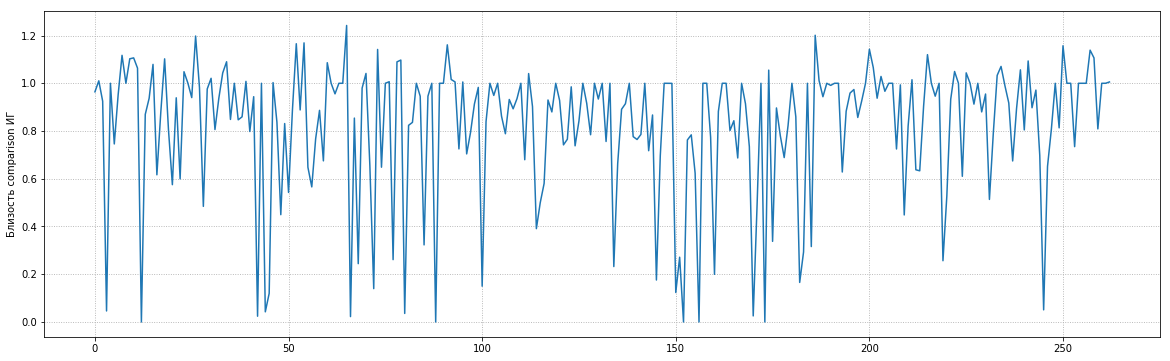

In [142]:
figsize = (20,6)

fig = plt.figure(figsize=figsize, frameon=True)

plt.gca().grid(True)

gridlines = plt.gca().get_xgridlines() + plt.gca().get_ygridlines()

line_width = 0.9

for line in gridlines:
    line.set_linestyle(':')
    line.set_linewidth(line_width)

plt.plot(res_4['no_tf'])
plt.ylabel('Близость comparison ИГ')
plt.show()

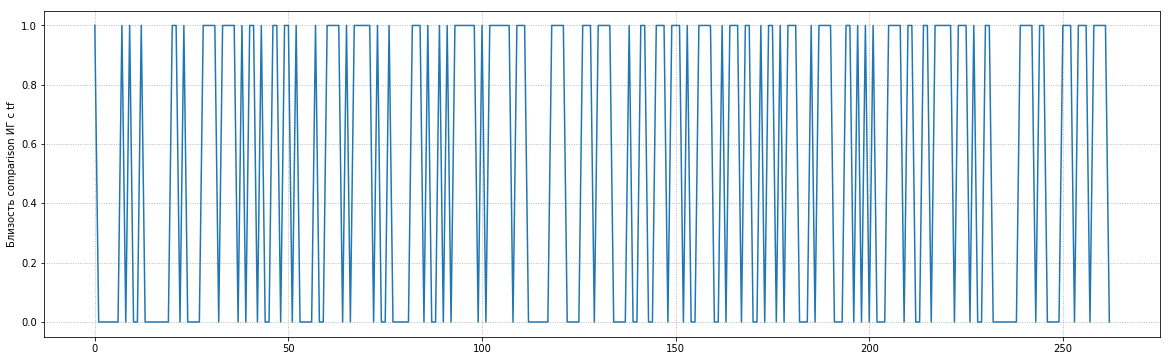

In [160]:
figsize = (20,6)

fig = plt.figure(figsize=figsize, frameon=True)

plt.gca().grid(True)

gridlines = plt.gca().get_xgridlines() + plt.gca().get_ygridlines()

line_width = 0.9

for line in gridlines:
    line.set_linestyle(':')
    line.set_linewidth(line_width)

plt.plot(res_4['with_tf'])
plt.ylabel('Близость comparison ИГ c tf')
plt.show()

In [158]:
print('Среднее comparison')
np.median(np.array(res_4['no_tf']))

Среднее comparison


0.9281643339561831

In [159]:
print('Среднее comparison c tf')
np.median(np.array(res_4['with_tf']))

Среднее comparison c tf


1.0

In [143]:
contr_first_ig = []
contr_second_ig = []

for ind, el in enumerate(first_contr_sent):
    subj_1 = []
    root_1 = ''
    for i in el:
        i_l1 = i.split('\t')
        if 'root' in i:
            #i_l1 = i.split('\t')
            #print(i_l1[2].lower())
            root_1 = i_l1[1].lower()
        if 'nsubj' in i:
            subj_1.append((i_l1[1].lower(), i_l1[6]))
    #print('????')
    
    
    subj_2 = []
    root_2 = ''
    for j in second_contr_sent[ind]:
        #print(j)
        i_l2 = j.split('\t')
        if 'root' in j:
            #i_l2 = j.split('\t')
            #print(i_l2[2].lower())
            root_2 = i_l2[1].lower()
        if 'nsubj' in j:
            #print(i_l2)
            subj_2.append((i_l2[1].lower(), i_l2[6]))
        
    
    near_1 = 0
    sub_1 = ''
    for sub in subj_1:
        if near_1 == 0:
            near_1 = sub[1]
            sub_1 = sub[0]
        else:
            if near_1 > sub[1]:
                near_1 = sub[1]
                sub_1 = sub[0]
    it_1 = root_1+' '+sub_1
    contr_first_ig.append(it_1)
    
    
    near_2 = 0
    sub_2 = ''
    for sub in subj_2:
        if near_2 == 0:
            near_2 = sub[1]
            sub_2 = sub[0]
        else:
            if near_2 > sub[1]:
                near_2 = sub[1]
                sub_2 = sub[0]
    it_2 = root_2+' '+sub_2
    contr_second_ig.append(it_2)
        
    #print('-------')


In [144]:
print(len(contr_first_ig))
len(contr_second_ig)

569


569

In [146]:
contr_first_ig[:7]

['распространился настрой',
 'идет речь',
 'трудно кто',
 'осталось $',
 ' снижение',
 'заставила рынки',
 'должна которая']

In [147]:
dim = 50
X_ig_1_w2v_2 = []
X_ig_2_w2v_2 = []
print(len(contr_first_ig))

for i, text in enumerate(contr_first_ig):
    #print(text)
    X_ig_1_w2v_2.append(get_embedding(text, w2v))
    
for i, text in enumerate(contr_second_ig):
    X_ig_2_w2v_2.append(get_embedding(text, w2v))

#X_text_w2v = [X_text_1_w2v, X_text_2_w2v]
print(len(X_ig_1_w2v_2))


569
569


In [154]:
X_ig_1_w2v_tf_2 = []
X_ig_2_w2v_tf_2 = []

for i, text in enumerate(contr_first_ig):
    X_ig_1_w2v_tf_2.append(get_embedding(text, w2v, tfidf))
    
for i, text in enumerate(contr_second_ig):
    X_ig_2_w2v_tf_2.append(get_embedding(text, w2v, tfidf))
len(X_ig_2_w2v_tf_2)

569

In [149]:
#res_5 = pd.DataFrame()

In [150]:
#res_5['no_tf'] = [get_dicstance(X_ig_1_w2v_2[i], v) for i, v in enumerate(X_ig_2_w2v_2)]

In [155]:
#res_5['with_tf'] = [get_dicstance(X_ig_1_w2v_tf_2[i], v) for i, v in enumerate(X_ig_2_w2v_tf_2)]

In [4]:
res_5 = pd.read_csv('contr_distance_ig.csv')

In [5]:
res_5.head()

no_tf   with_tf
0  1.134355  1.124272
1  0.995569  1.040061
2  0.833397  1.000000
3  1.043253  1.000000
4  1.187032  1.187032

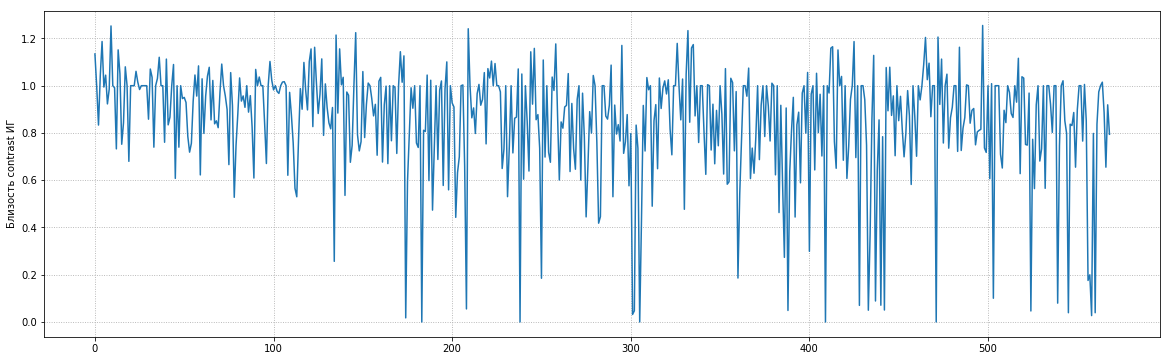

In [157]:
figsize = (20,6)

fig = plt.figure(figsize=figsize, frameon=True)

plt.gca().grid(True)

gridlines = plt.gca().get_xgridlines() + plt.gca().get_ygridlines()

line_width = 0.9

for line in gridlines:
    line.set_linestyle(':')
    line.set_linewidth(line_width)

plt.plot(res_5['no_tf'])
plt.ylabel('Близость contrast ИГ')
plt.show()

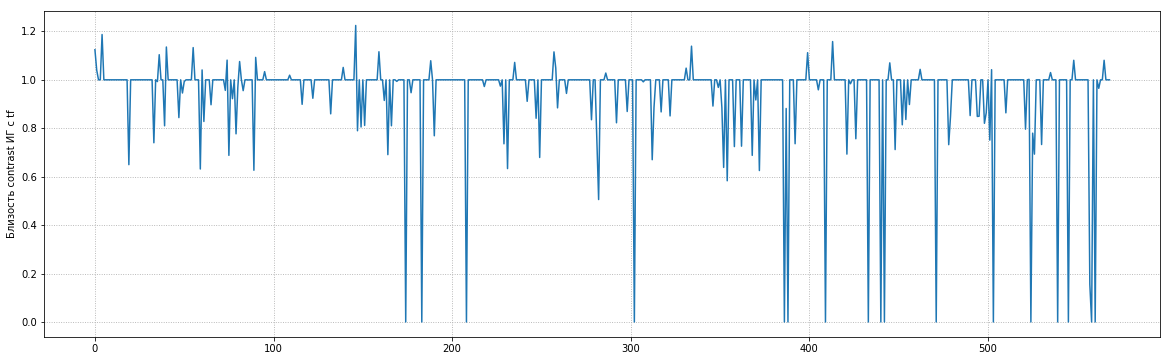

In [161]:
figsize = (20,6)

fig = plt.figure(figsize=figsize, frameon=True)

plt.gca().grid(True)

gridlines = plt.gca().get_xgridlines() + plt.gca().get_ygridlines()

line_width = 0.9

for line in gridlines:
    line.set_linestyle(':')
    line.set_linewidth(line_width)

plt.plot(res_5['with_tf'])
plt.ylabel('Близость contrast ИГ c tf')
plt.show()

In [162]:
print('Среднее contrast')
np.median(np.array(res_5['no_tf']))

Среднее contrast


0.9180410686286681

In [163]:
print('Среднее contrast c tf')
np.median(np.array(res_5['with_tf']))

Среднее contrast c tf


1.0

In [6]:
ig_comp_tf = []
colw2 = 0
for el in res_4['with_tf']:
    if el <= 1.0:
        ig_comp_tf.append(el)
    else:
        ig_comp_tf.append(1.0)


ig_contr_tf = []
colw2 = 0
for el in res_5['with_tf']:
    if el <= 1.0:
        ig_contr_tf.append(el)
    else:
        ig_contr_tf.append(1.0)


ig_comp = []
colw2 = 0
for el in res_4['no_tf']:
    if el <= 1.0:
        ig_comp.append(el)
    else:
        ig_comp.append(1.0)


ig_contr = []
colw2 = 0
for el in res_5['no_tf']:
    if el <= 1.0:
        ig_contr.append(el)
    else:
        ig_contr.append(1.0)


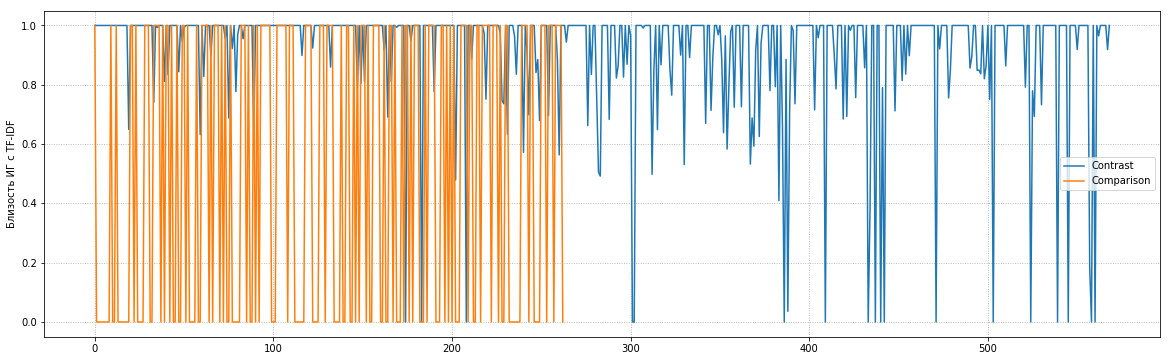

In [7]:
figsize = (20,6)

fig = plt.figure(figsize=figsize, frameon=True) 

plt.gca().grid(True)

gridlines = plt.gca().get_xgridlines() + plt.gca().get_ygridlines()

line_width = 0.9

for line in gridlines:
    line.set_linestyle(':')
    line.set_linewidth(line_width)


plt.plot(ig_contr_tf, label = 'Contrast')
plt.plot(ig_comp_tf, label = 'Comparison')
plt.legend()
plt.ylabel('Близость ИГ c TF-IDF')
plt.show()

### Считаем частицы

In [209]:
m.analyze('Я не люблю есть без тебя')

[{'analysis': [{'gr': 'SPRO,ед,1-л=им', 'lex': 'я'}], 'text': 'Я'},
 {'text': ' '},
 {'analysis': [{'gr': 'PART=', 'lex': 'не'}], 'text': 'не'},
 {'text': ' '},
 {'analysis': [{'gr': 'V,несов,пе=непрош,ед,изъяв,1-л', 'lex': 'любить'}],
  'text': 'люблю'},
 {'text': ' '},
 {'analysis': [{'gr': 'V,нп=(непрош,ед,изъяв,3-л,несов|непрош,мн,изъяв,3-л,несов|наст,мн,изъяв,1-л,несов|наст,ед,изъяв,1-л,несов|наст,мн,изъяв,2-л,несов|наст,ед,изъяв,2-л,несов|наст,мн,изъяв,3-л,несов|наст,ед,изъяв,3-л,несов)',
    'lex': 'быть'}],
  'text': 'есть'},
 {'text': ' '},
 {'analysis': [{'gr': 'PR=', 'lex': 'без'}], 'text': 'без'},
 {'text': ' '},
 {'analysis': [{'gr': 'SPRO,ед,2-л=(вин|род)', 'lex': 'ты'}], 'text': 'тебя'},
 {'text': '\n'}]

In [205]:
av_p = ['PART', 'PR', 'CONJ', 'INTJ']

In [210]:
av_pp = ['PART']

In [215]:
#countp_contr = 0
countp_contr_sent = 0

for ind, part_1 in enumerate(contr_all['full']):
    prev = countp_contr_sent
    try:
        m_1 = m.analyze(part_1)
        for lem_1 in m_1:
            if 'analysis' in lem_1 and lem_1['analysis'] != []:
                gr_1 = lem_1['analysis'][0]['gr'].split(',')
                for el in av_pp:
                    if el in gr_1[0]:
                        print(lem_1['analysis'][0]['lex'])
                        if countp_contr_sent == prev:
                            countp_contr_sent += 1
        print('-------------')
    except:
        break

не
только
не
лишь
-------------
не
прямо
-------------
не
-------------
не
бы
бы
бы
же
-------------
-------------
-------------
всего
лишь
-------------
-------------
просто
-------------
не
же
-------------
не
просто
-------------
бы
не
-------------
не
-------------
не
бы
даже
-------------
ли
то
ли
ли
-------------
не
-------------
-------------
-------------
-------------
-------------
-------------
-------------
и
-------------
только
-------------
не
-------------
-------------
-------------
не
не
же
не
-------------
же
не
-------------
вот
-------------
не
-------------
даже
не
-------------
не
-------------
не
-------------
-------------
это
-------------
-------------
тоже
-------------
не
-------------
только
нет
не
-------------
не
не
-------------
-------------
только
-------------
вот
себе
-------------
ли
не
просто
-------------
-------------
-------------
не
-------------
ли
не
просто
-------------
это
не
-------------
не
-------------
-------------
не
-------------
это

In [212]:
countp_contr

257

In [216]:
countp_contr_sent

135

In [217]:
#countp_comp = 0
countp_comp_sent = 0

for ind, part_1 in enumerate(comp_all['full']):
    prev = countp_comp_sent
    try:
        m_1 = m.analyze(part_1)
        for lem_1 in m_1:
            if 'analysis' in lem_1 and lem_1['analysis'] != []:
                gr_1 = lem_1['analysis'][0]['gr'].split(',')
                for el in av_pp:
                    if el in gr_1[0]:
                        print(lem_1['analysis'][0]['lex'])
                        if countp_comp_sent == prev:
                            countp_comp_sent += 1
        print('-------------')
    except:
        break

это
-------------
-------------
-------------
-------------
-------------
-------------
ни
-------------
-------------
не
только
-------------
не
-------------
-------------
-------------
только
не
не
-------------
не
не
не
не
не
же
-------------
не
не
не
не
не
не
-------------
не
не
даже
не
-------------
-------------
не
не
только
-------------
-------------
бы
-------------
не
не
-------------
-------------
б
б
-------------
даже
не
же
-------------
-------------
-------------
-------------
бы
-------------
не
-------------
-------------
просто
-------------
бы
-------------
не
не
даже
-------------
-------------
-------------
не
же
-------------
-------------
не
же
даже
ведь
даже
-------------
же
-------------
не
-------------
же
-------------
это
не
-------------
-------------
-------------
не
-------------
-------------
-------------
только
-------------
не
не
только
-------------
-------------
всего
-------------
-------------
де
не
не
-------------
не
не
-------------
----------

In [214]:
countp_comp

257

In [218]:
countp_comp_sent

140

In [219]:
print(135/569)
140/263

0.23725834797891038


0.532319391634981

In [222]:
table = [ [ 135, 434 ], [ 140, 123 ] ]

In [223]:
chi2, prob, df, expected = scipy.stats.chi2_contingency(table)

output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"

print(output.format( chi2, df, prob))

print(expected)

test Statistics: 69.43926600730957
degrees of freedom: 1
p-value: 7.880409755371655e-17

[[188.07091346 380.92908654]
 [ 86.92908654 176.07091346]]


In [230]:
neg = ['не', 'ни', 'без', 'никто', 'ничто', 'ничей', 'никакой', 'нечего', 'некого', 'никогда']

В русском языке есть показатель отрицания с максимально широкой сочетаемостью – частица не, ср. не приехал, не ходи, не Ваня, не русский, не вчера и т.д. Отрицание выражается также частицей ни (на небе ни облачка; ни слуху, ни духу), местоимениями и наречиями с ни- (никто, ни о чем, никогда), предикативными местоимениями с не- (негде, некому), словами нет, нельзя и другими предикативами, прилагательными и наречиями с префиксом не- (невозможно, нежелательно, неженатый, немного). (Следует иметь в виду, что префикс не- может выражать не только отрицание, но и неопределенность, как в словах некто, некий, некоторый.) Частицы и прочие слова, выражающие отрицание, тоже называются отрицаниями. Есть словообразовательные элементы, которые содержат в своей семантике отрицание (беззлобный) или, по крайней мере, идею отмены предыдущего состояния (разлюбить, отклеить).

In [260]:
#countp_comp = 0
countneg_comp_sent = 0

for ind, part_1 in enumerate(comp_all['full']):
    prev = countneg_comp_sent
    #print(part_1)
    try:
        text_1 = part_1.split()
        #print()
        for el in text_1:
            result = re.match('(не)|(ни)', el)
            #print(result)
            if not result is None:
                print(el)
                if countneg_comp_sent == prev:
                    countneg_comp_sent += 1
        print('-------------')
    except:
        #print()
        break

него
-------------
-------------
-------------
немецкий
-------------
-------------
-------------
ни
немецком
неожиданное
-------------
-------------
не
-------------
не
некрасивым
-------------
небо
-------------
недалеко
-------------
не
-------------
не
не
не
не
них
не
-------------
не
не
не
не
небо
-------------
не
не
необходимая
не
-------------
немецкоязычного
неповторимость
-------------
не
немецкой
независимой
немецкой
не
-------------
нейтральную
-------------
-------------
недавнем
некорректно
неправильные
не
не
-------------
неторопливый
нет.
-------------
-------------
не
-------------
-------------
-------------
них
-------------
непосредственно
ним
-------------
не
-------------
-------------
невозможна,
-------------
-------------
нельзя
не
некоторые
нем
нечетко
не
-------------
-------------
нельзя
-------------
не
неслоговых
-------------
-------------
не
нельзя
несколько
нельзя
некой
невозможно
-------------
-------------
не
-------------
-------------
необходимо
не
-

In [261]:
countneg_comp_sent

127

In [262]:
#countp_comp = 0
countneg_contr_sent = 0

for ind, part_1 in enumerate(contr_all['full']):
    prev = countneg_contr_sent
    #print(part_1)
    try:
        text_1 = part_1.split()
        #print()
        for el in text_1:
            result = re.match('(не)|(ни)', el)
            #print(result)
            if not result is None:
                print(el)
                if countneg_contr_sent == prev:
                    countneg_contr_sent += 1
        print('-------------')
    except:
        break

не
не
-------------
не
-------------
не
непоправимый
-------------
не
-------------
-------------
-------------
-------------
-------------
несопоставимы)
-------------
не
-------------
не
никаких
некоторые
-------------
не
-------------
не
ни
-------------
никакой
не
-------------
неясным,
-------------
никак
не
-------------
-------------
неизвестна,
-------------
-------------
-------------
неизвестна,
некоторым
-------------
него
-------------
некоторые
небольшое
-------------
-------------
не
-------------
несколько
-------------
них
-------------
не
не
не
-------------
не
-------------
нескольких
-------------
не
-------------
не
невелика.
-------------
никак
не
-------------
неделю
не
-------------
неделю
-------------
немного
незначительные
-------------
неблагоприятный
-------------
-------------
не
-------------
нет
нет,
не
-------------
не
не
-------------
нет
ни
ни
-------------
-------------
немой,
-------------
не
-------------
-------------
-------------
не
-------------

In [247]:
#СТАРЫЙ ВАРИАНТ
#countp_comp = 0
countneg_contr_sent = 0

for ind, part_1 in enumerate(contr_all['full']):
    prev = countneg_contr_sent
    #print(part_1)
    try:
        text_1 = part_1.split()
        #print()
        for el in text_1:
            if el in neg:
                print(el)
                if countneg_contr_sent == prev:
                    countneg_contr_sent += 1
        print('-------------')
    except:
        break

не
не
-------------
не
-------------
не
-------------
не
-------------
-------------
-------------
-------------
-------------
-------------
не
-------------
не
-------------
не
-------------
не
ни
-------------
никакой
не
-------------
-------------
не
-------------
-------------
-------------
-------------
-------------
-------------
-------------
-------------
-------------
не
-------------
-------------
-------------
не
не
не
-------------
не
-------------
-------------
не
-------------
не
-------------
не
-------------
не
-------------
-------------
-------------
-------------
-------------
не
-------------
не
-------------
не
не
-------------
ни
ни
-------------
-------------
-------------
не
-------------
-------------
-------------
не
-------------
не
-------------
не
-------------
не
-------------
-------------
не
-------------
не
-------------
-------------
не
-------------
не
-------------
не
-------------
-------------
не
не
не
-------------
не
-------------
не
------------

In [263]:
countneg_contr_sent

148

In [249]:
print(97/569)
67/263

0.1704745166959578


0.25475285171102663

In [264]:
print(148/569)
127/263

0.2601054481546573


0.4828897338403042

In [272]:
#table = [ [ 148, 421 ], [ 127, 136 ] ]
table = [ [ 421, 148 ], [ 136, 127 ] ]

In [251]:
#ВАРИАНТ СО СПИСКОМ

chi2, prob, df, expected = scipy.stats.chi2_contingency(table)

output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"

print(output.format( chi2, df, prob))

print(expected)

test Statistics: 7.548659436170868
degrees of freedom: 1
p-value: 0.006005473538223893

[[112.15865385 456.84134615]
 [ 51.84134615 211.15865385]]


In [273]:
chi2, prob, df, expected = scipy.stats.chi2_contingency(table)

output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"

print(output.format( chi2, df, prob))

print(expected)

test Statistics: 39.342887082238136
degrees of freedom: 1
p-value: 3.5554567400225283e-10

[[380.92908654 188.07091346]
 [176.07091346  86.92908654]]
